Generic setup for the CW Nano

In [1]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET = 'NONE'
%run "../../../jupyter/Setup_Scripts/Setup_Generic.ipynb"
scope.adc.samples = 5000
scope._cwusb.usbtx.rep = 0x81
scope._cwusb.usbtx.wep = 0x02

INFO: Found ChipWhisperer😍


Calling The path for the hex file and programming the bord

In [11]:
fw_path = "./calc/calc-CWNANO.hex"
cw.program_target(scope, cw.programmers.STM32FProgrammer, fw_path)

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 13531 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 13531 bytes


Reboot function is used to manipulate the array bytes.

In [12]:
def reboot_flush():
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

#############################################
There are two possible attack can be applied in this operation. 

1# CPA attack. However, The variation is very less. Even we found some bytes but the attack is not strong enough. Also, CPA has many calculation and comperatively more execution time.

2# Buffer overflow with addition and substraction. As soon as the buffer overflow happens there is a power drop. We are focusing ion this one.

#############################################

The main assumtion of this attack is that buffer overflow. That will be used as the vulnerability.

For example: A byte has the value 255 as 1111 1111. As soon as we add 1 it will be 1 0000 000. Here, The hamming weight will drop from 8 to 1. This will have a visible impact in the power. Similarly, if we substract 1 from 0000 0000 it will generate 1111 1111. There wil be similar impact.

Now, as the calculator hold the memory, and we have the option to manipulate the memory by performing calculation. We can use this function to manipulate the data inside.

The C code has a array as a int. Which is 32 bit (4 byte) and array has 3 elements. Difficulty to attack this program with brut force is 2^(32*32*32). Which is very hard or even not possible considering time and resources.

To simplify the attack, we only want to attack a byte of the array elemants. Therefor, we have only need to attck 4 byte in 4 loop.

Steps:
    
    1# We need to get rid of other bytes except the one we are attacking. 
    
    For example: if are attcking byte 0. Then we can remove the byte 3-1 as shifting the byte 0, 3*8 times to left. This will 
    keep the byte 0 to byte3. Then as we are using lsb byte to perform the operation, we need to shift the byte0 from msb 
    byte3. We can shift it 3*8 times to right. This will only keep the byte0 in the array. However baserd on the msb bit of the 
    leftover byte it will padd 1s or 0s in other3 msb bytes. Which is a advantage for the attcker to perform buffer overflow
    with sudden power drop/rise.        
    Main array-->  |<byte3>|<byte2>|<byte1>|<byte0>| 
    Shift left-->  |<byte0>|<*****>|<*****>|<*****>| (Shift left can be done by multiply by 2 for one shift right)
    Shift right->  |<*1/0*>|<*1/0*>|<*1/0*>|<byte0>| (Shift right can be done by dividing by 2 for one shift left)
    
    
    
    2# To get a higher power drop, we need a transaction of 0000 0000 to 1111 1111 or vice versa.
    therefor we will collect the power traces for addition of 0 to 255 as well as substraction 0 to 255.
    
    3. Repeat step 1-2 for each byte and collect the power traces for each byte.
    ##Note that, The power traces should be less noisy. Therefore we can collect the traces multiple times for same operation 
    and get the mean of thiose to decrerase the effect of noise. For our case we used 20 repeted trace collection. (Less is 
    also ok.)
        
    4. Perform the attack on the power traces and find the possible keys.
    
    
    



In [1]:
#Run this code if you only need to take the power traces
#

import time
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

for byte in range (1,5):
    print("Byte:",byte)
    reboot_flush()

    #change the value 1 to 4  at a time and save the power traces


    for i in range ((4-byte)*4):
        msg=[2**2]     
        scope.arm()
        target.simpleserial_write('m',bytearray(msg))  
        scope.capture()

    for i in range (3*4):
        msg=[2**2]     
        scope.arm()
        target.simpleserial_write('d',bytearray(msg))  
        scope.capture()

    #target.simpleserial_write('p',bytearray([0]))     
    #out_arr=target.simpleserial_read('r', 12)
    #print(list(out_arr))

    T=40
    D= 256

    repeat=20

    print("############## Substraction #####################")    

    base_power_substract=np.zeros([D,T],dtype='float')

    for i in trange (D):
        msg=[i % 256] 

        repeated_trace=np.zeros([repeat,T],dtype='float')
        for j in range (repeat): 

            scope.arm()
            target.simpleserial_write('s',bytearray(msg))    
            scope.capture()
            repeated_trace[j,:]=scope.get_last_trace()[0:T] 


            scope.arm()
            target.simpleserial_write('p',bytearray(msg))
            scope.capture()

        base_power_substract[i,:]=np.mean(repeated_trace[:,:], axis=0)


    np.save("calc_pow_byte%d_sub.npy" %byte,base_power_substract)   
    print("############## Addition #####################")    
    ###
    base_power_plus=np.zeros([D,T],dtype='float')

    for i in trange (D):
        msg=[i % 256] 

        repeated_trace=np.zeros([repeat,T],dtype='float')
        for j in range (repeat): 

            scope.arm()
            target.simpleserial_write('p',bytearray(msg))             
            scope.capture()
            repeated_trace[j,:]=scope.get_last_trace()[0:T]         

            scope.arm()
            target.simpleserial_write('s',bytearray(msg))
            scope.capture()

        base_power_plus[i,:]=np.mean(repeated_trace[:,:], axis=0)
    np.save("calc_pow_byte%d_plus.npy" %byte,base_power_plus)   



Byte: 1


NameError: name 'reboot_flush' is not defined

G:\csaw21\ChipWhisperer5_64\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


pos: 103 Neg: 179 pp:1 pn:11 pco:0.174322 pcn:0.008721
pos: 30 Neg: 211 pp:46 pn:1 pco:0.008153 pcn:0.085857
pos: 58 Neg: 156 pp:1 pn:8 pco:0.154199 pcn:0.010053
pos: 206 Neg: 205 pp:34 pn:1 pco:0.006219 pcn:0.090160
pos: 180 Neg: 179 pp:52 pn:1 pco:0.000782 pcn:0.011239
pos: 30 Neg: 127 pp:2 pn:55 pco:0.006242 pcn:0.001070
pos: 157 Neg: 156 pp:8 pn:1 pco:0.001626 pcn:0.012771
pos: 119 Neg: 191 pp:13 pn:1 pco:0.001501 pcn:0.010405
pos: 231 Neg: 230 pp:20 pn:1 pco:0.002238 pcn:0.035337
pos: 5 Neg: 4 pp:1 pn:8 pco:0.057922 pcn:0.013063
pos: 33 Neg: 32 pp:1 pn:15 pco:0.053975 pcn:0.013215
pos: 119 Neg: 118 pp:1 pn:17 pco:0.048275 pcn:0.007107
[ 1 46  1 34 52  2  8 13 20  1  1  1]
[103  30  58 206 180  30 157 119 231   5  33 119]
[11  1  8  1  1 55  1  1  1  8 15 17]
[179 211 156 205 179 127 156 191 230   4  32 118]
Final Memory: [103 211  58 205 179  30 156 191 230   5  33 119]


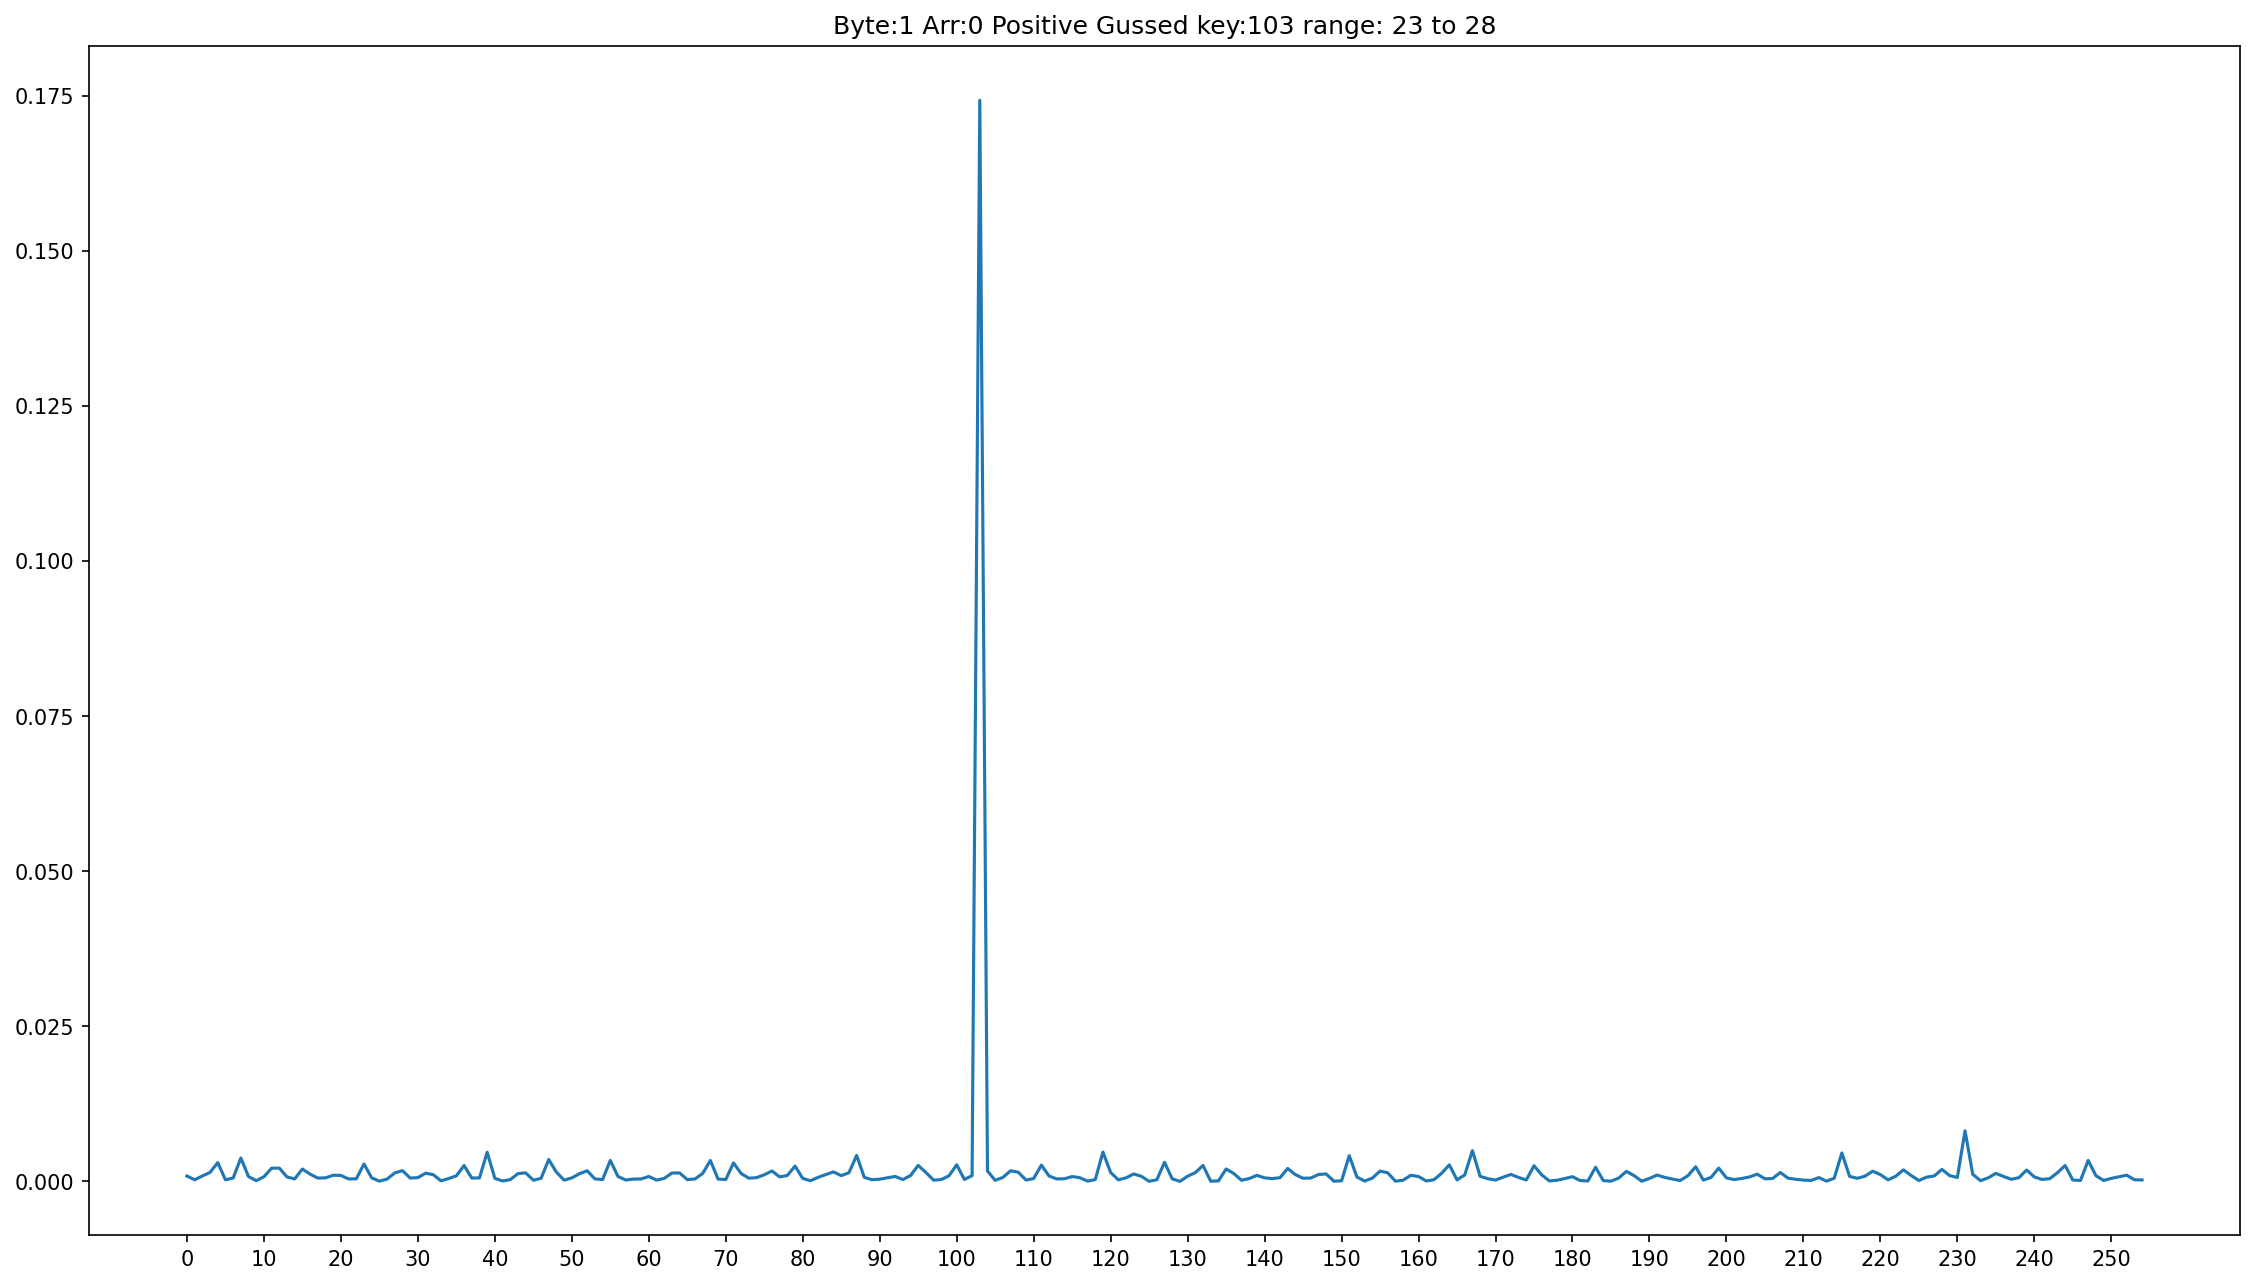

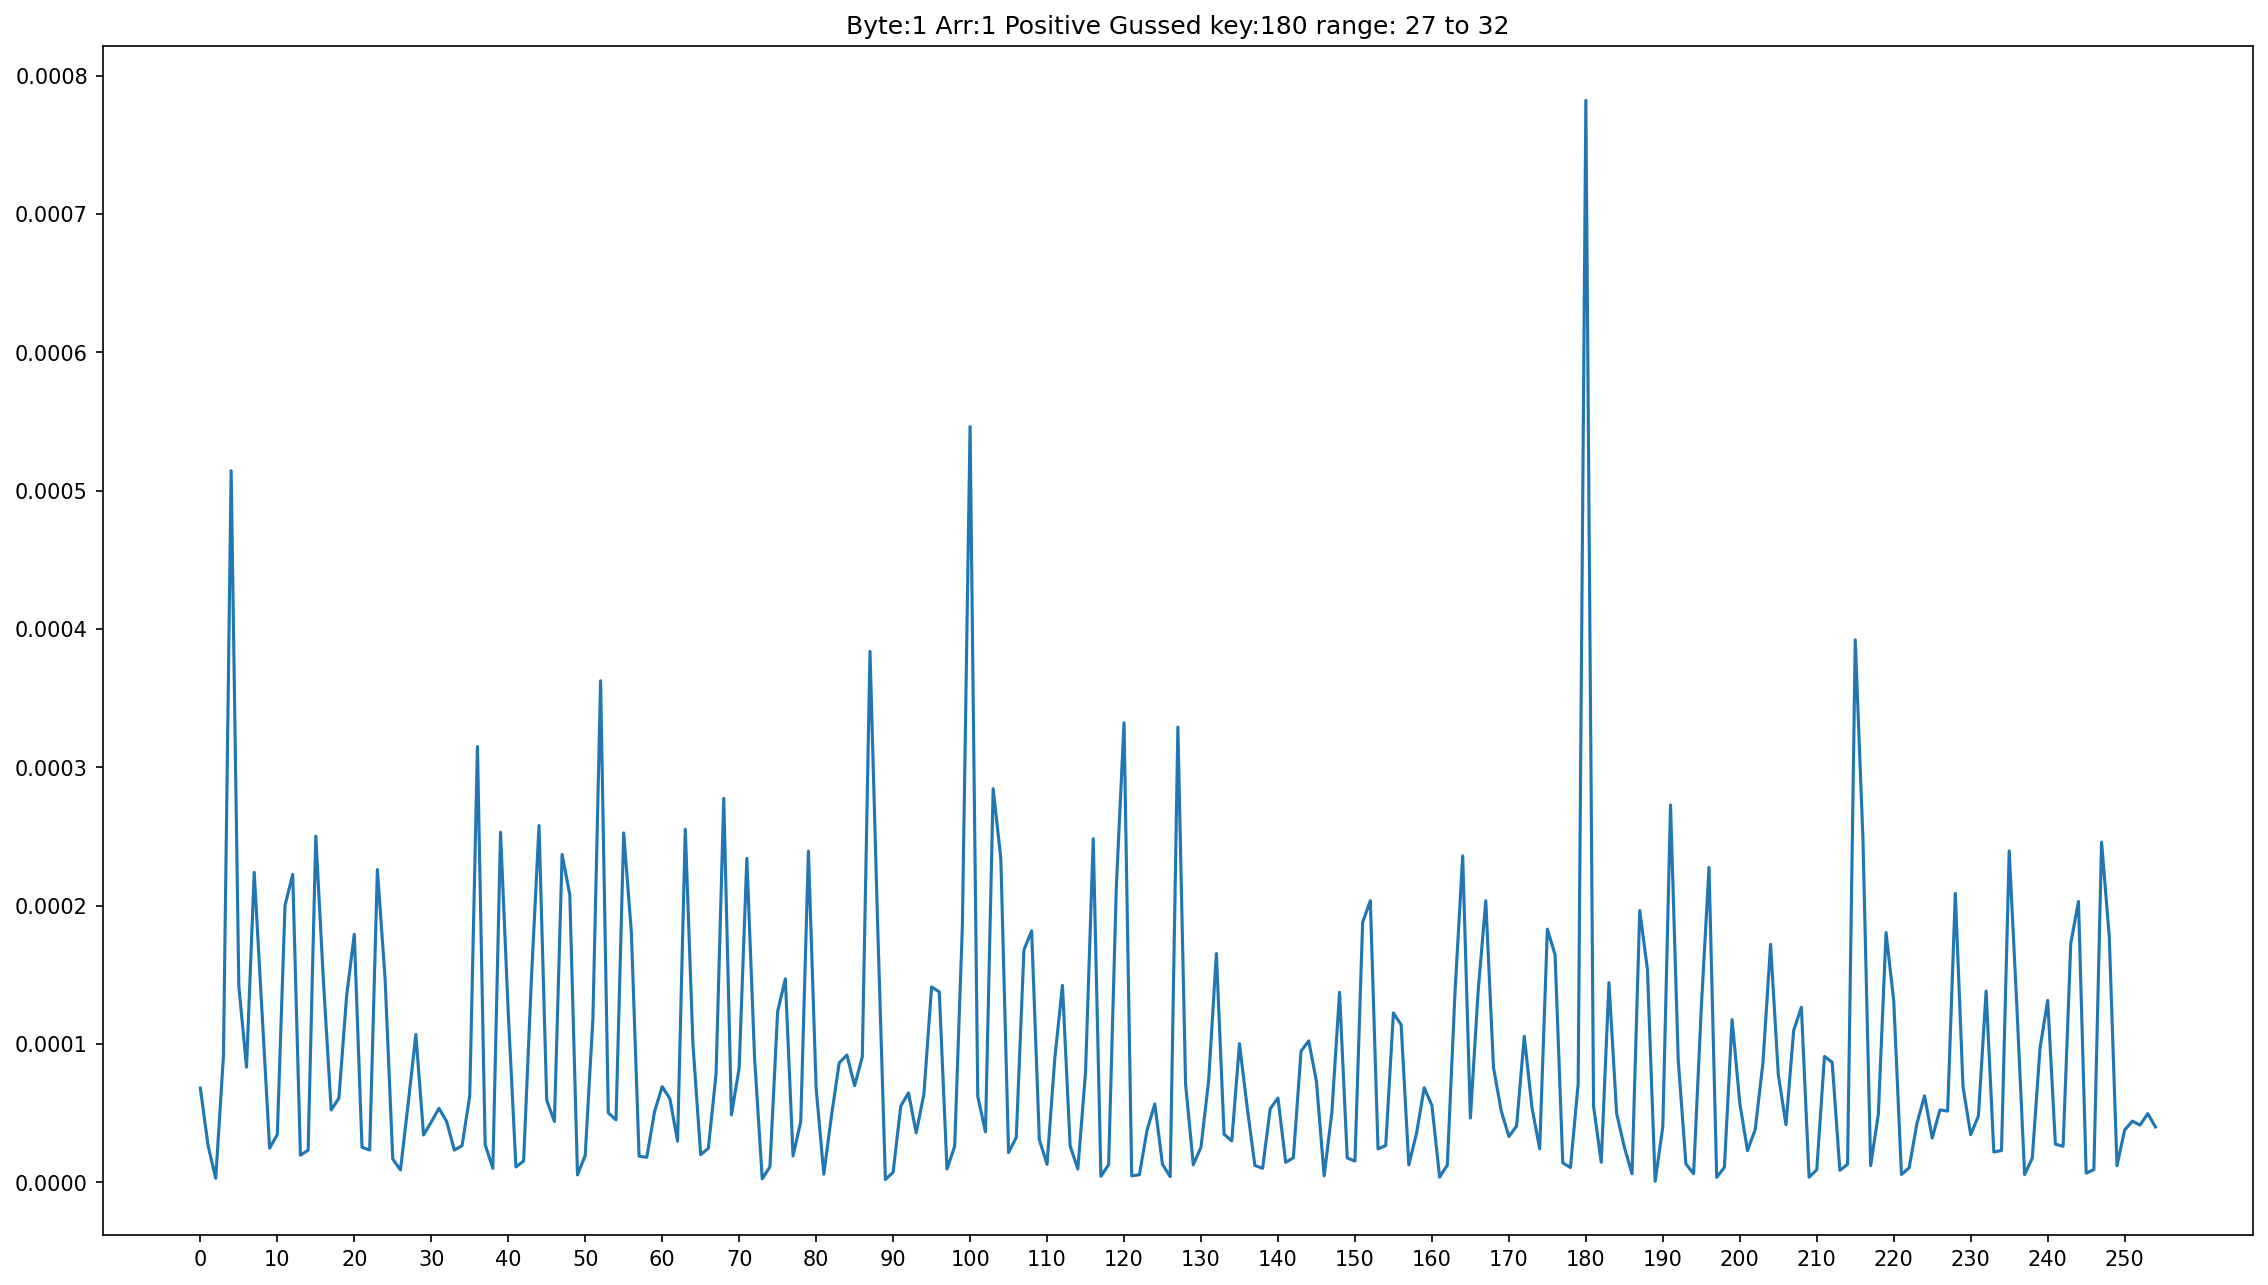

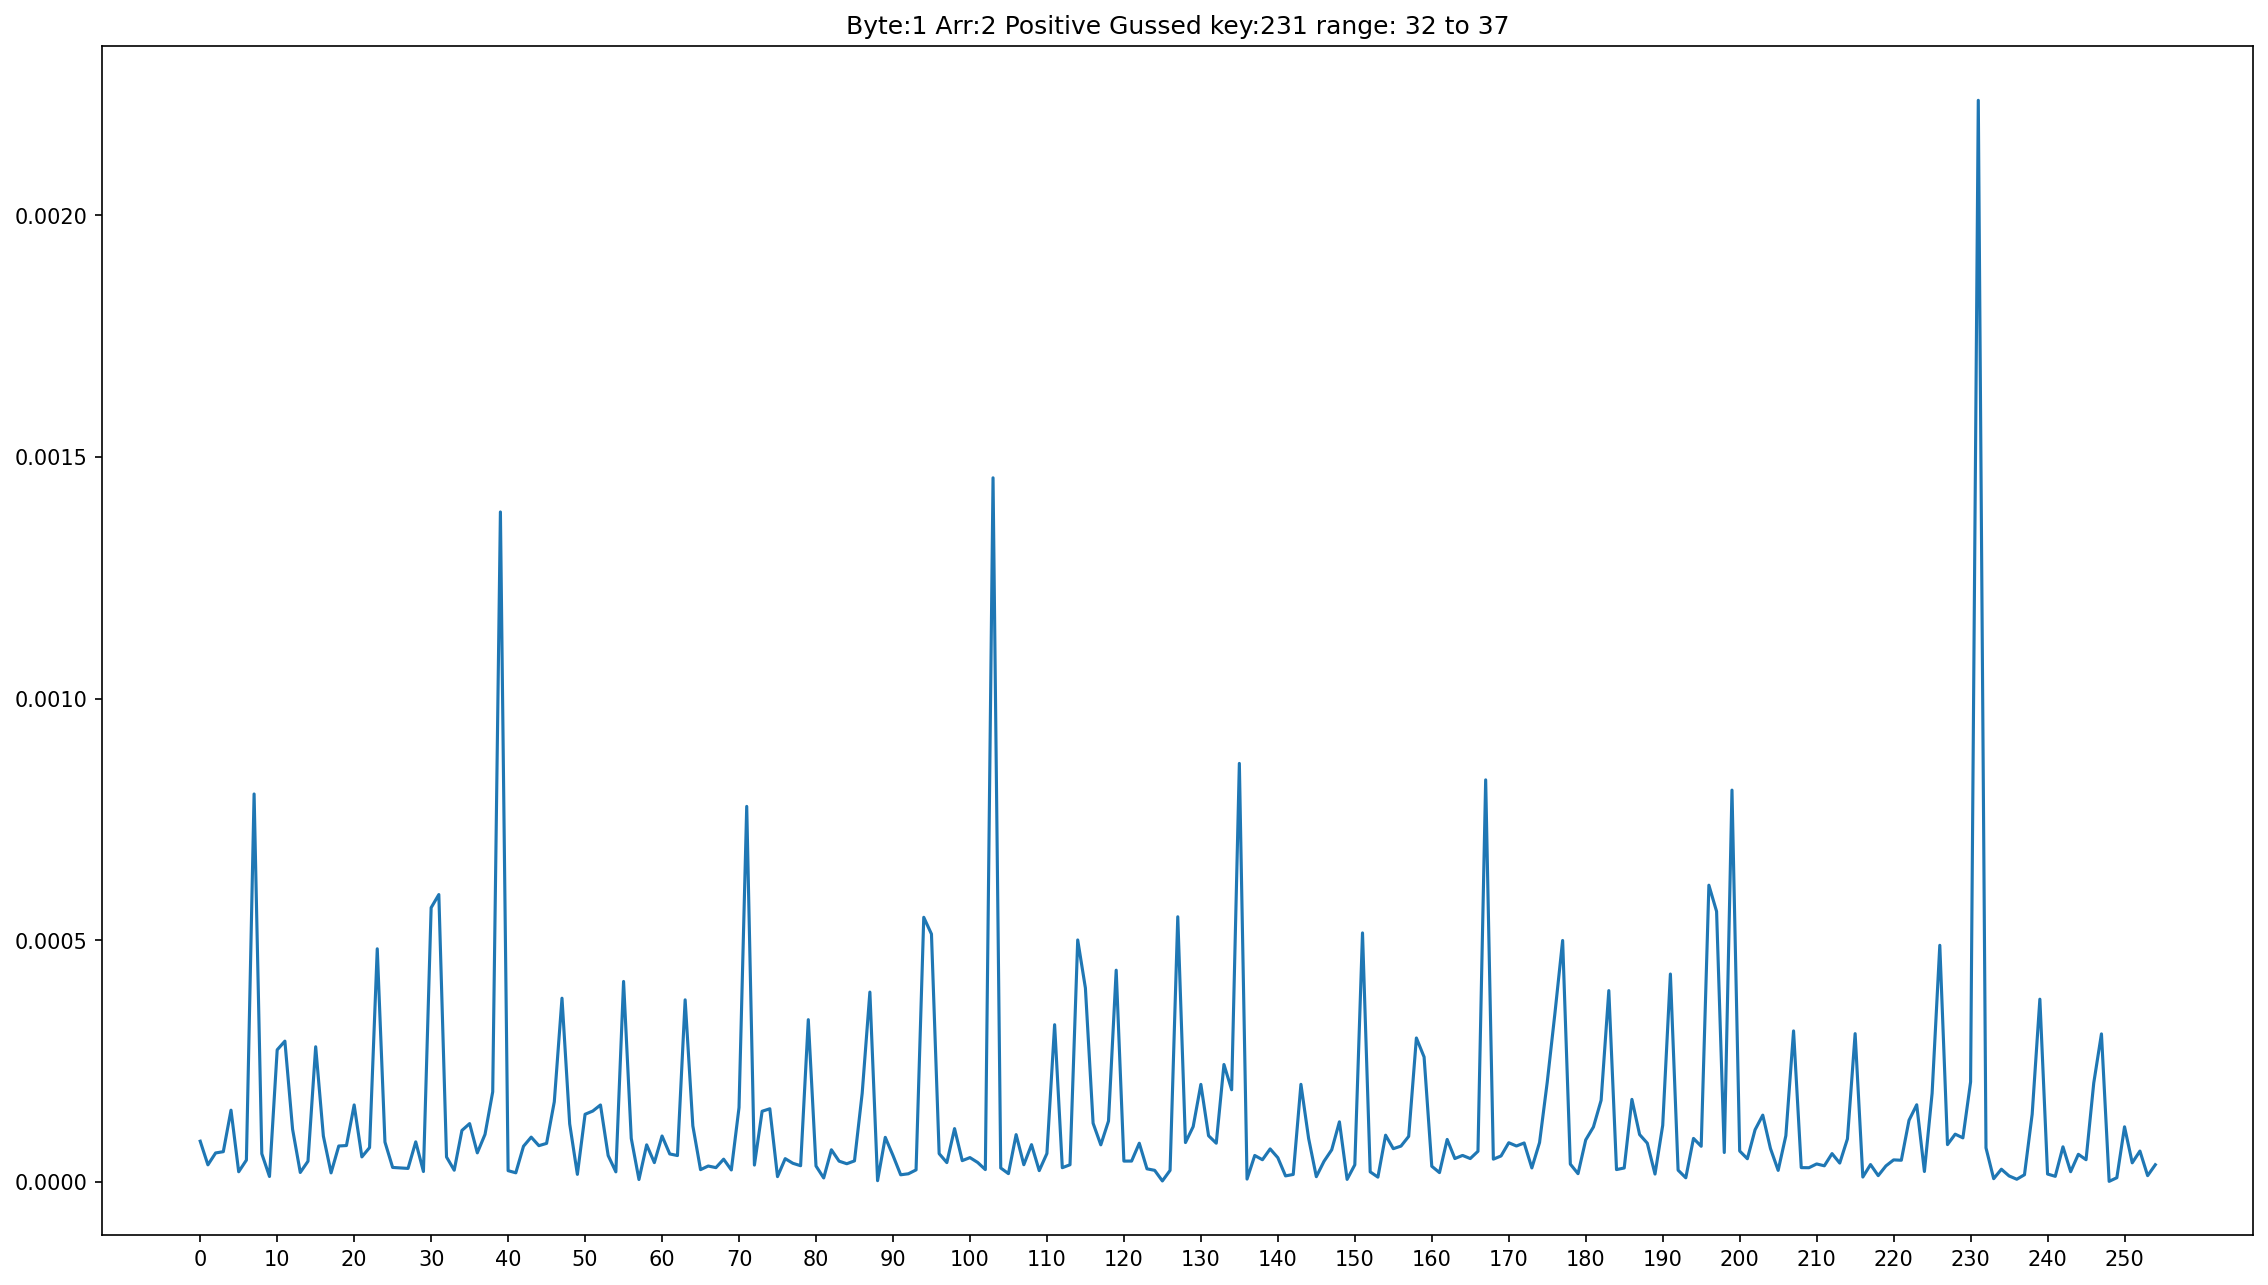

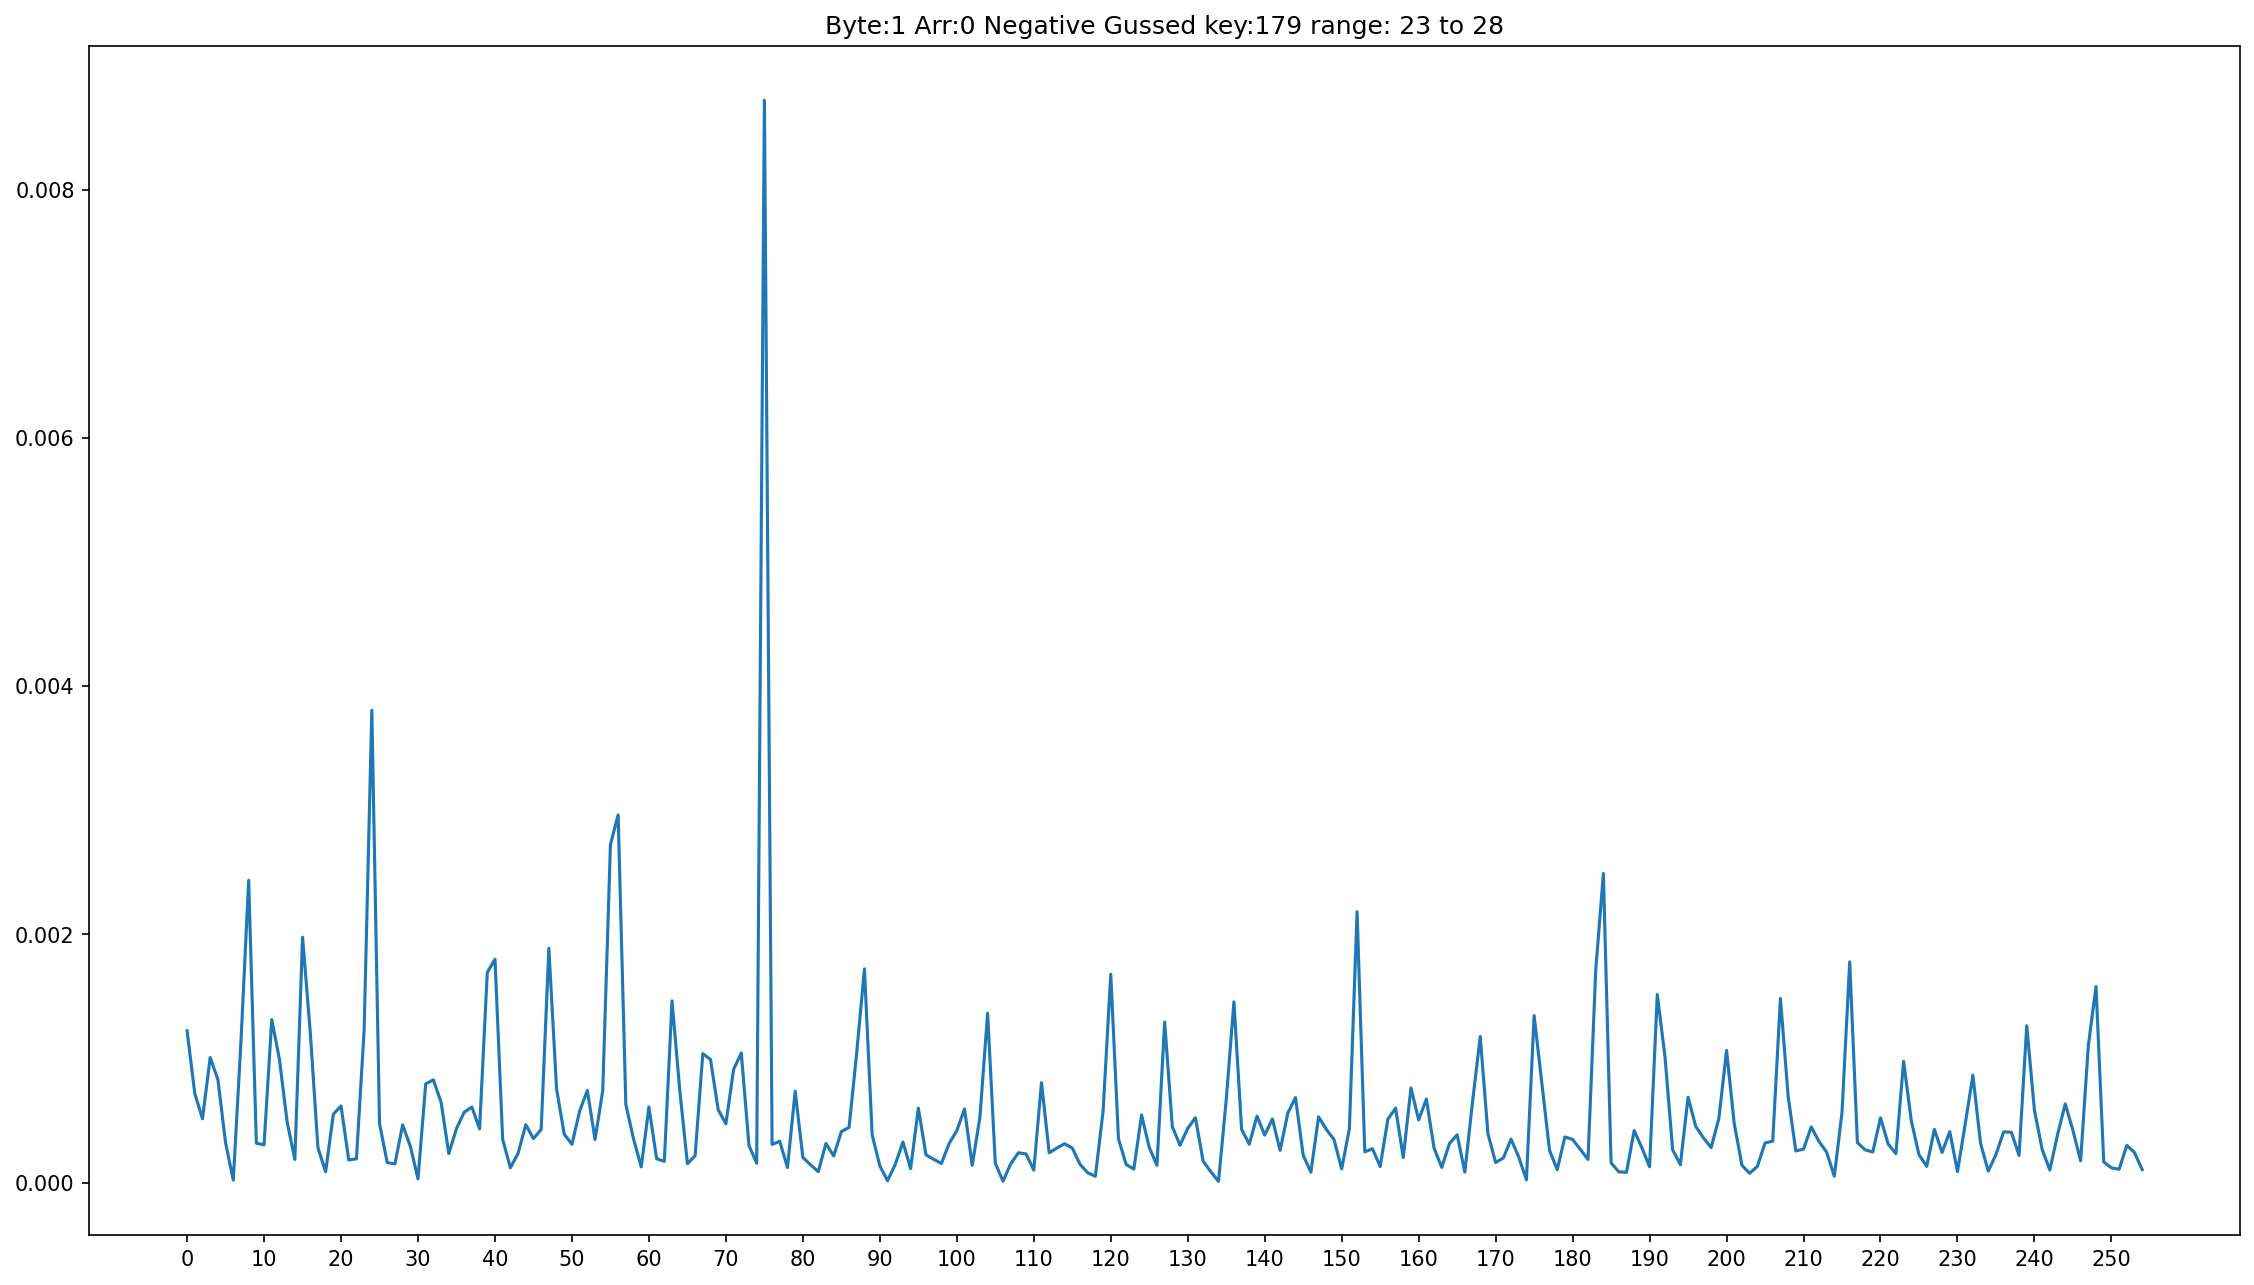

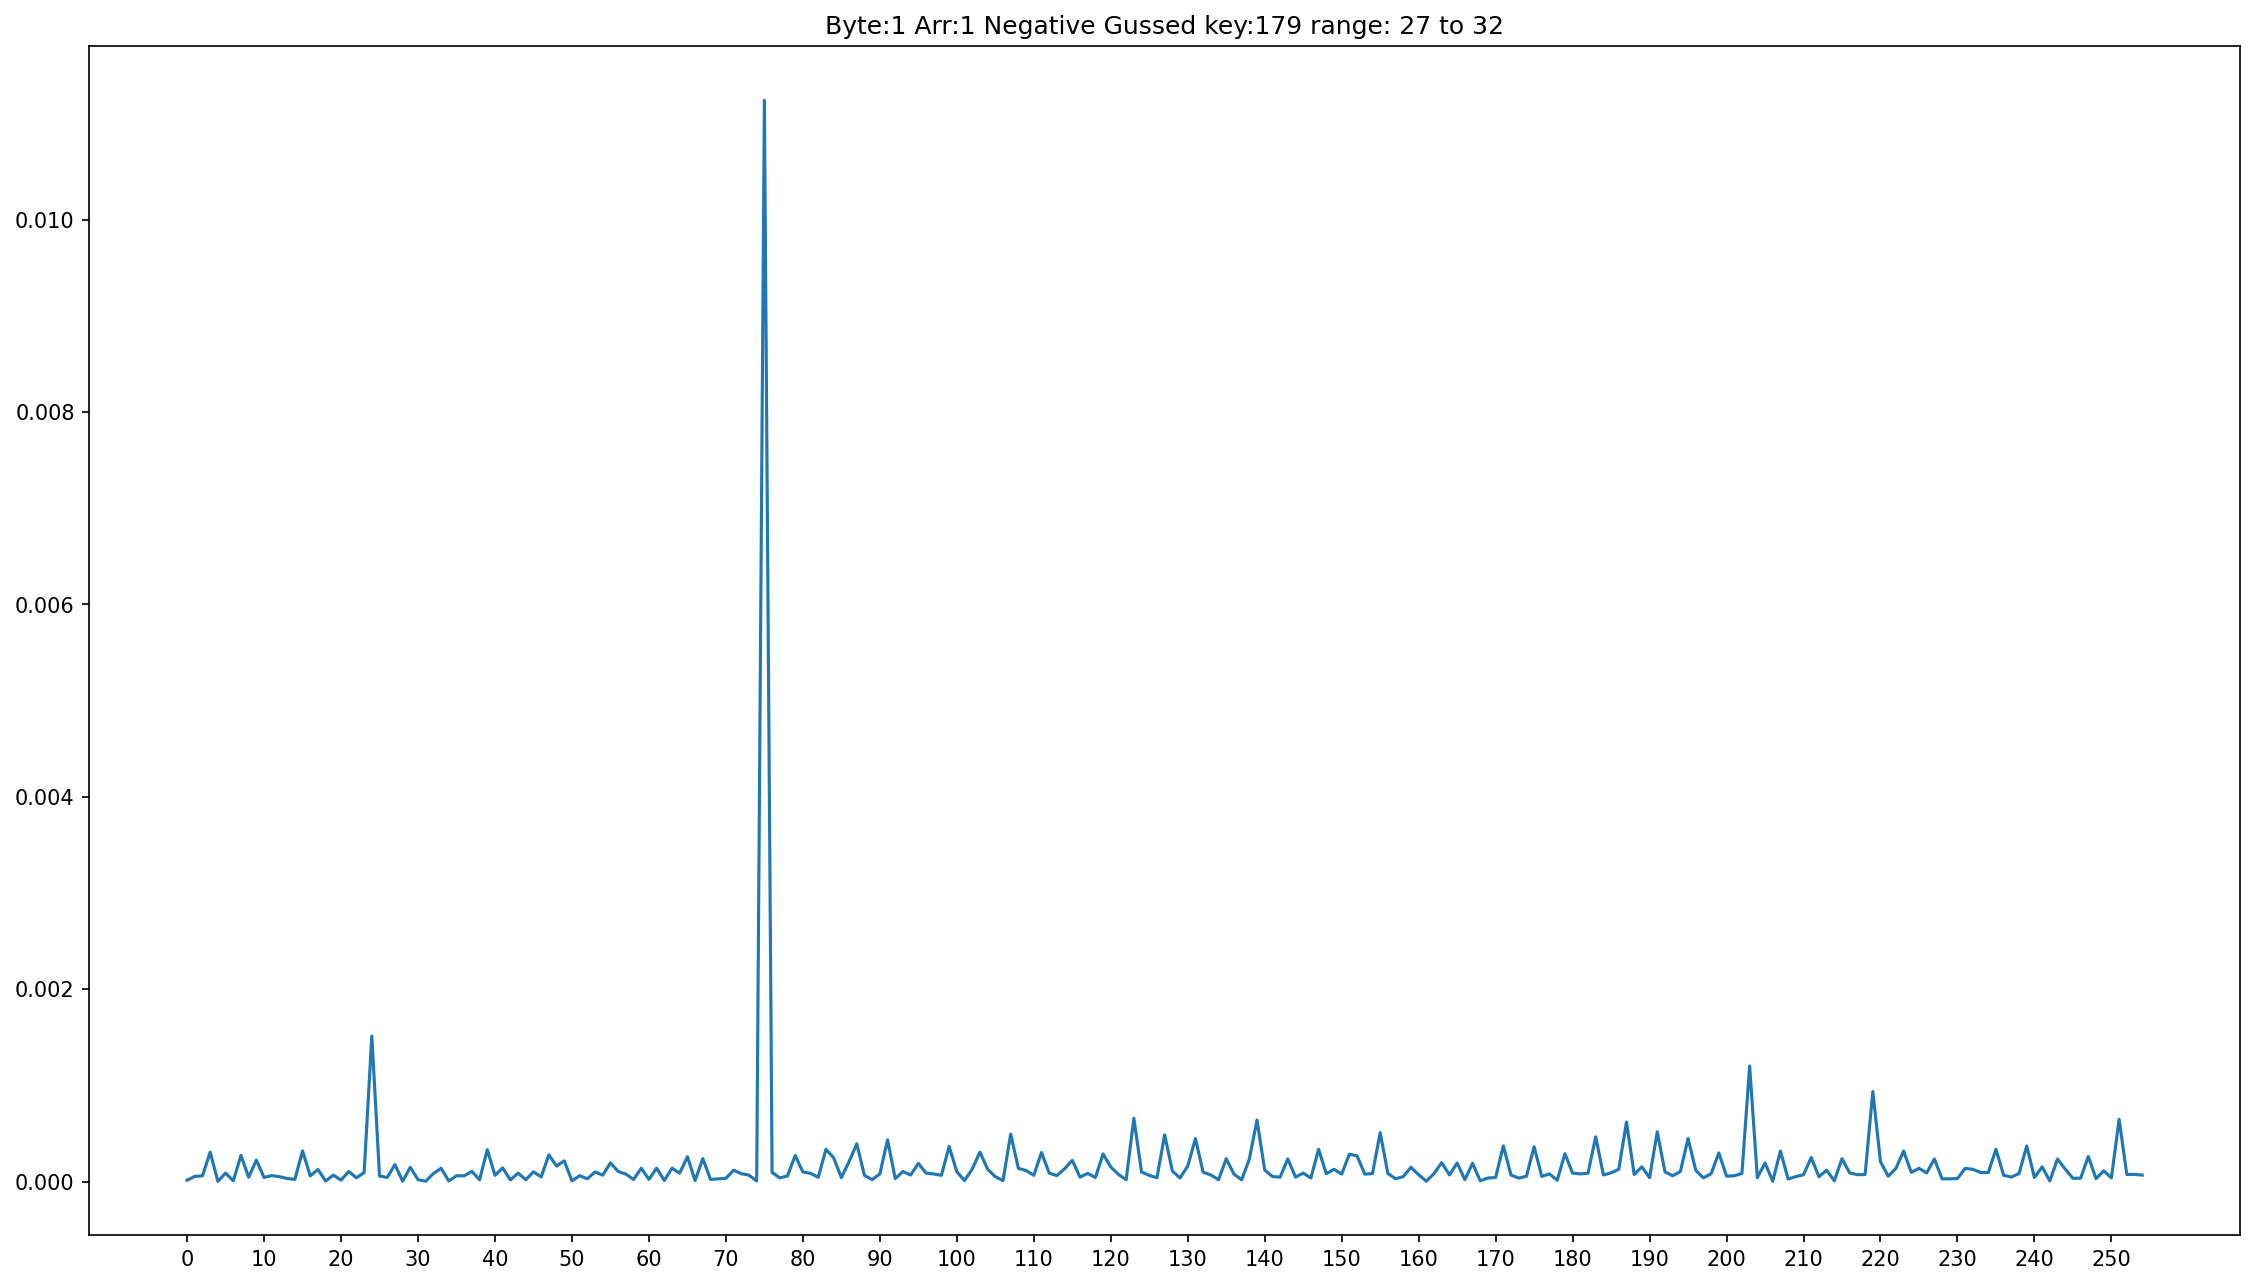

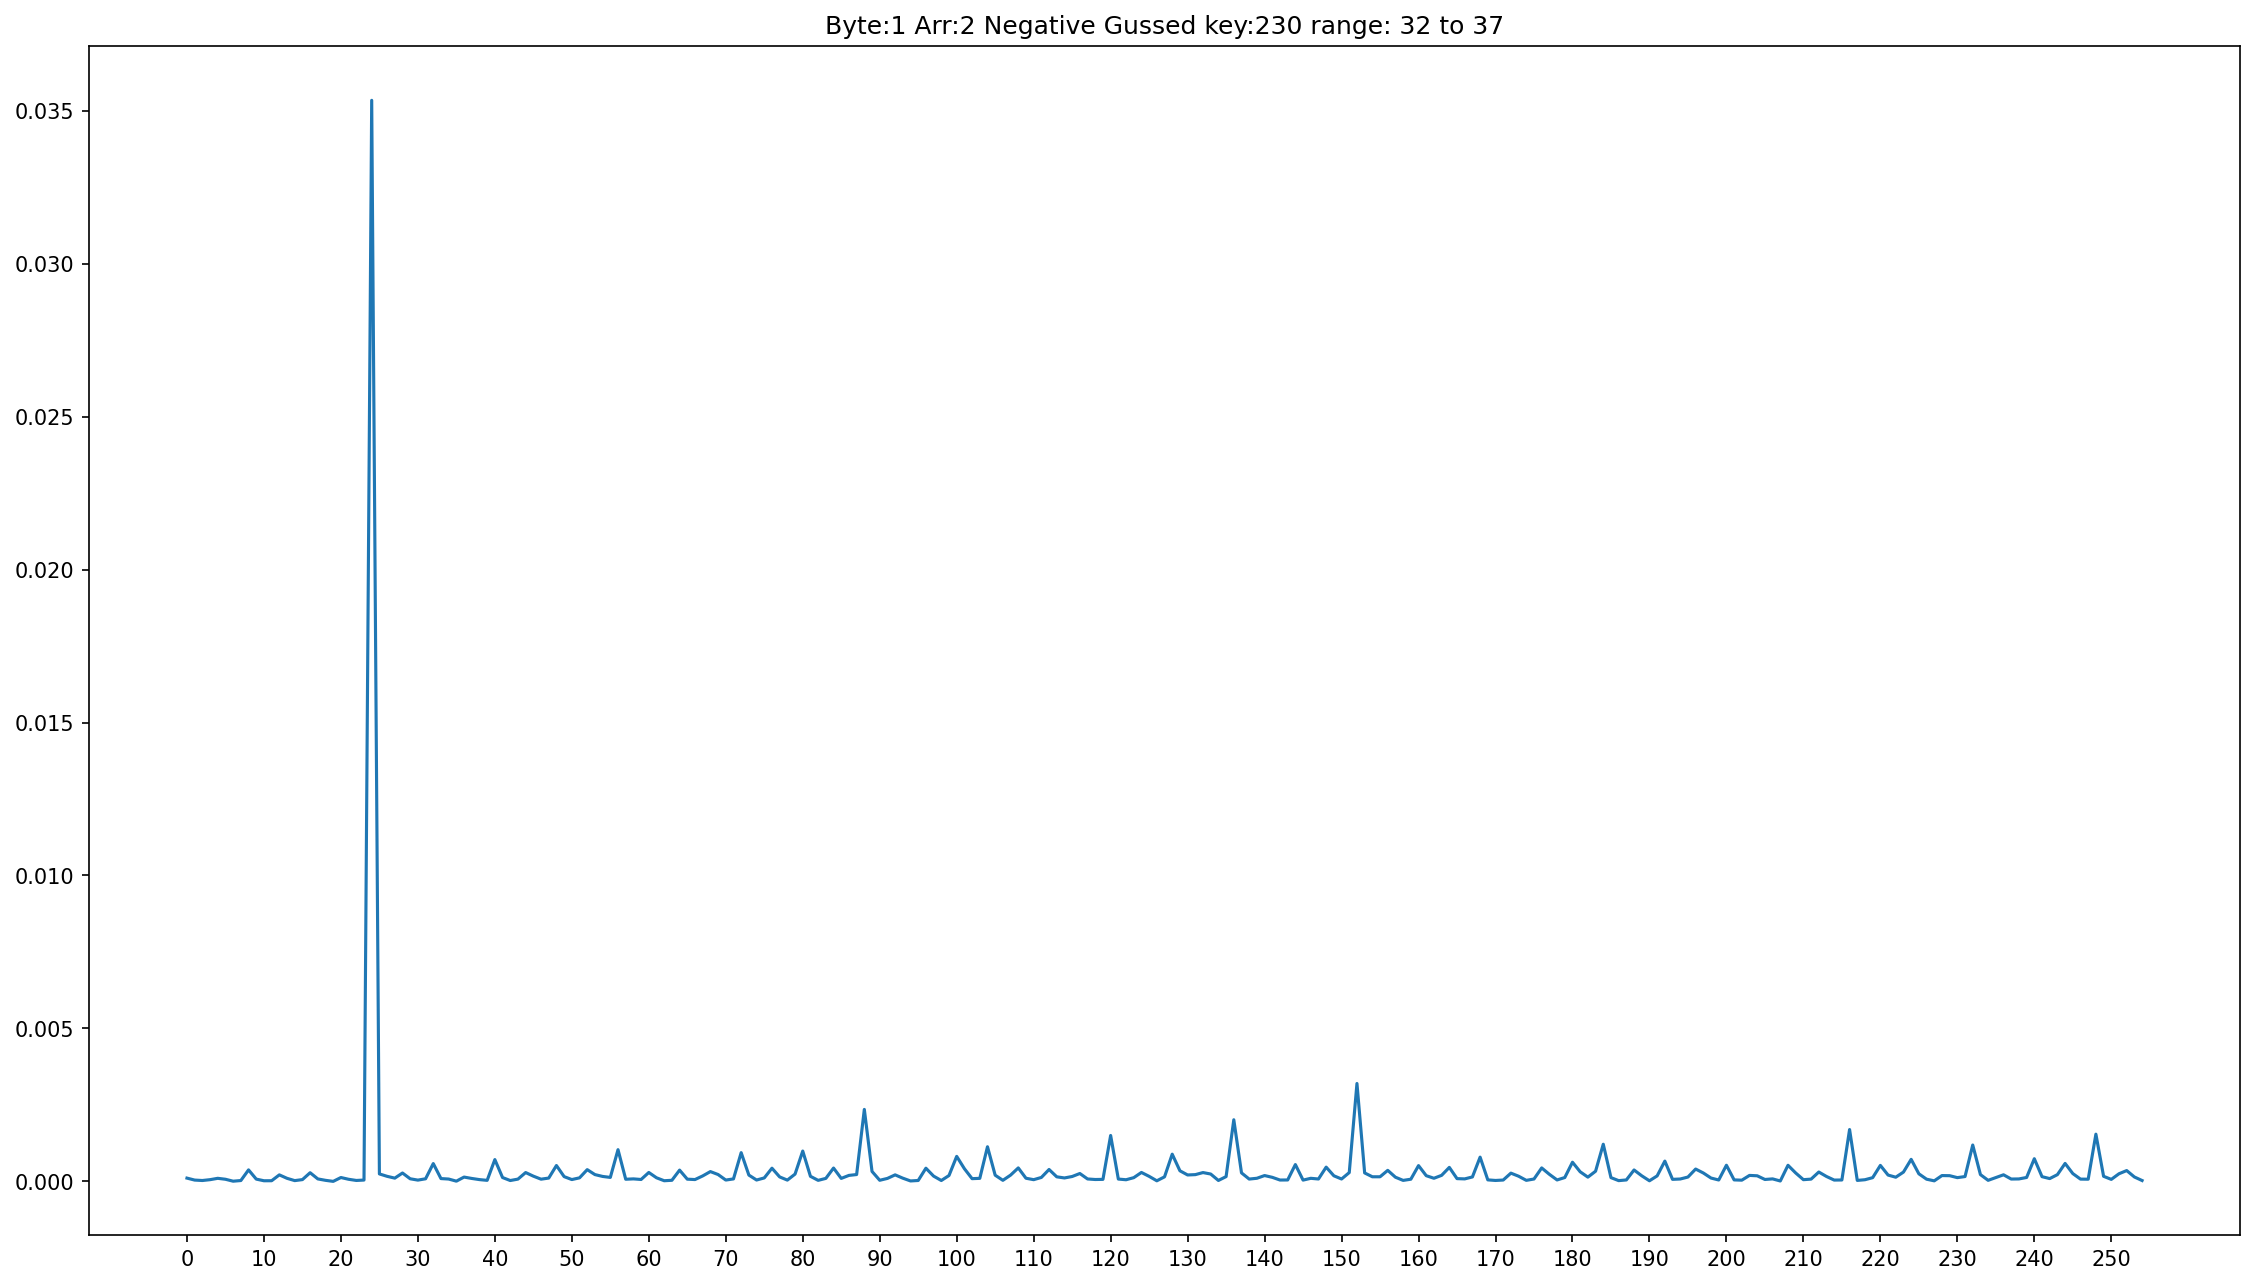

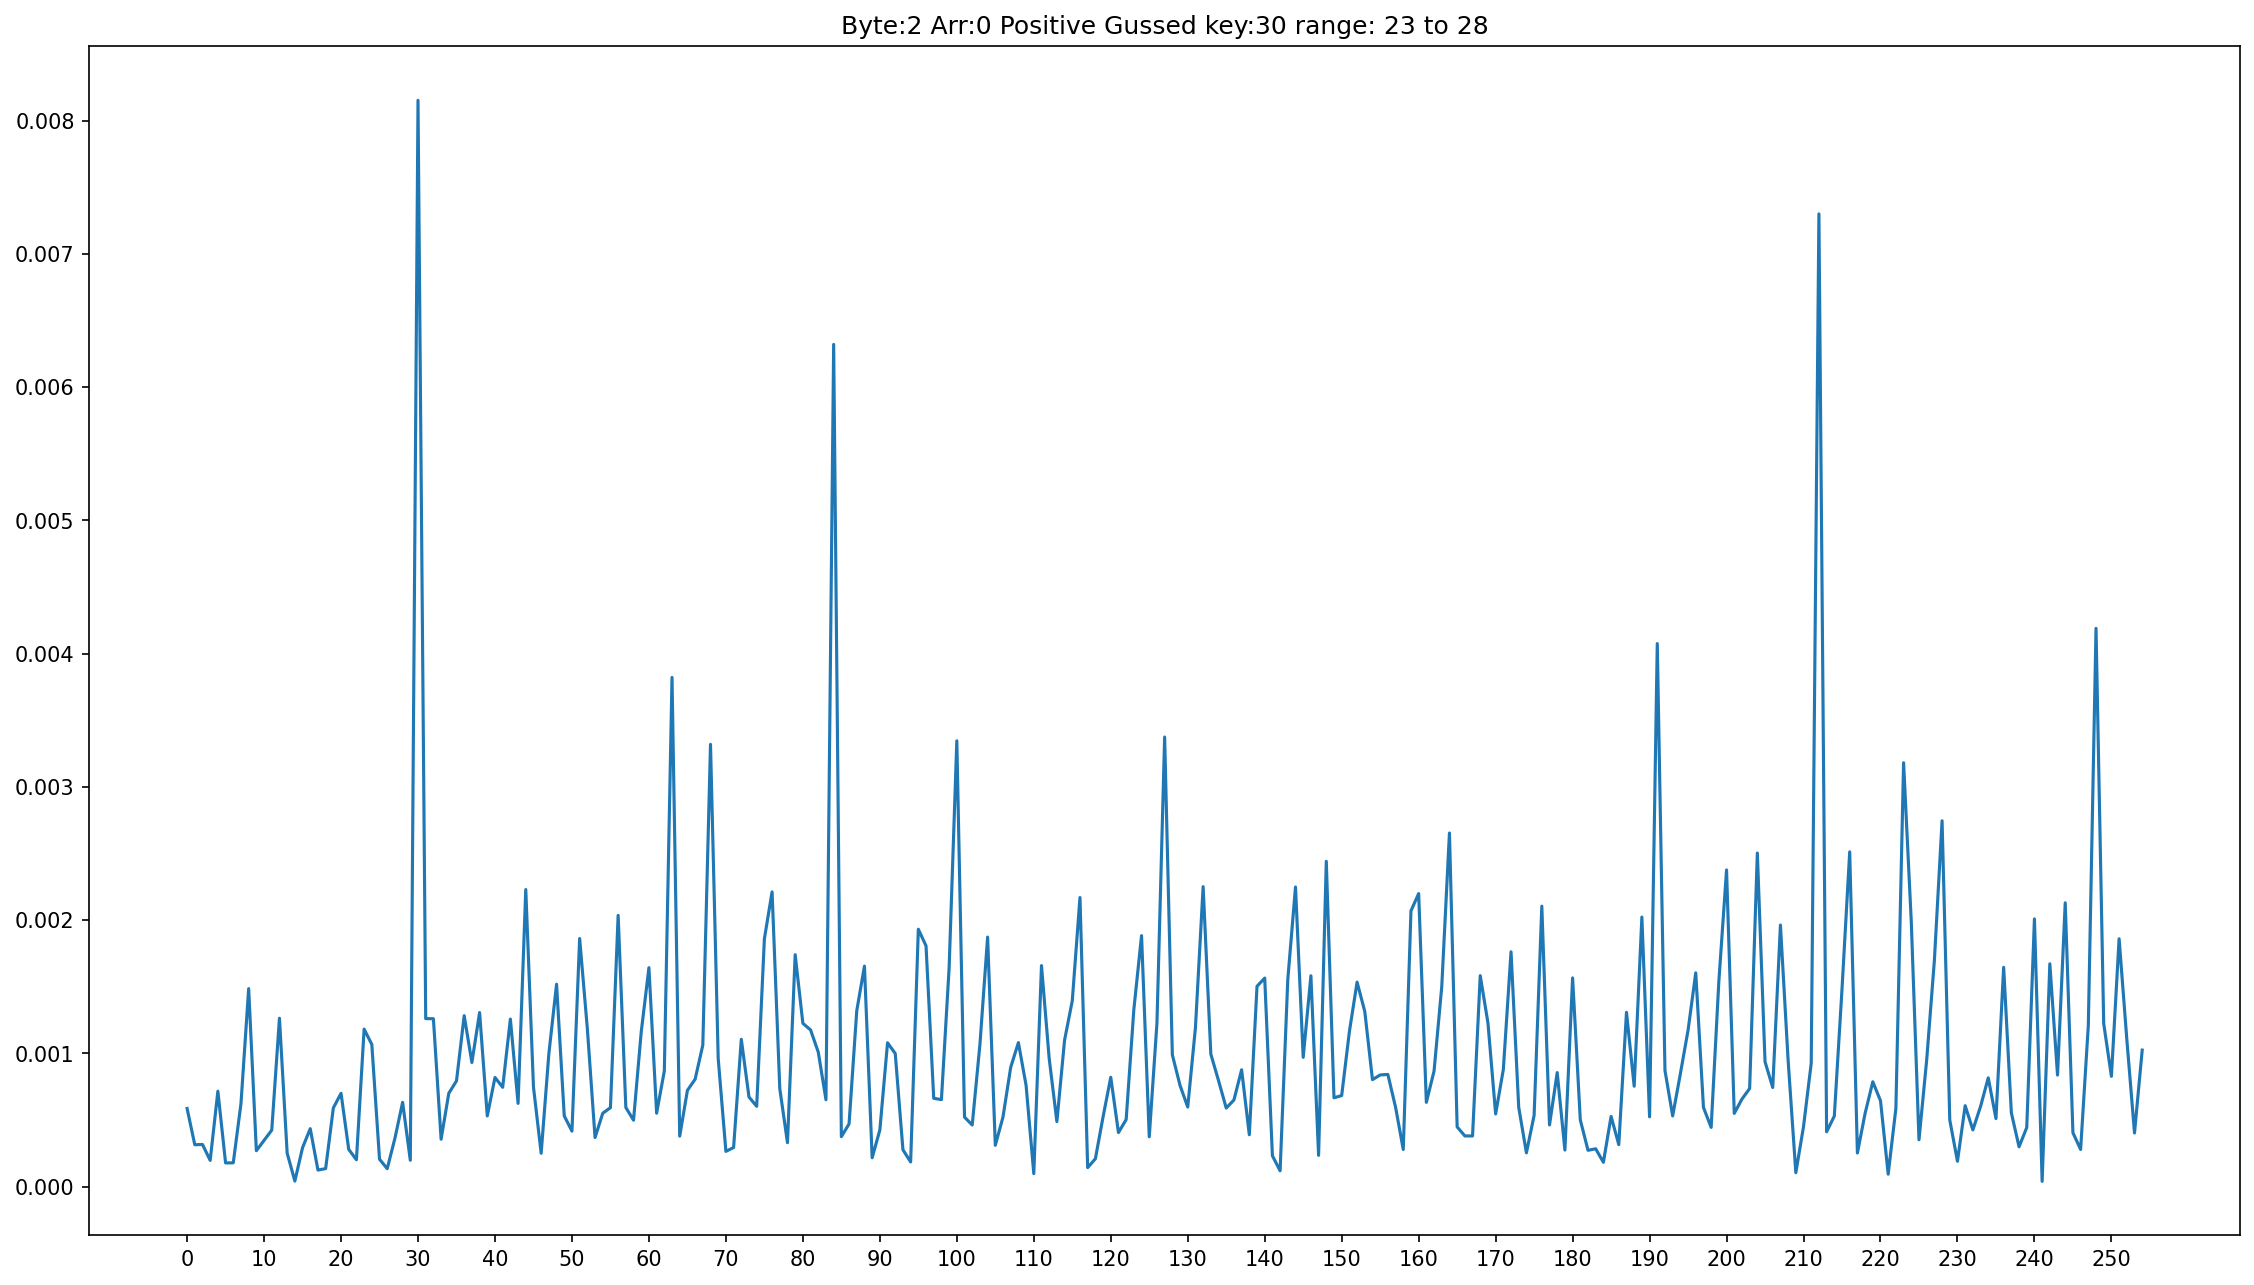

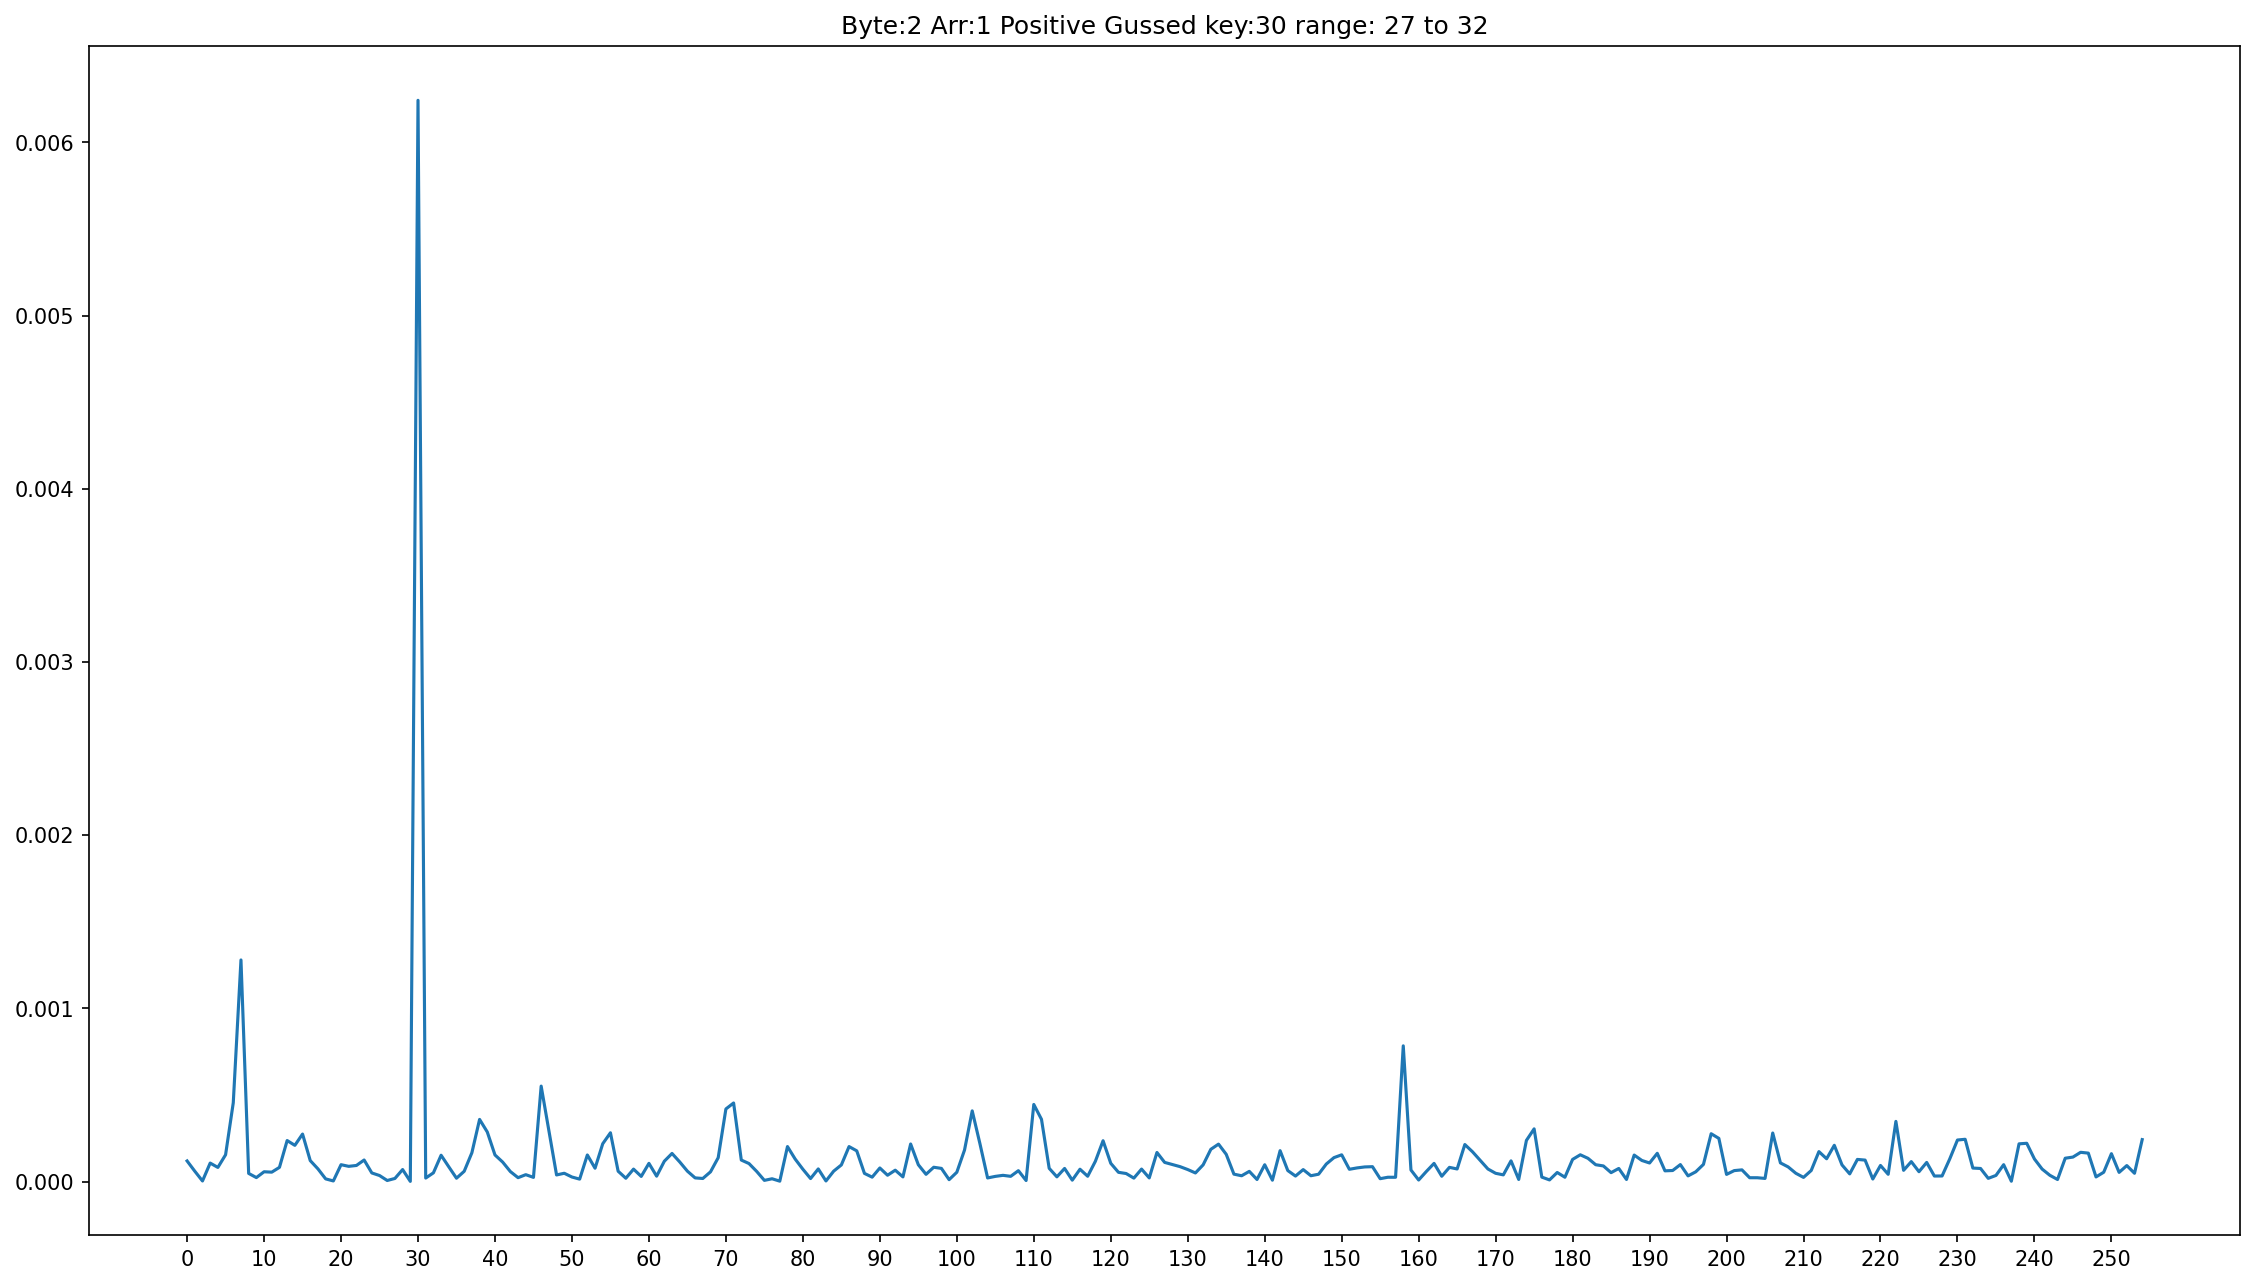

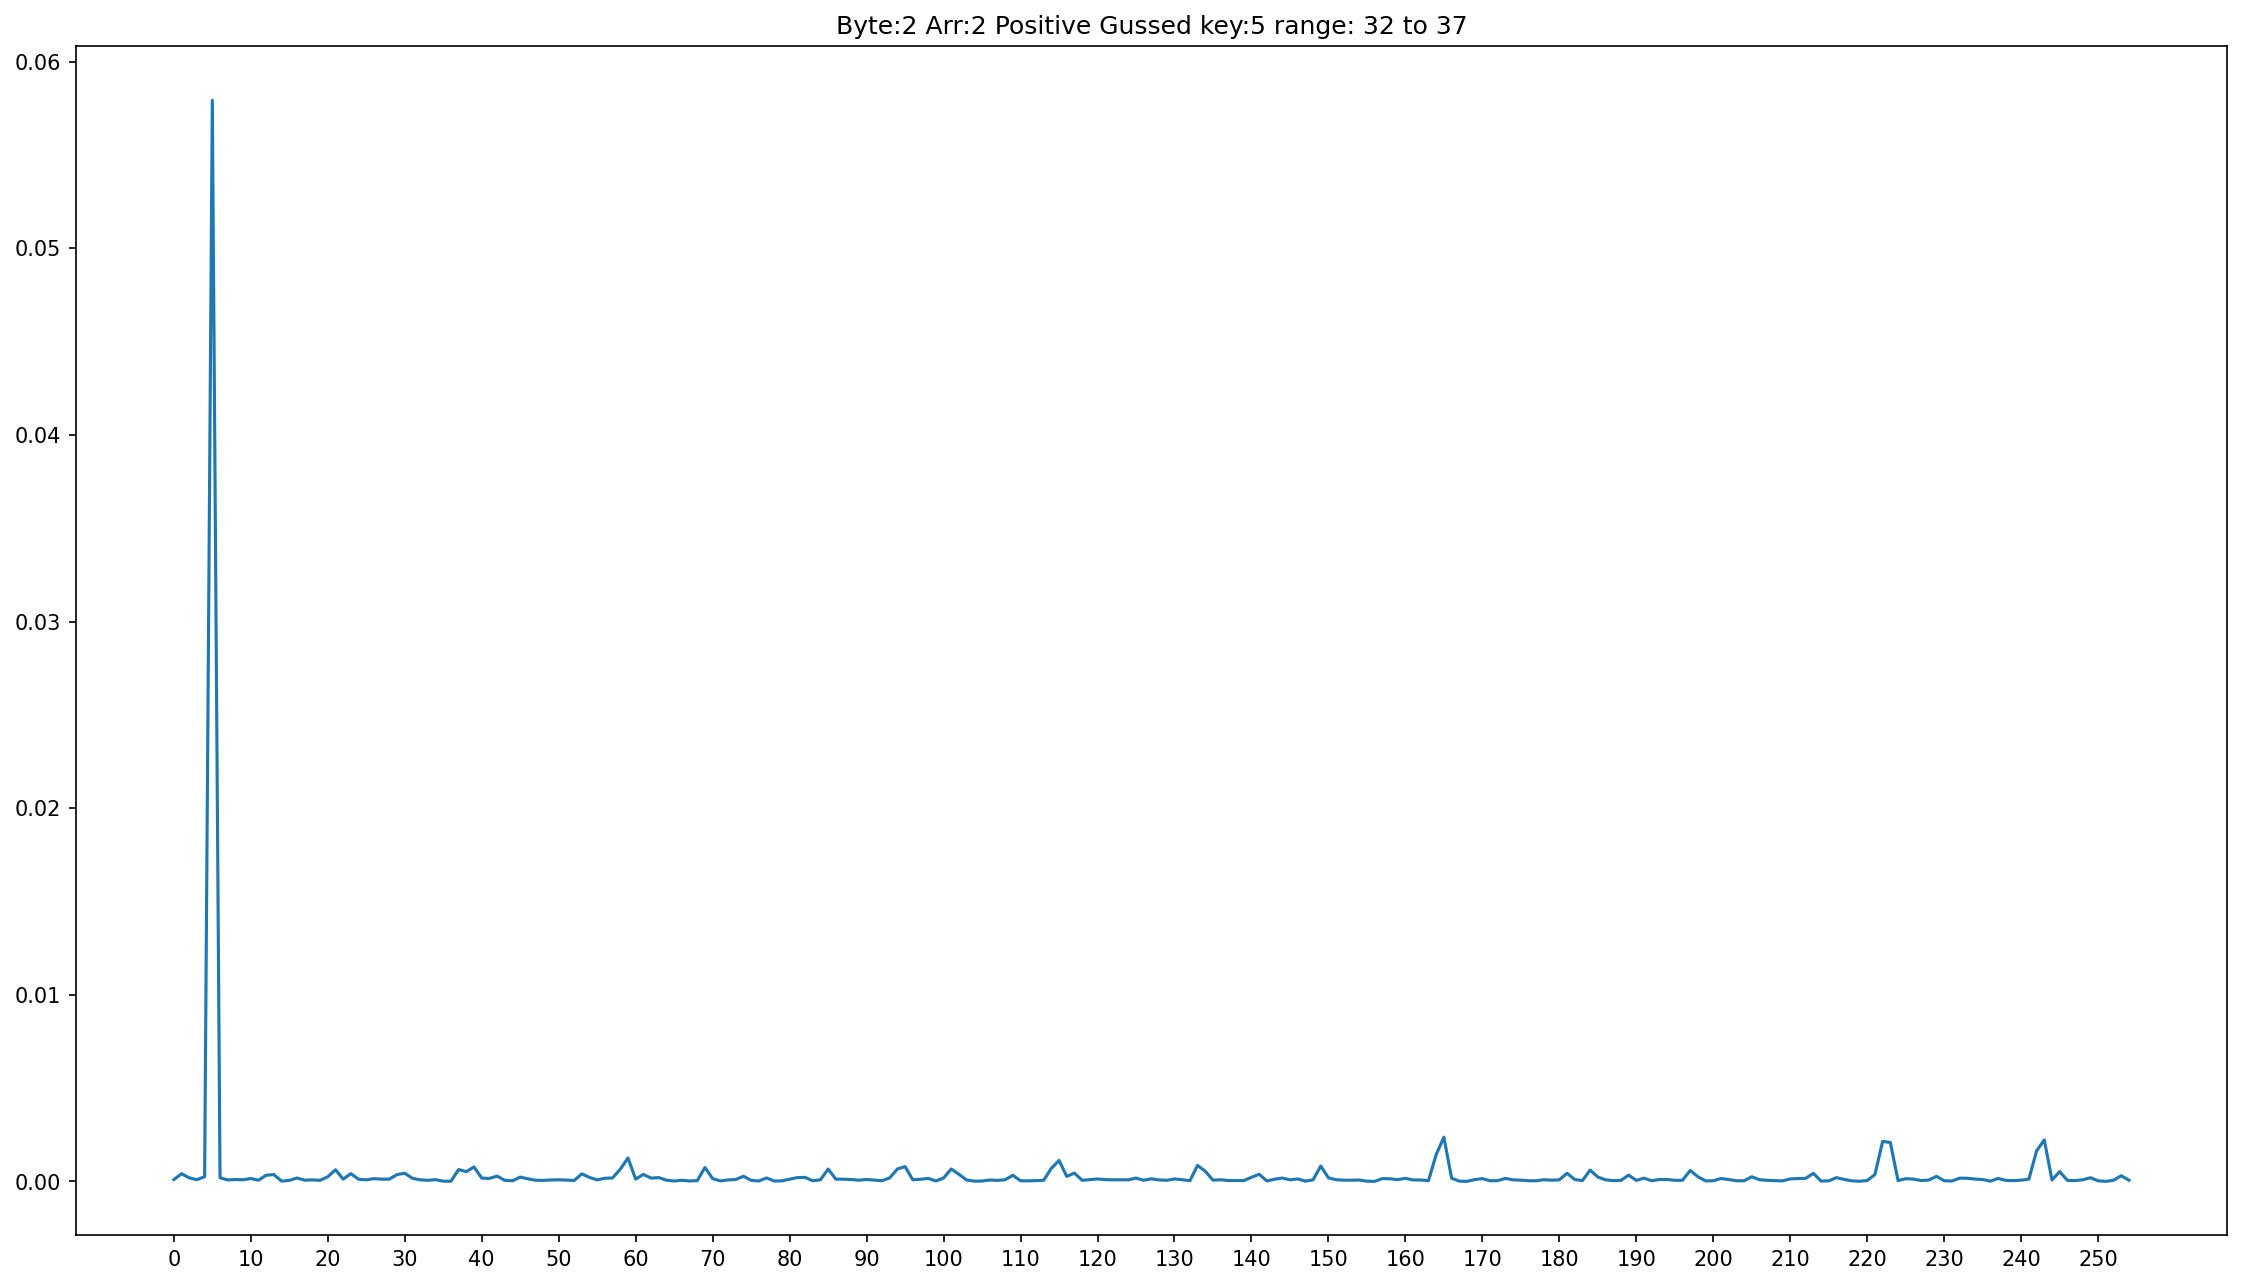

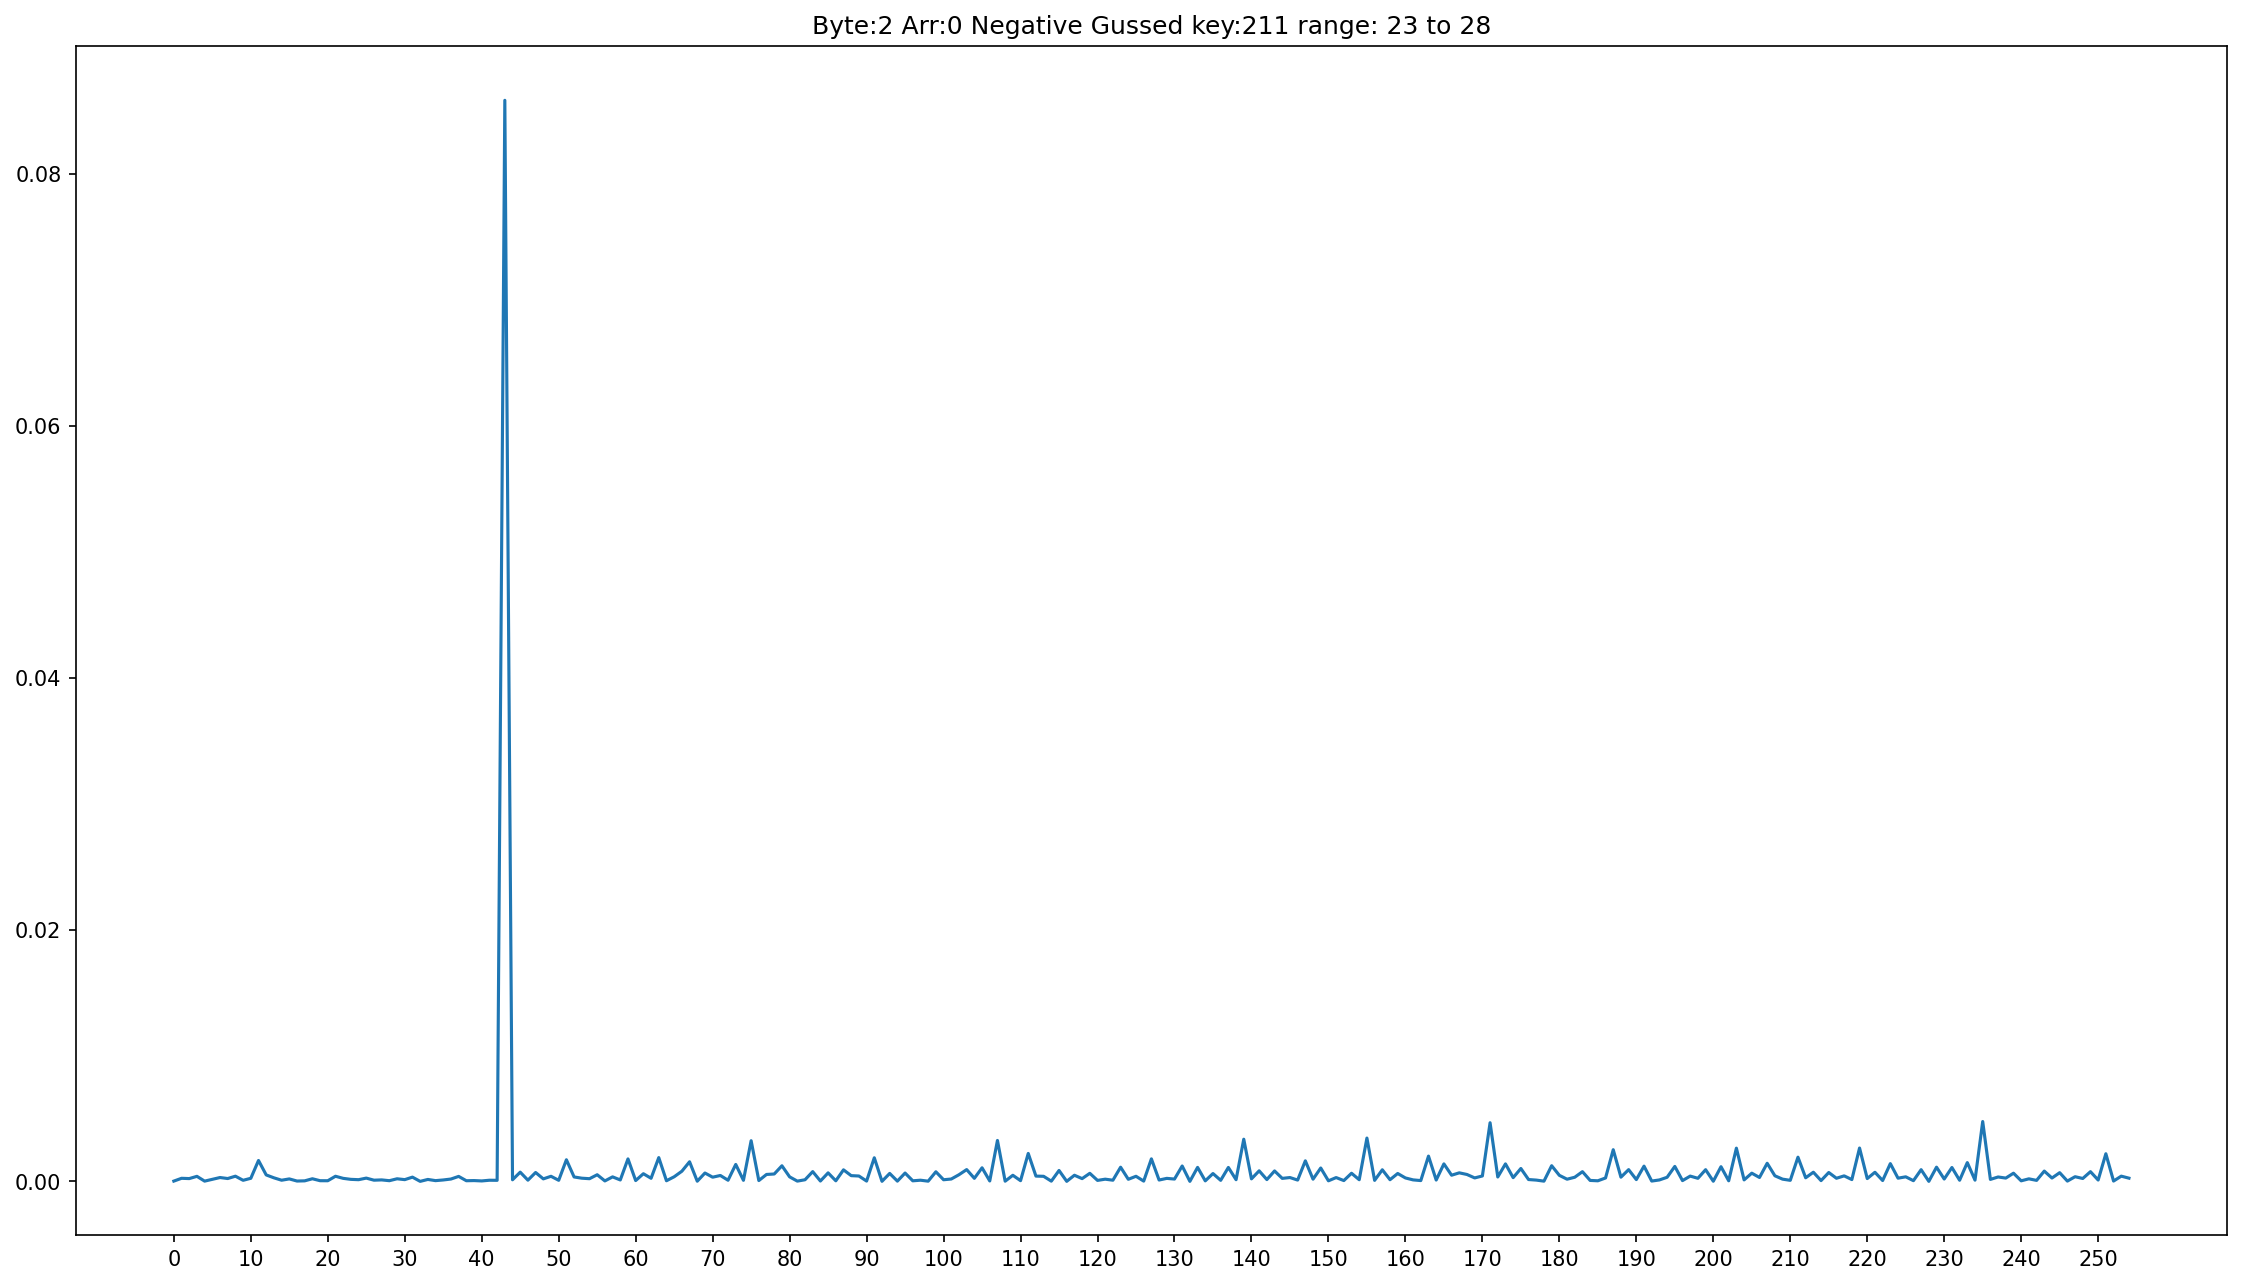

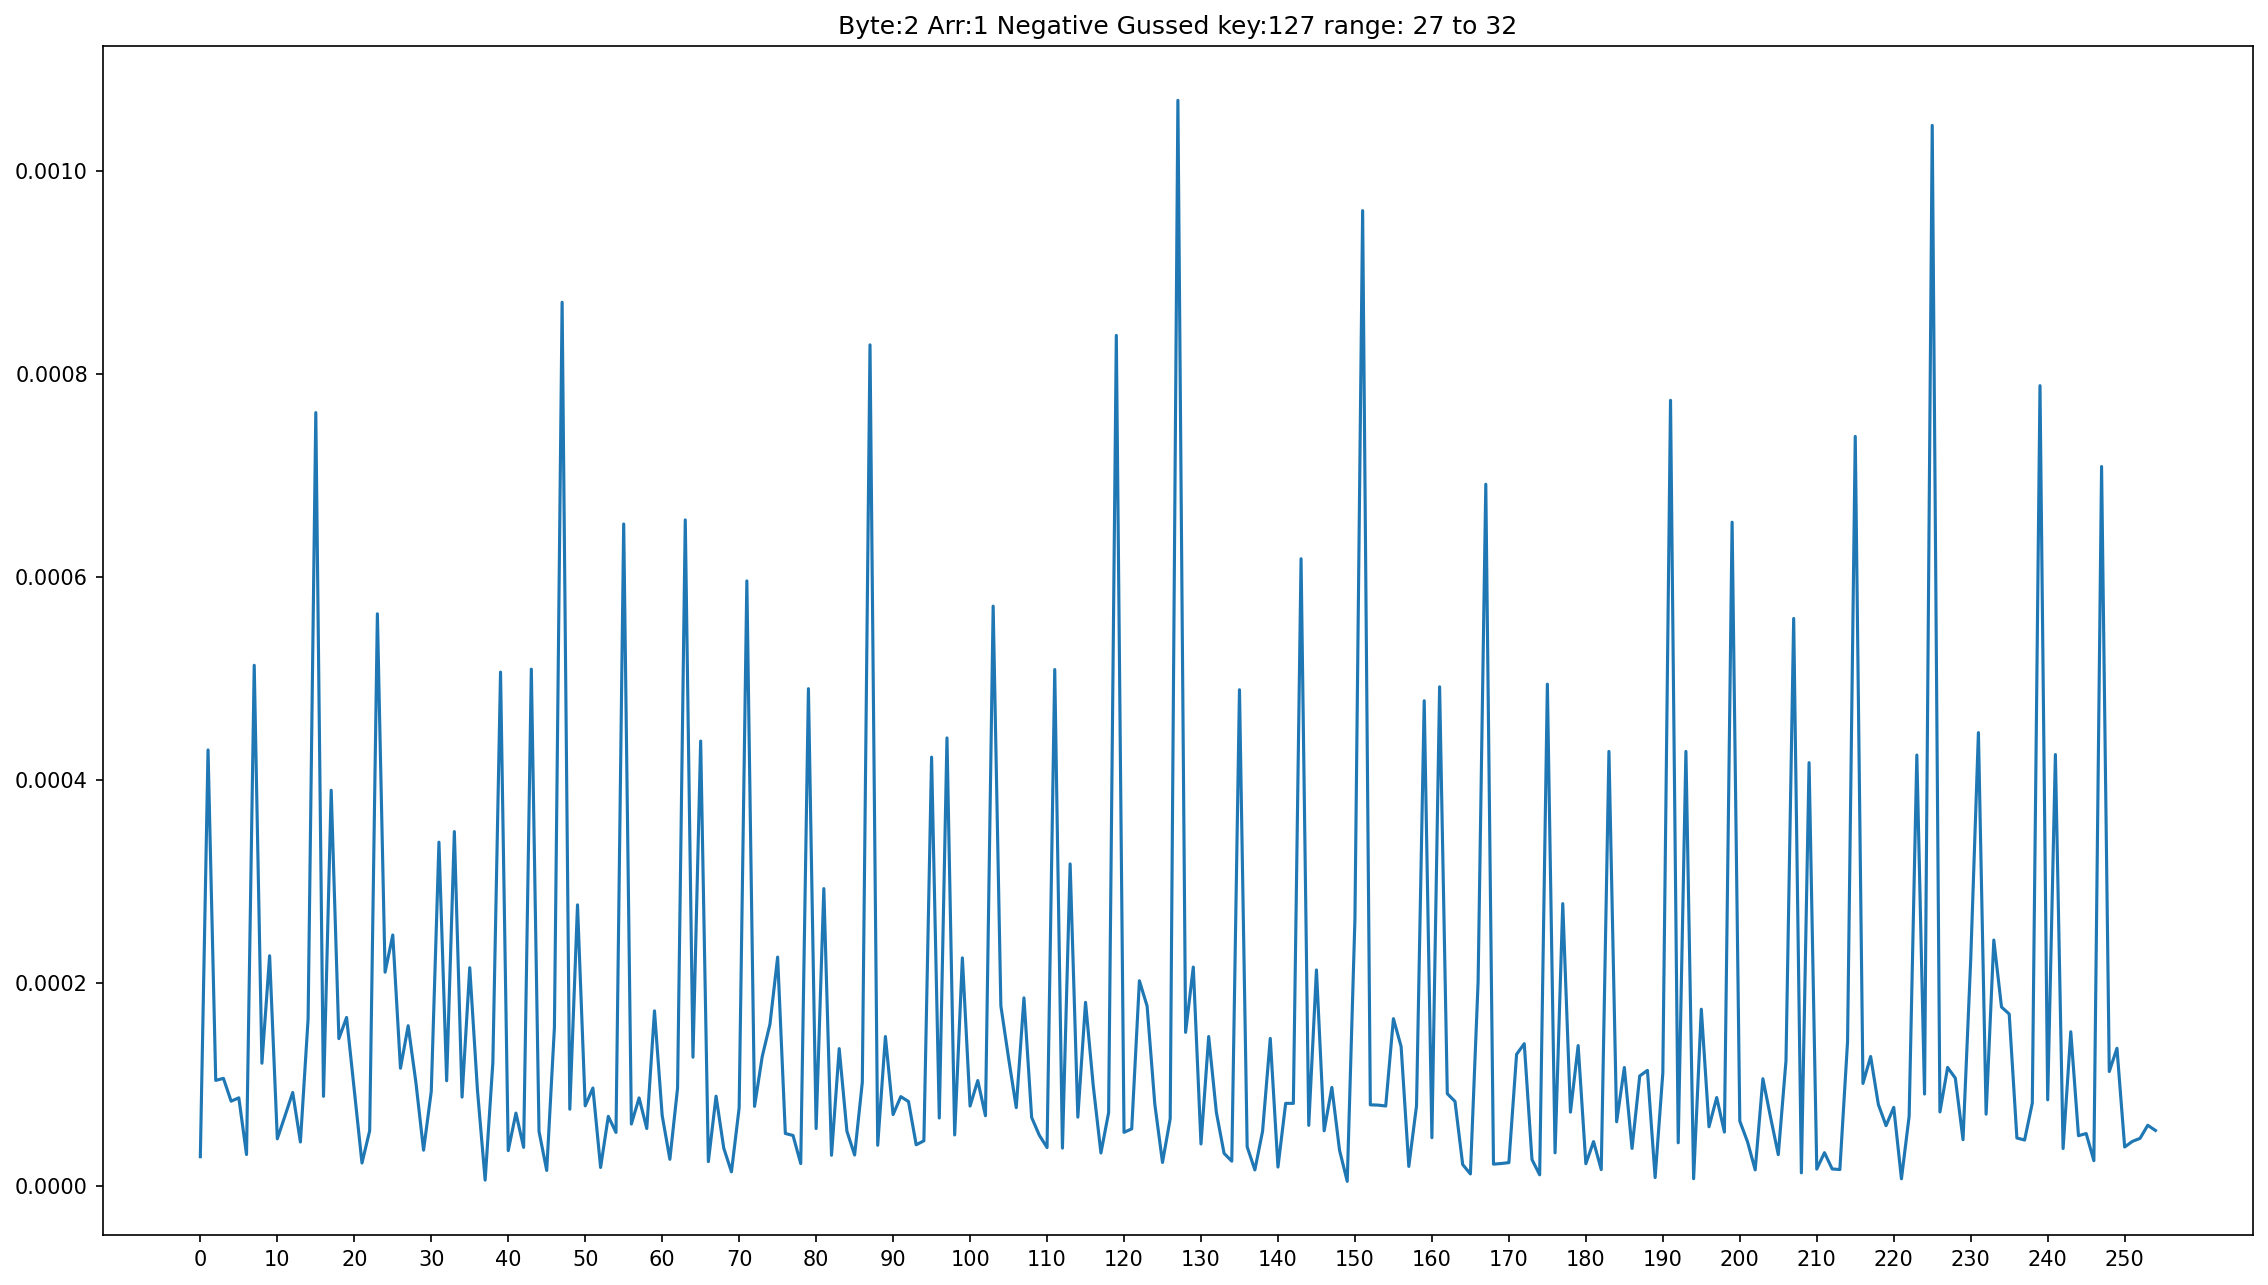

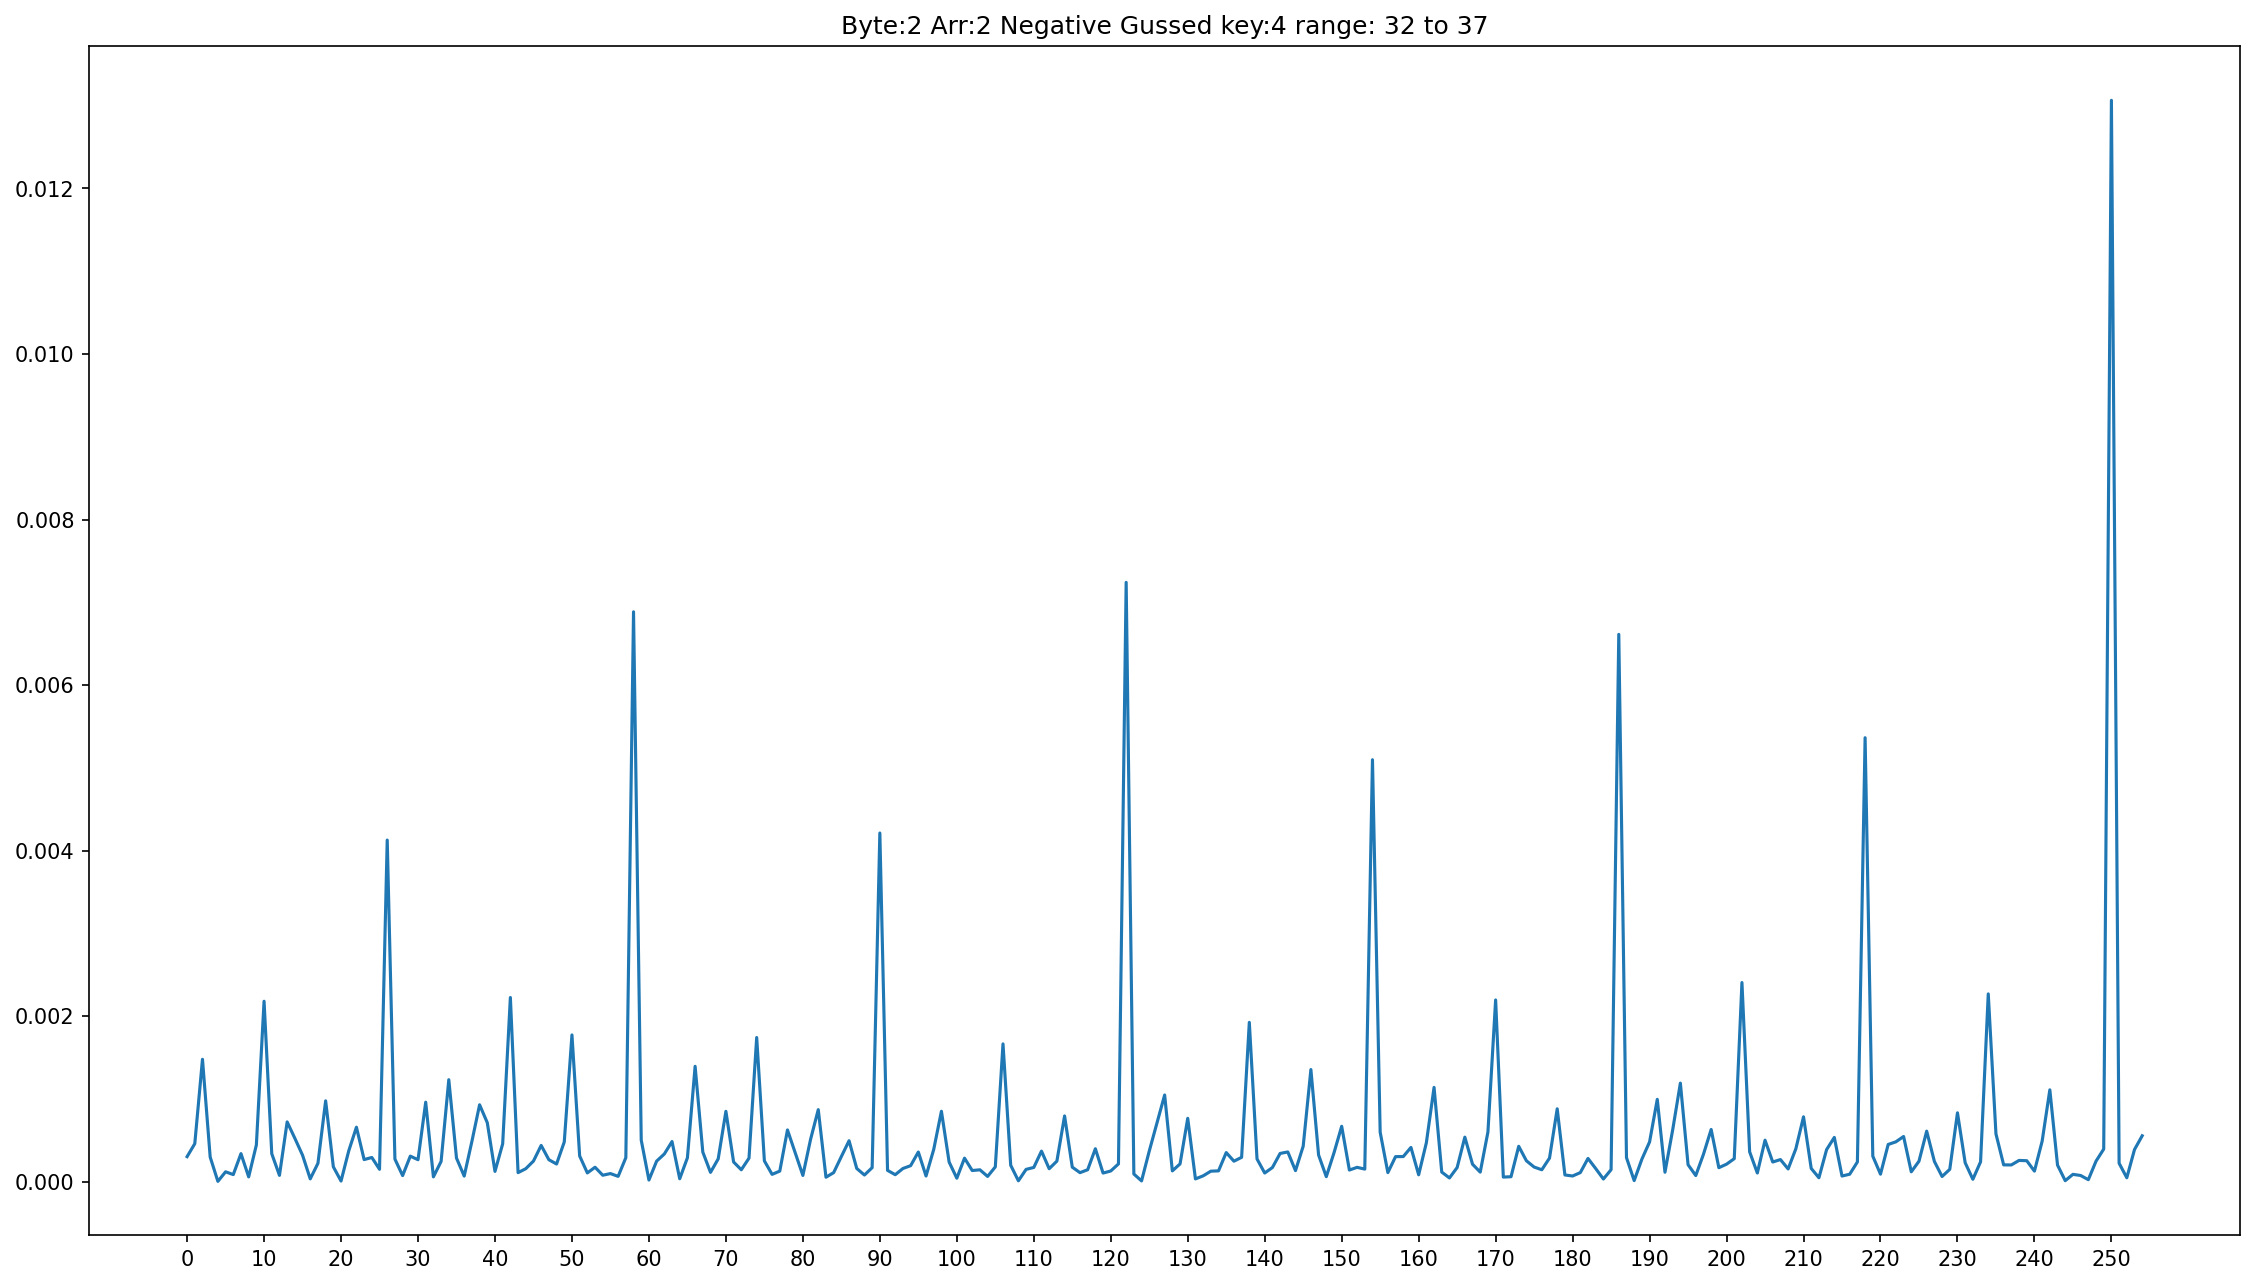

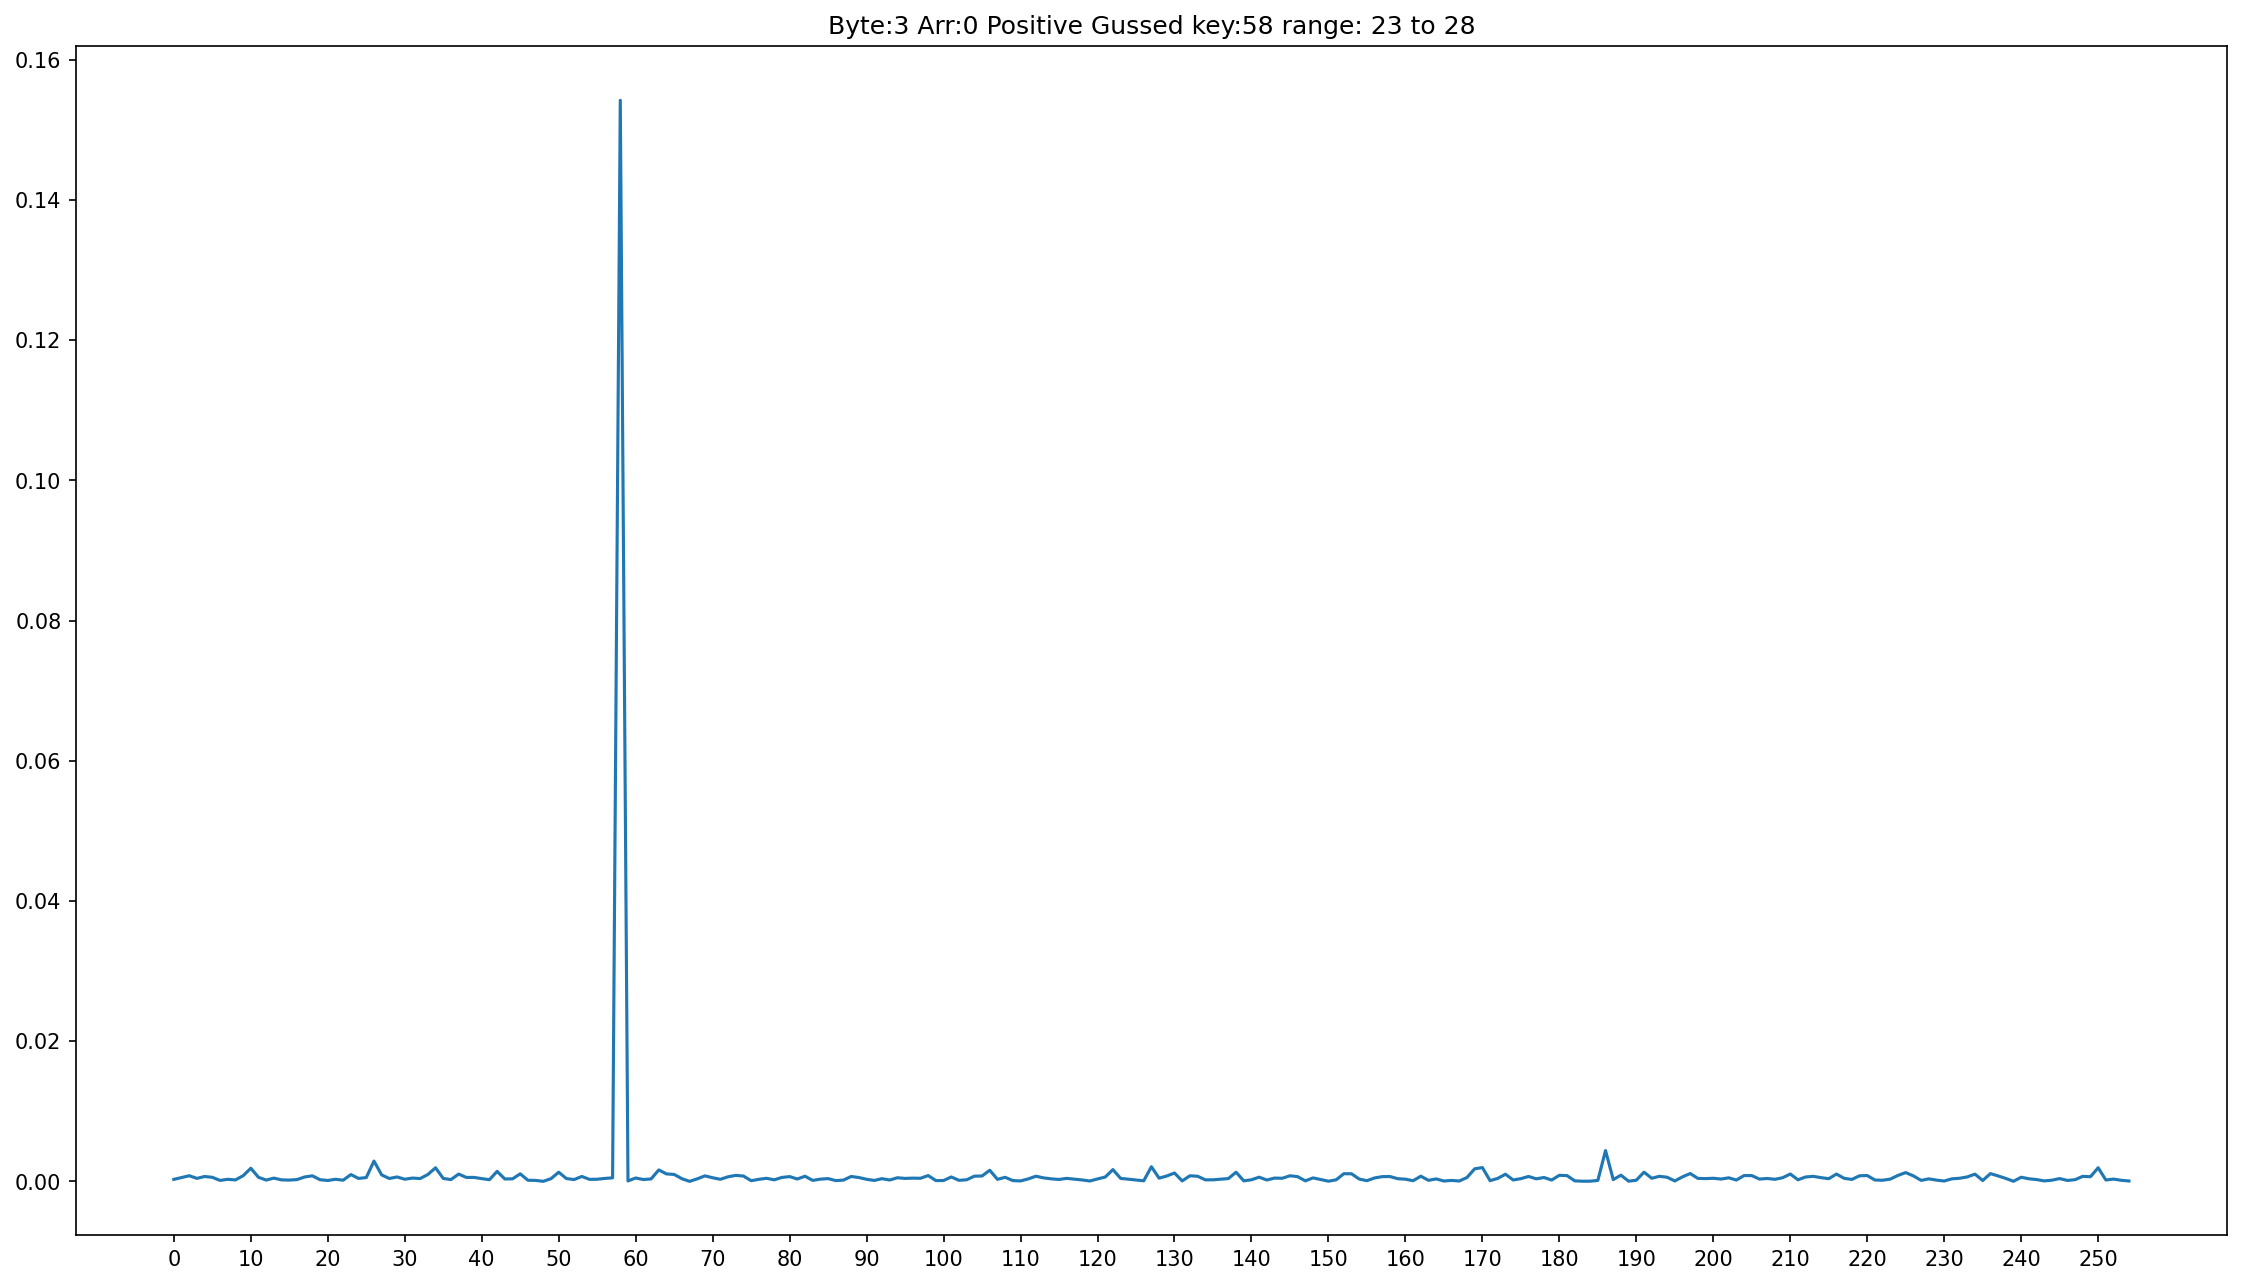

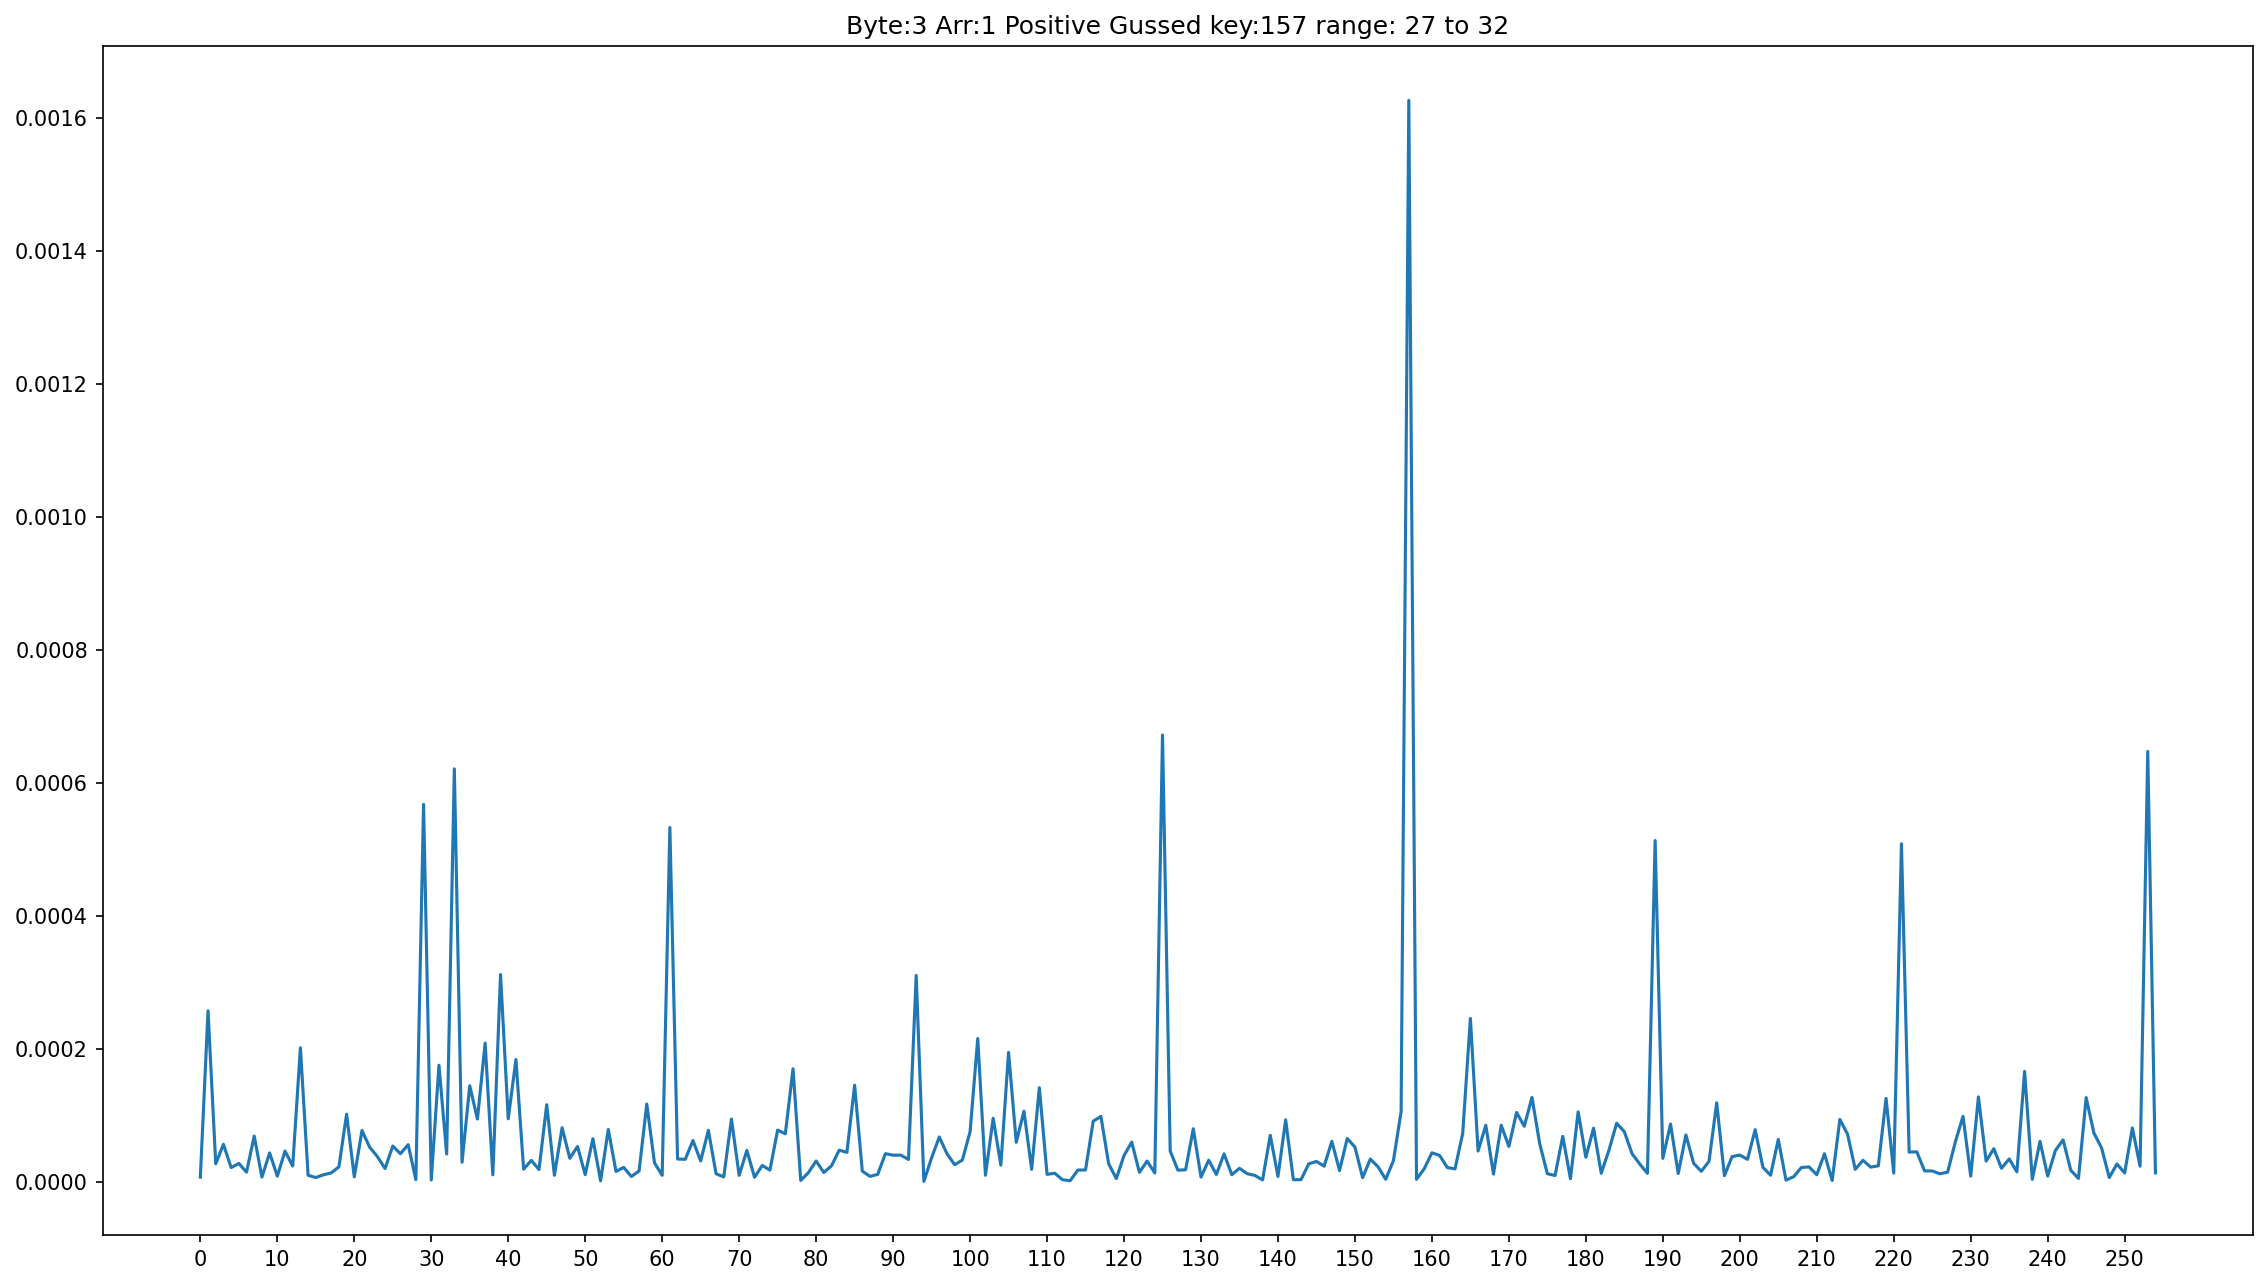

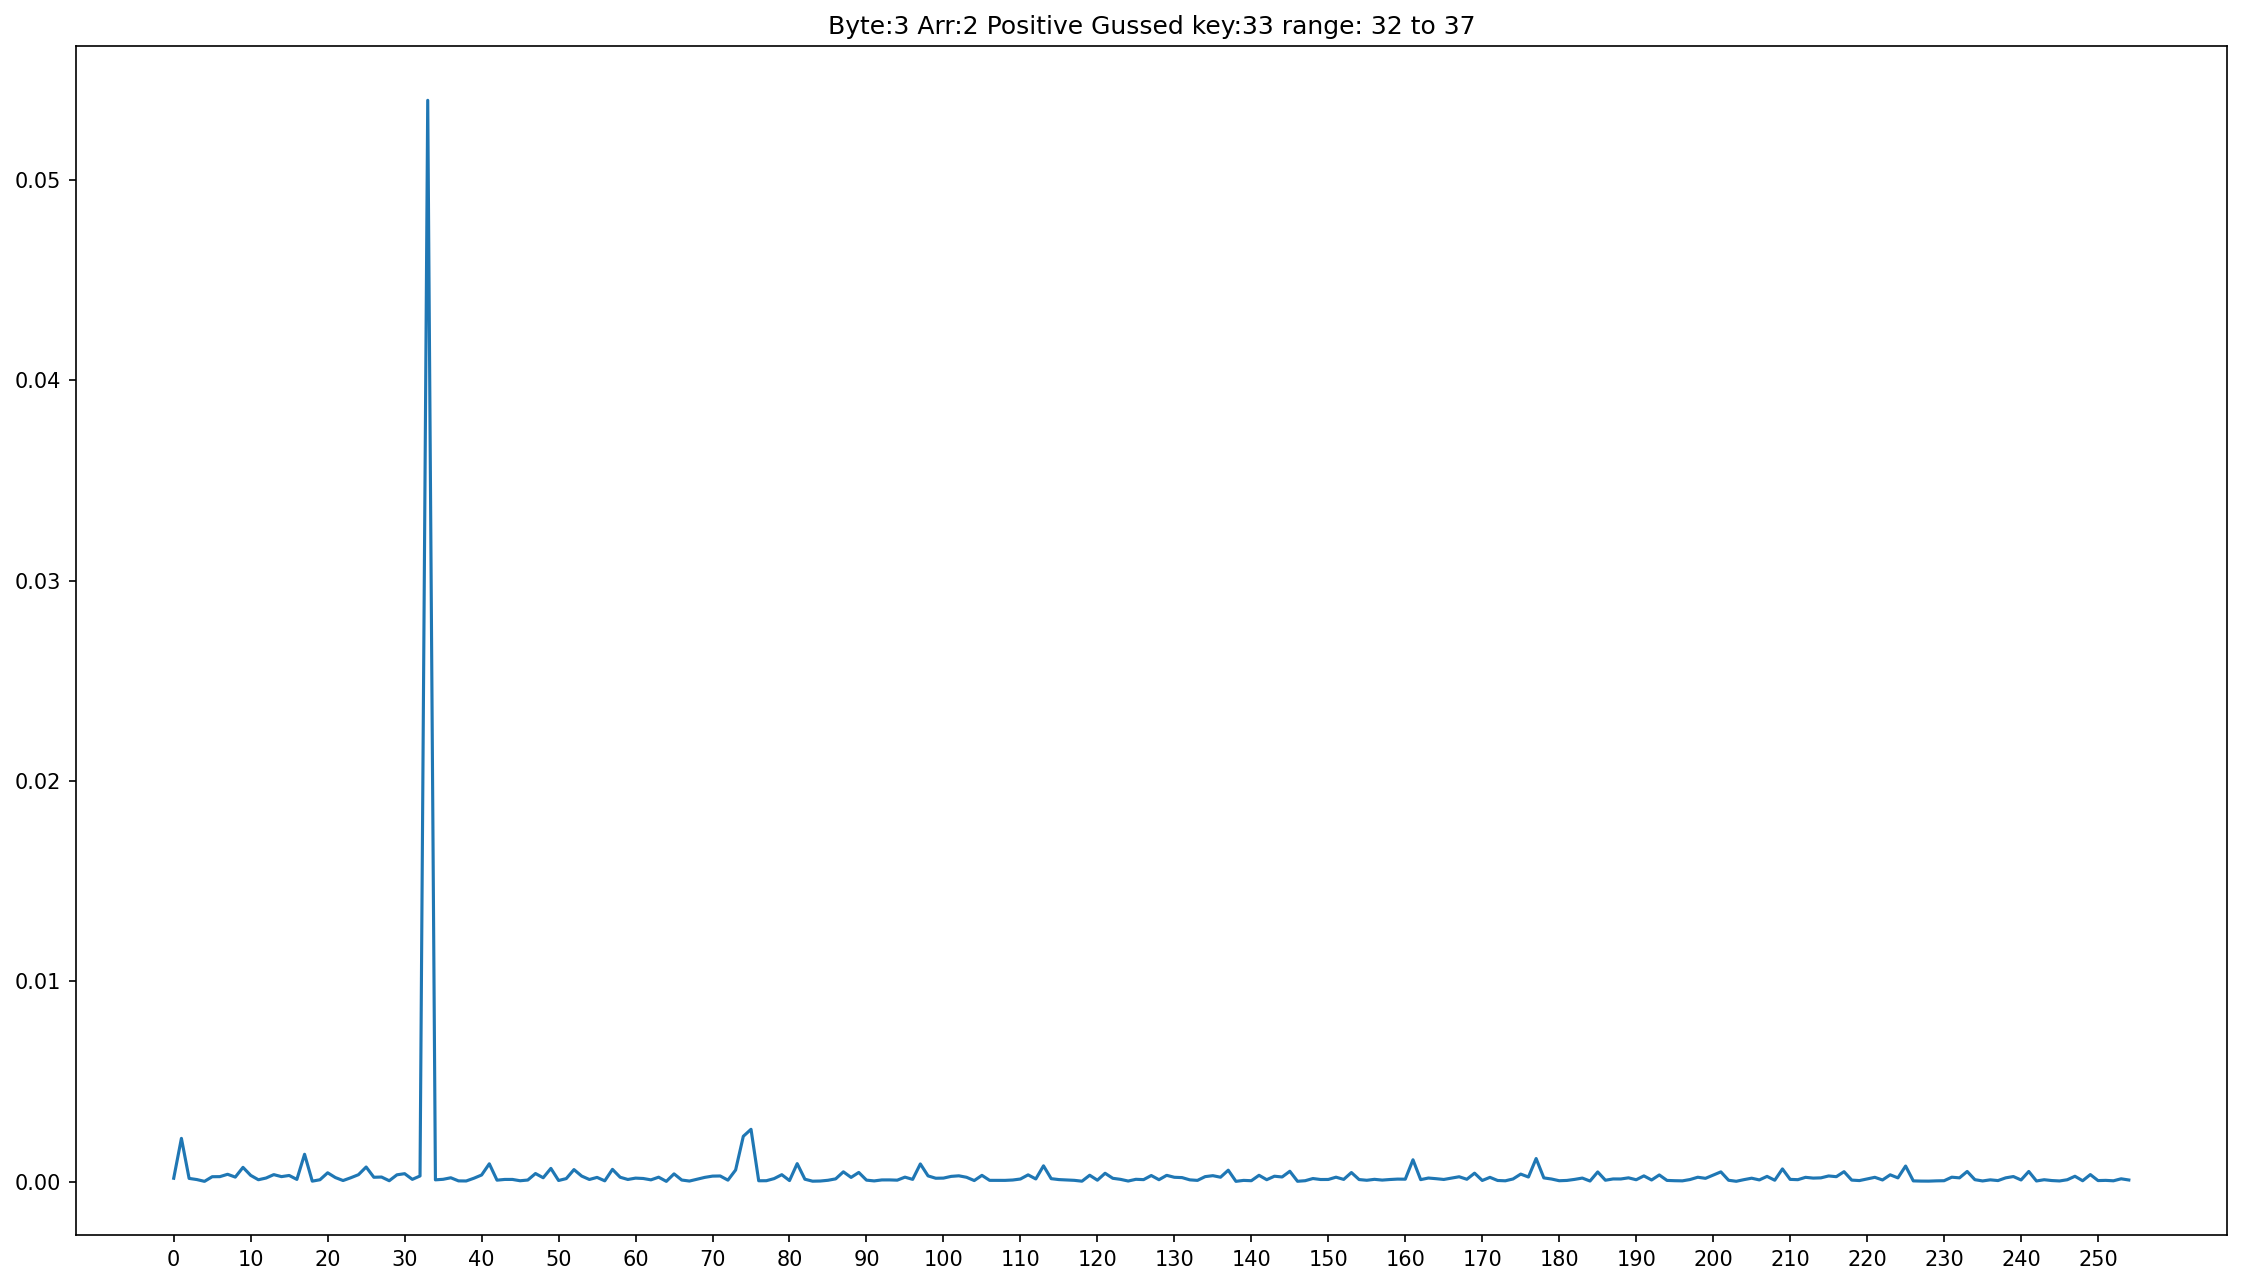

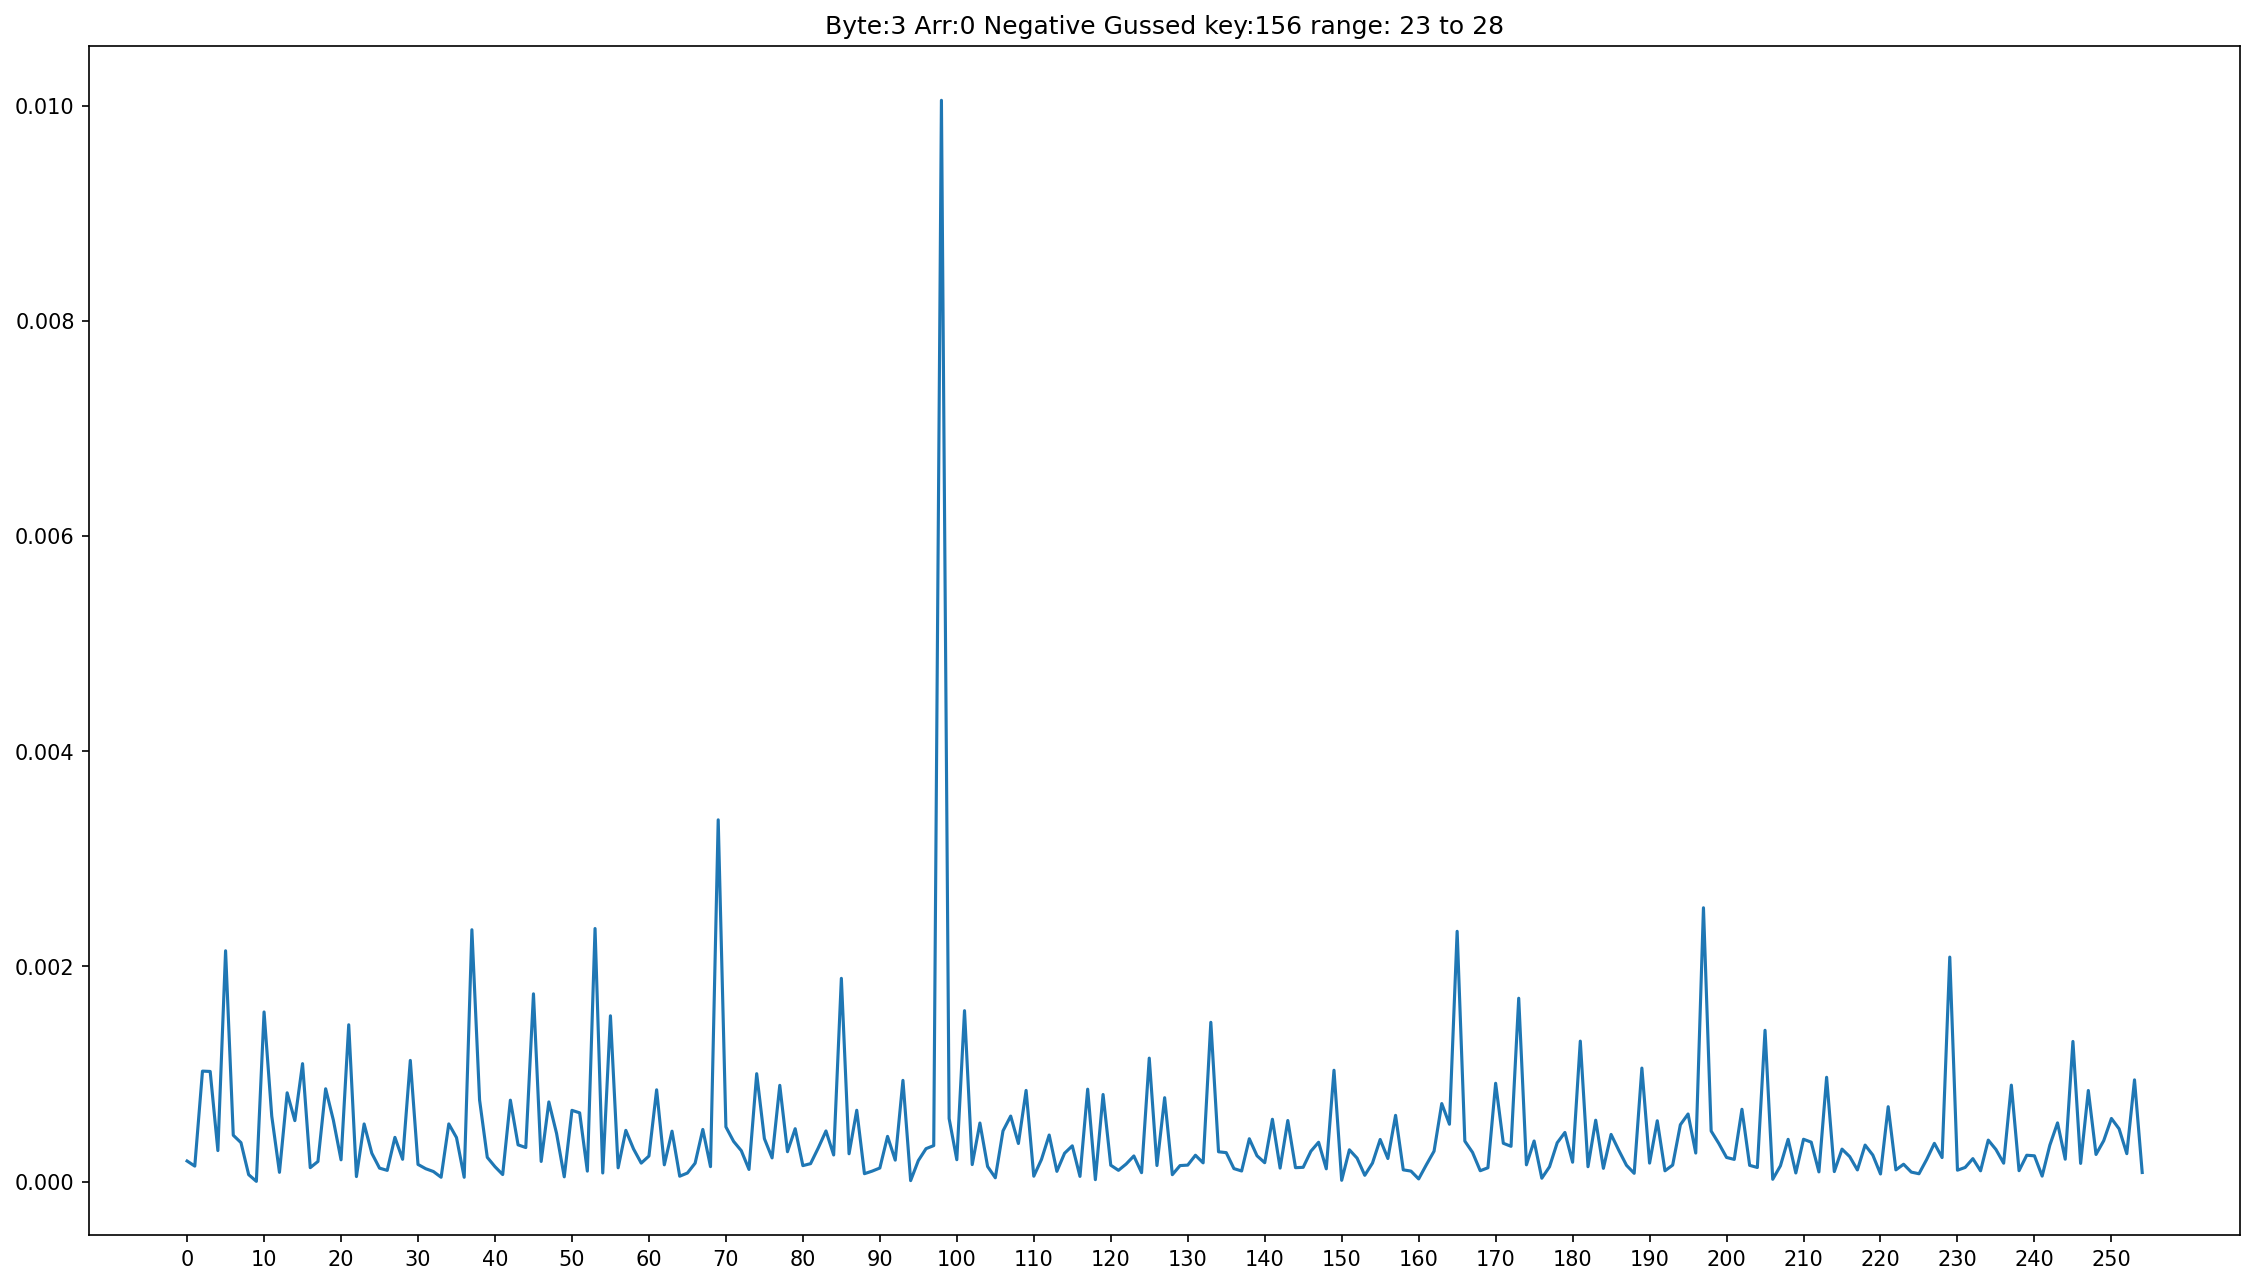

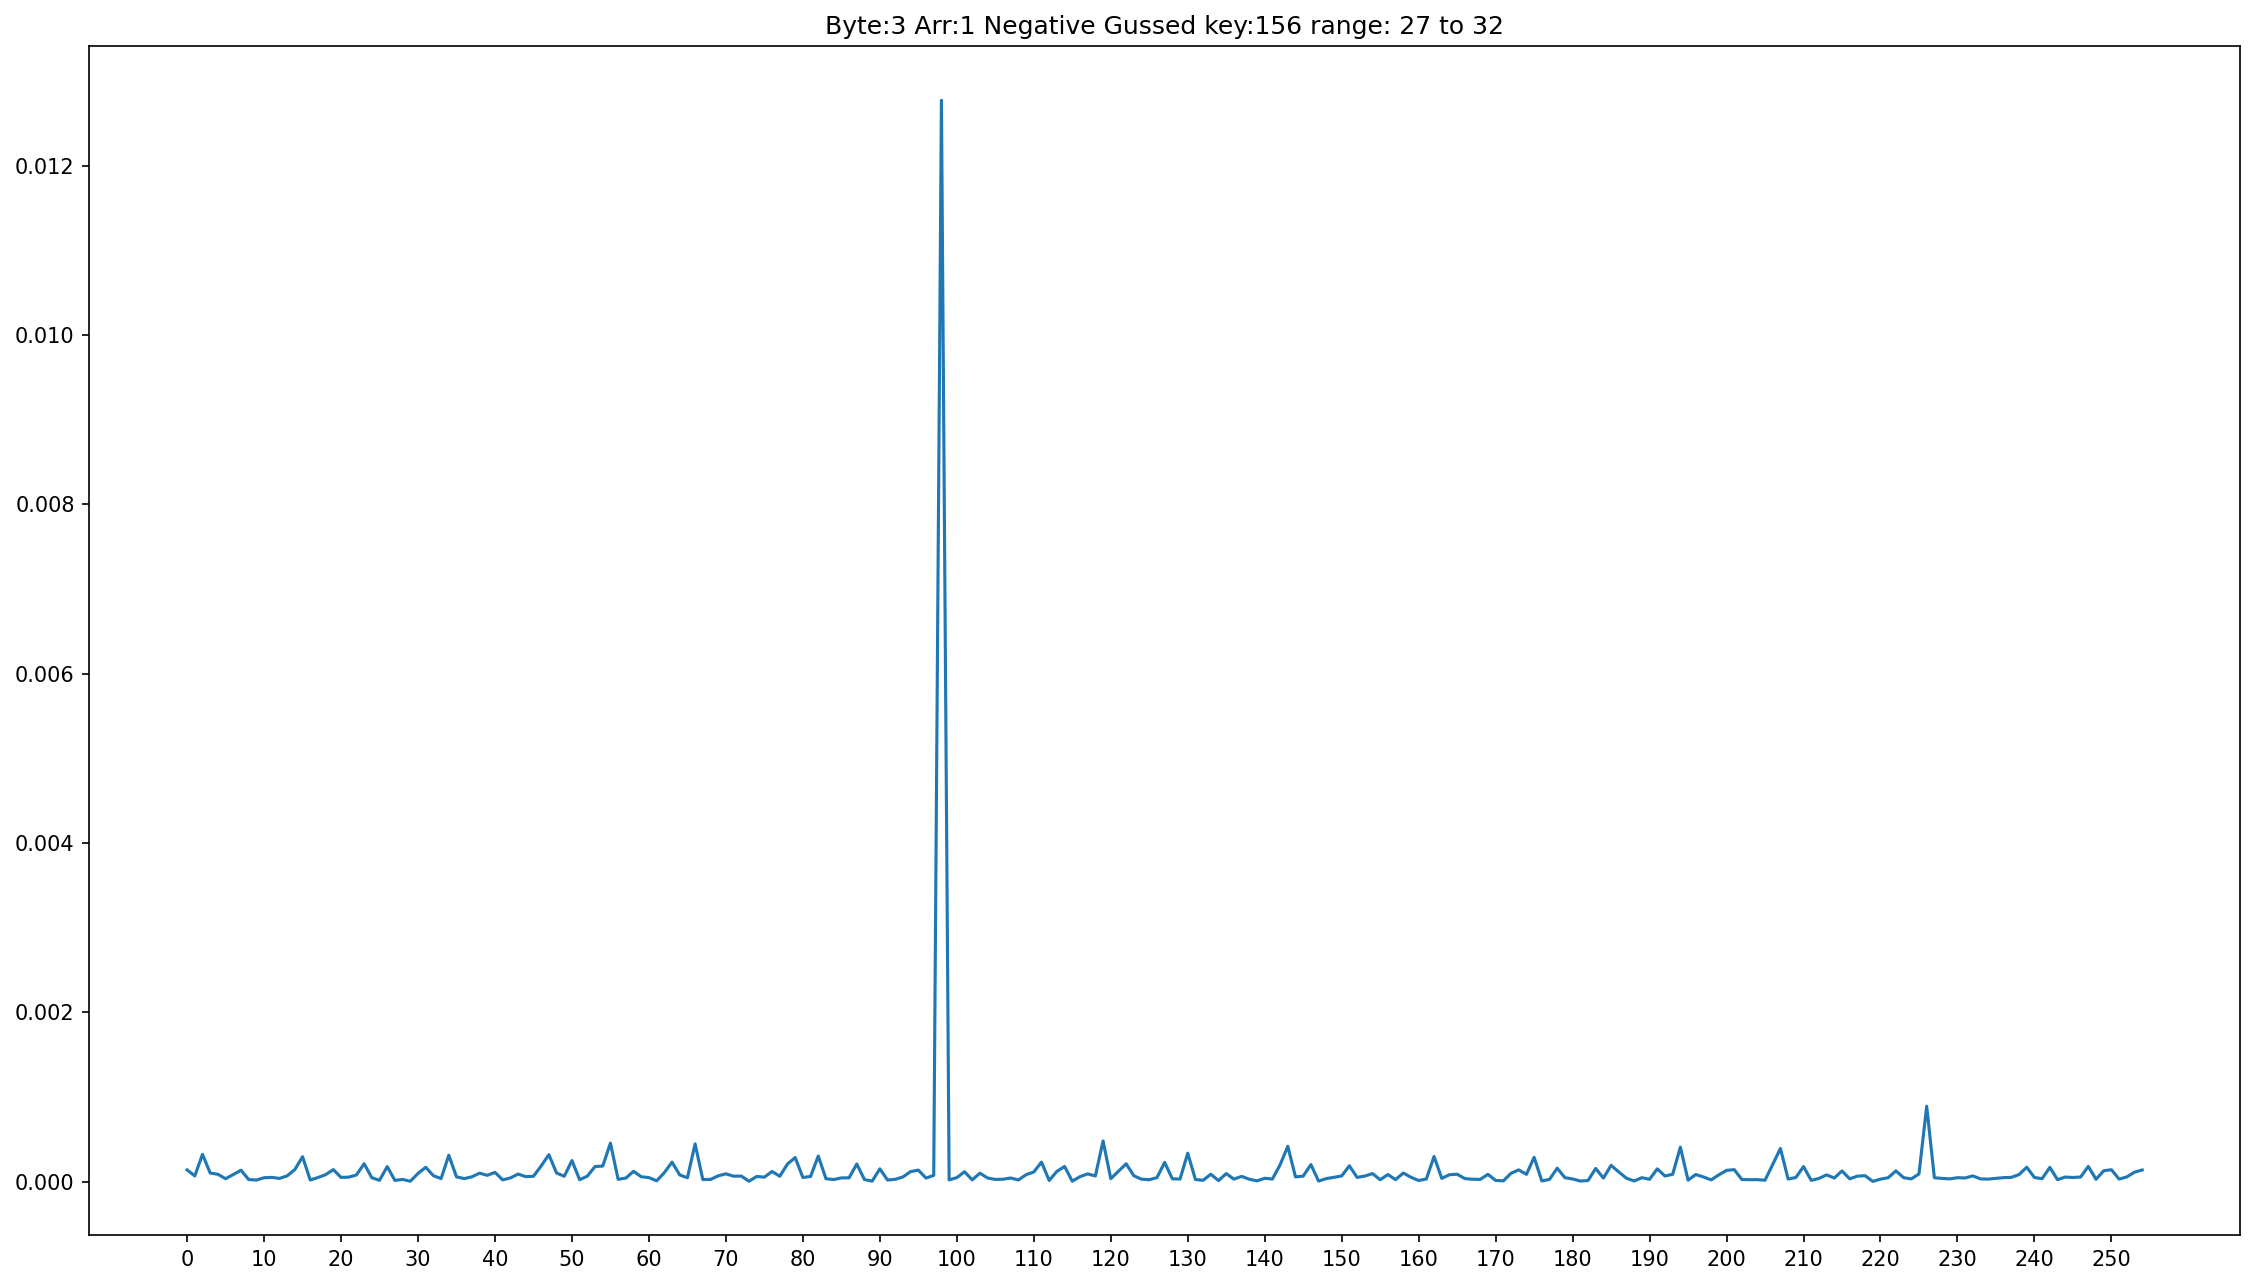

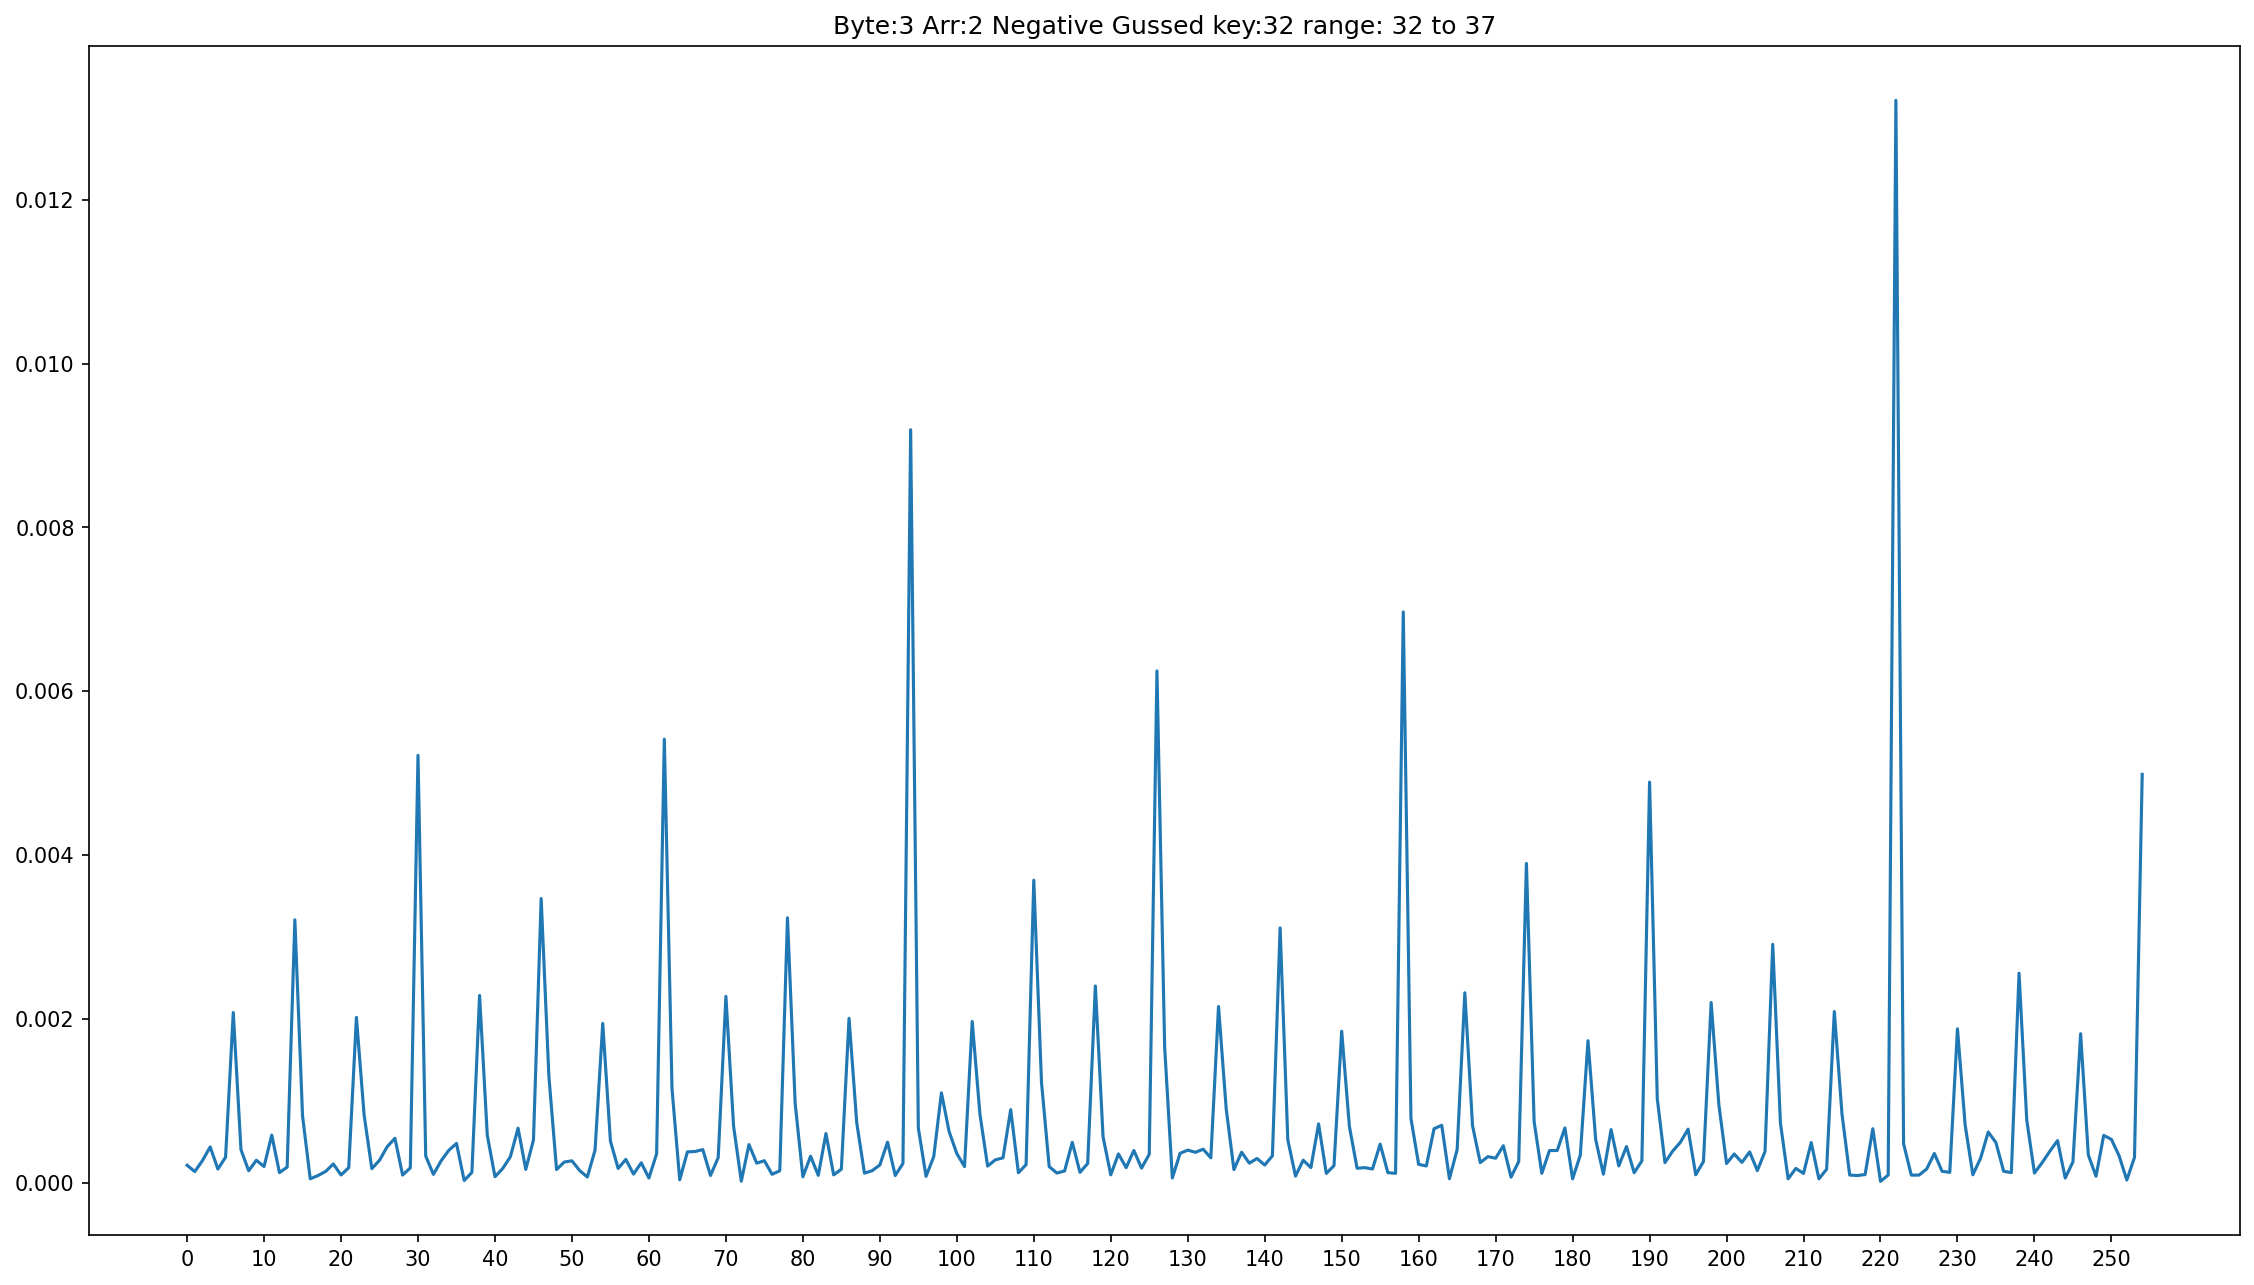

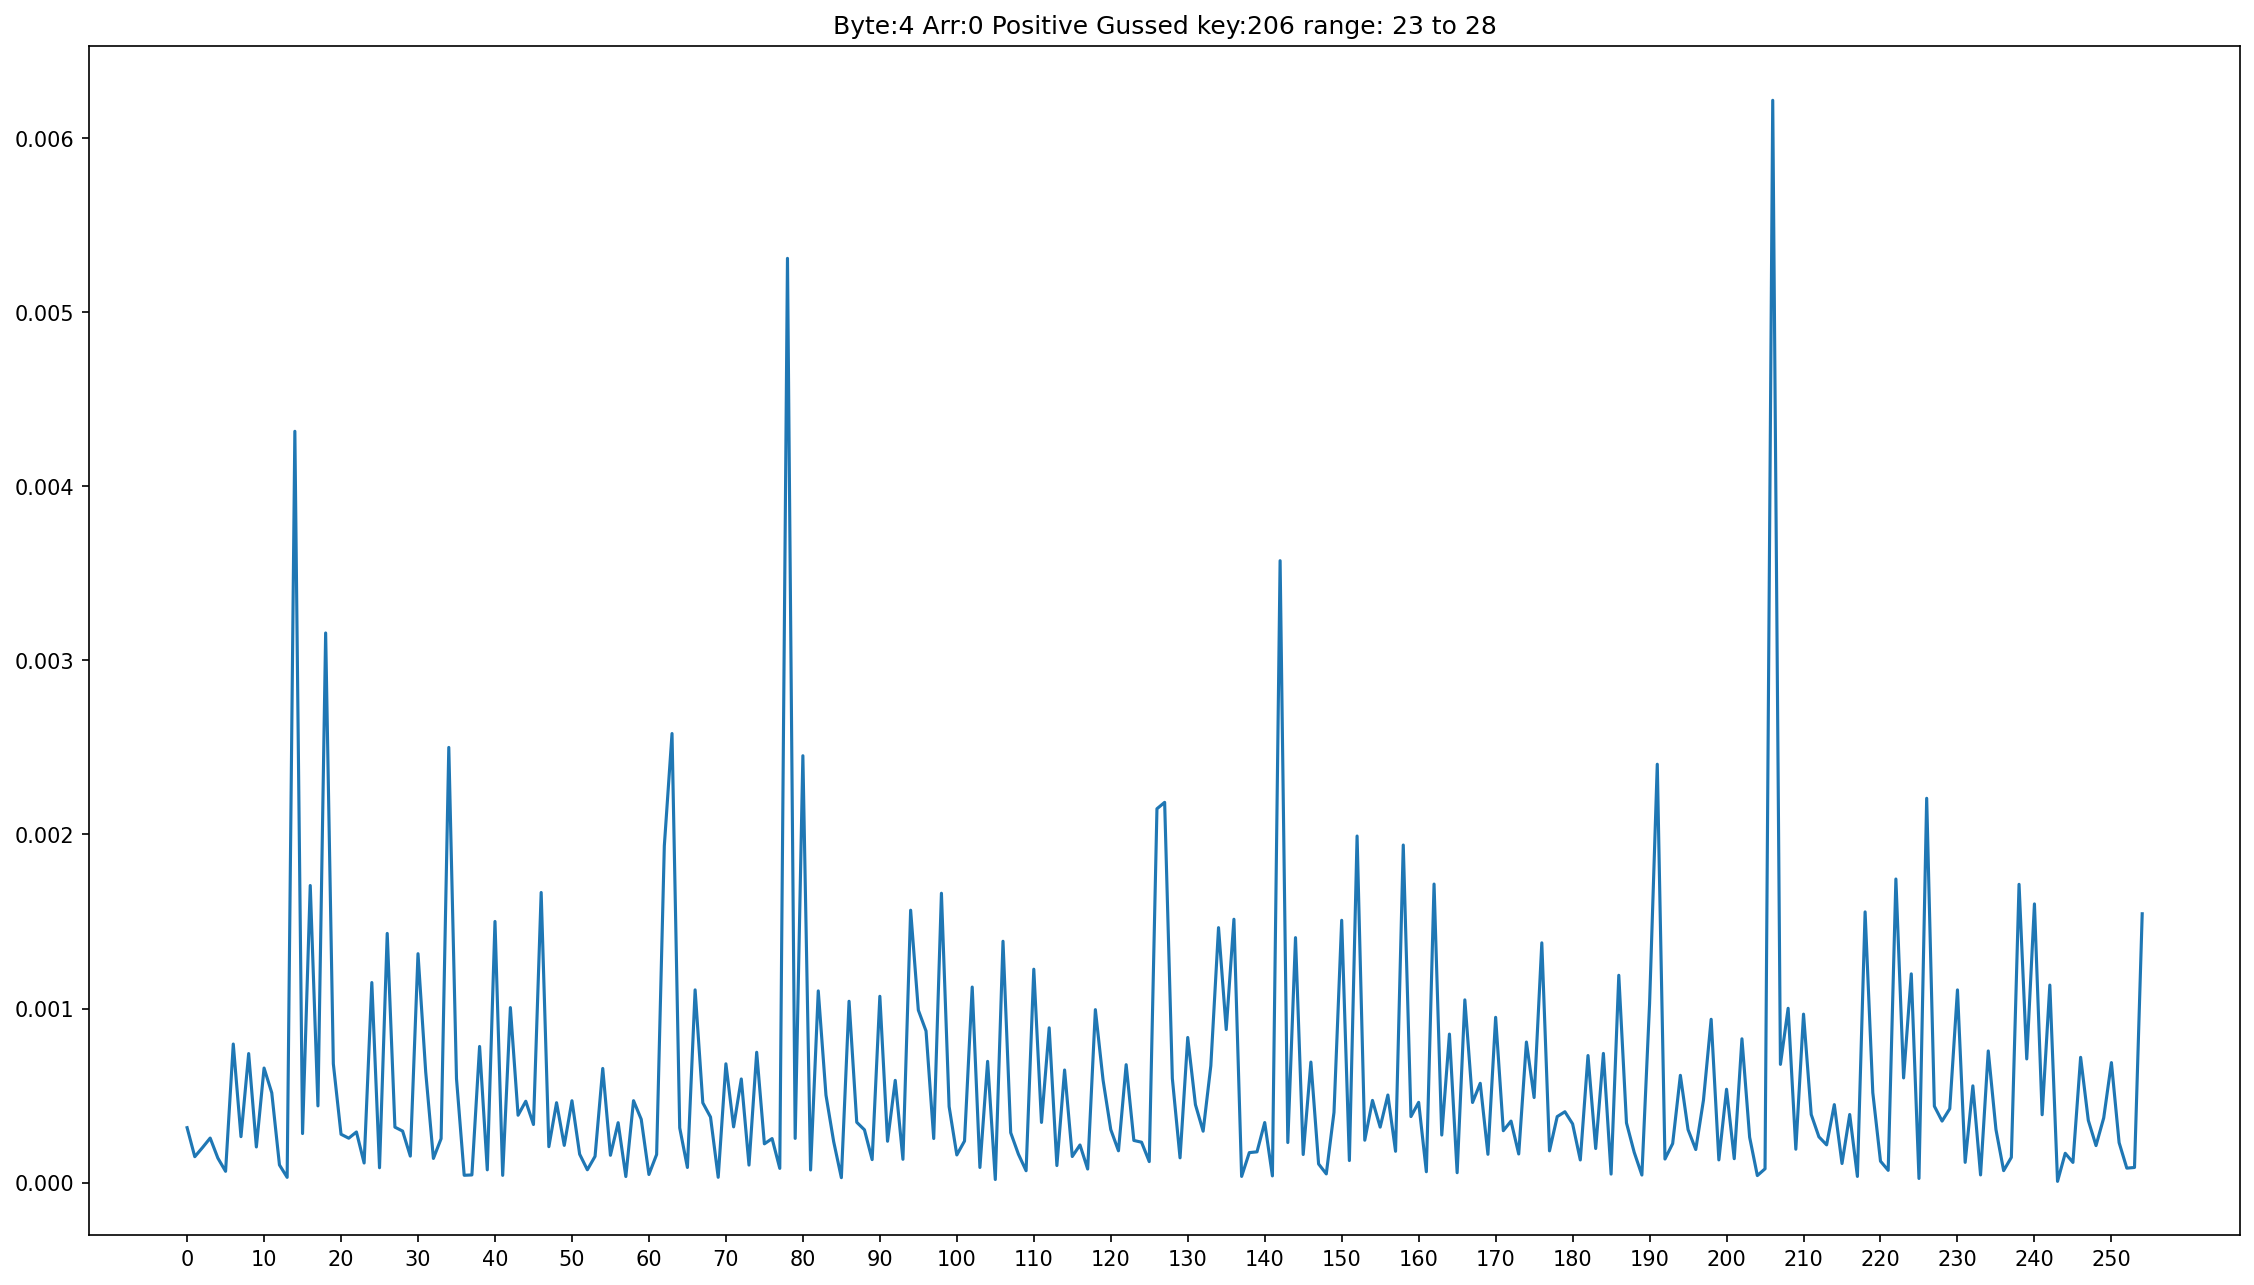

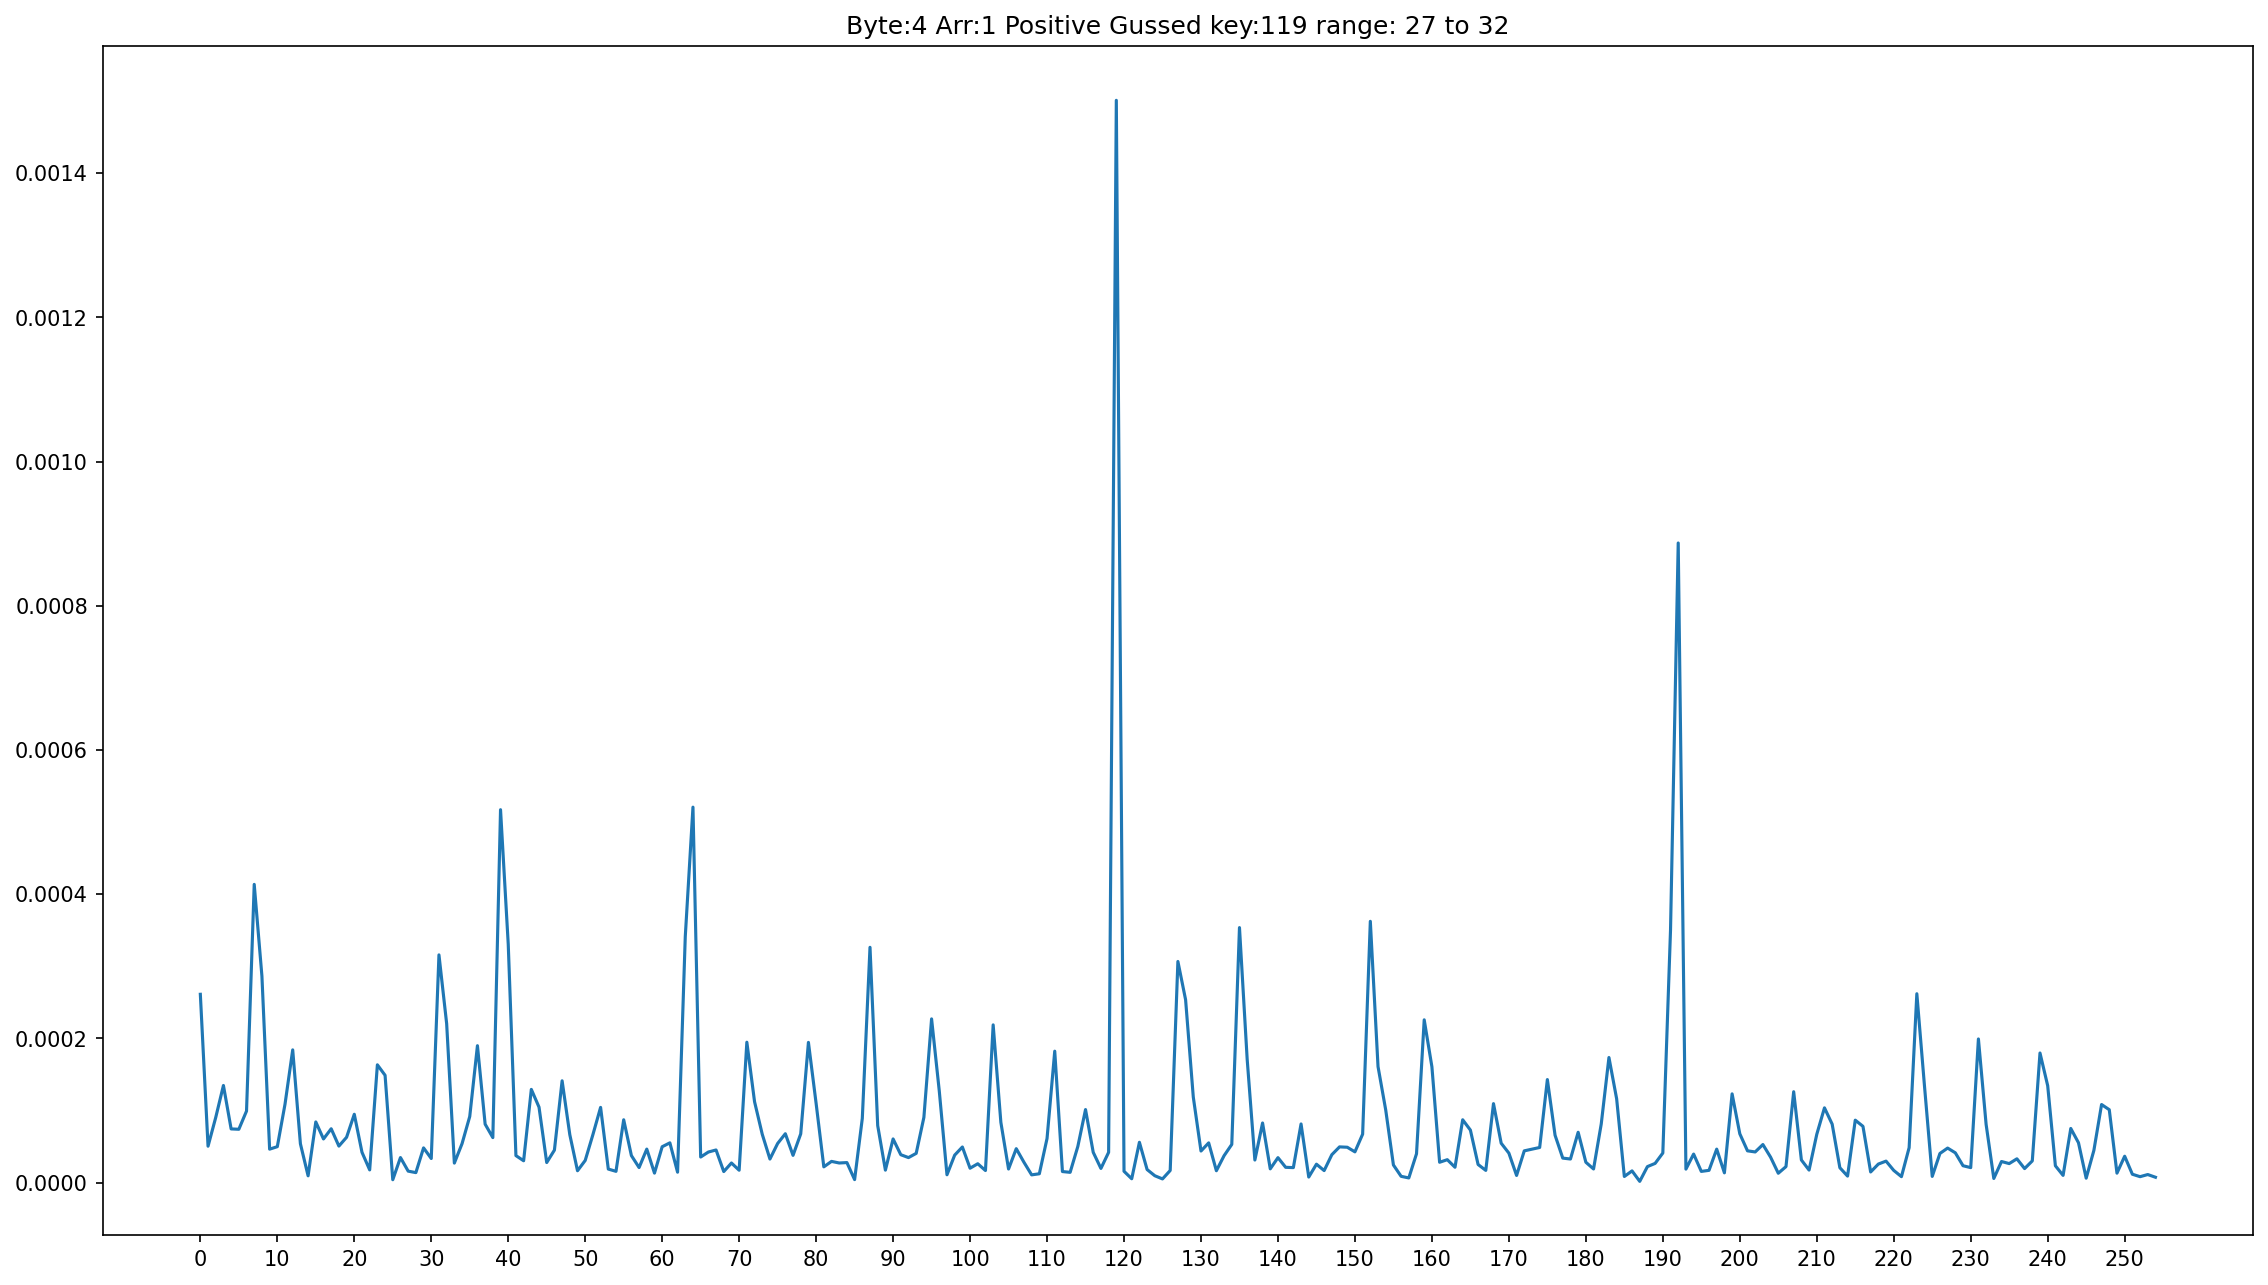

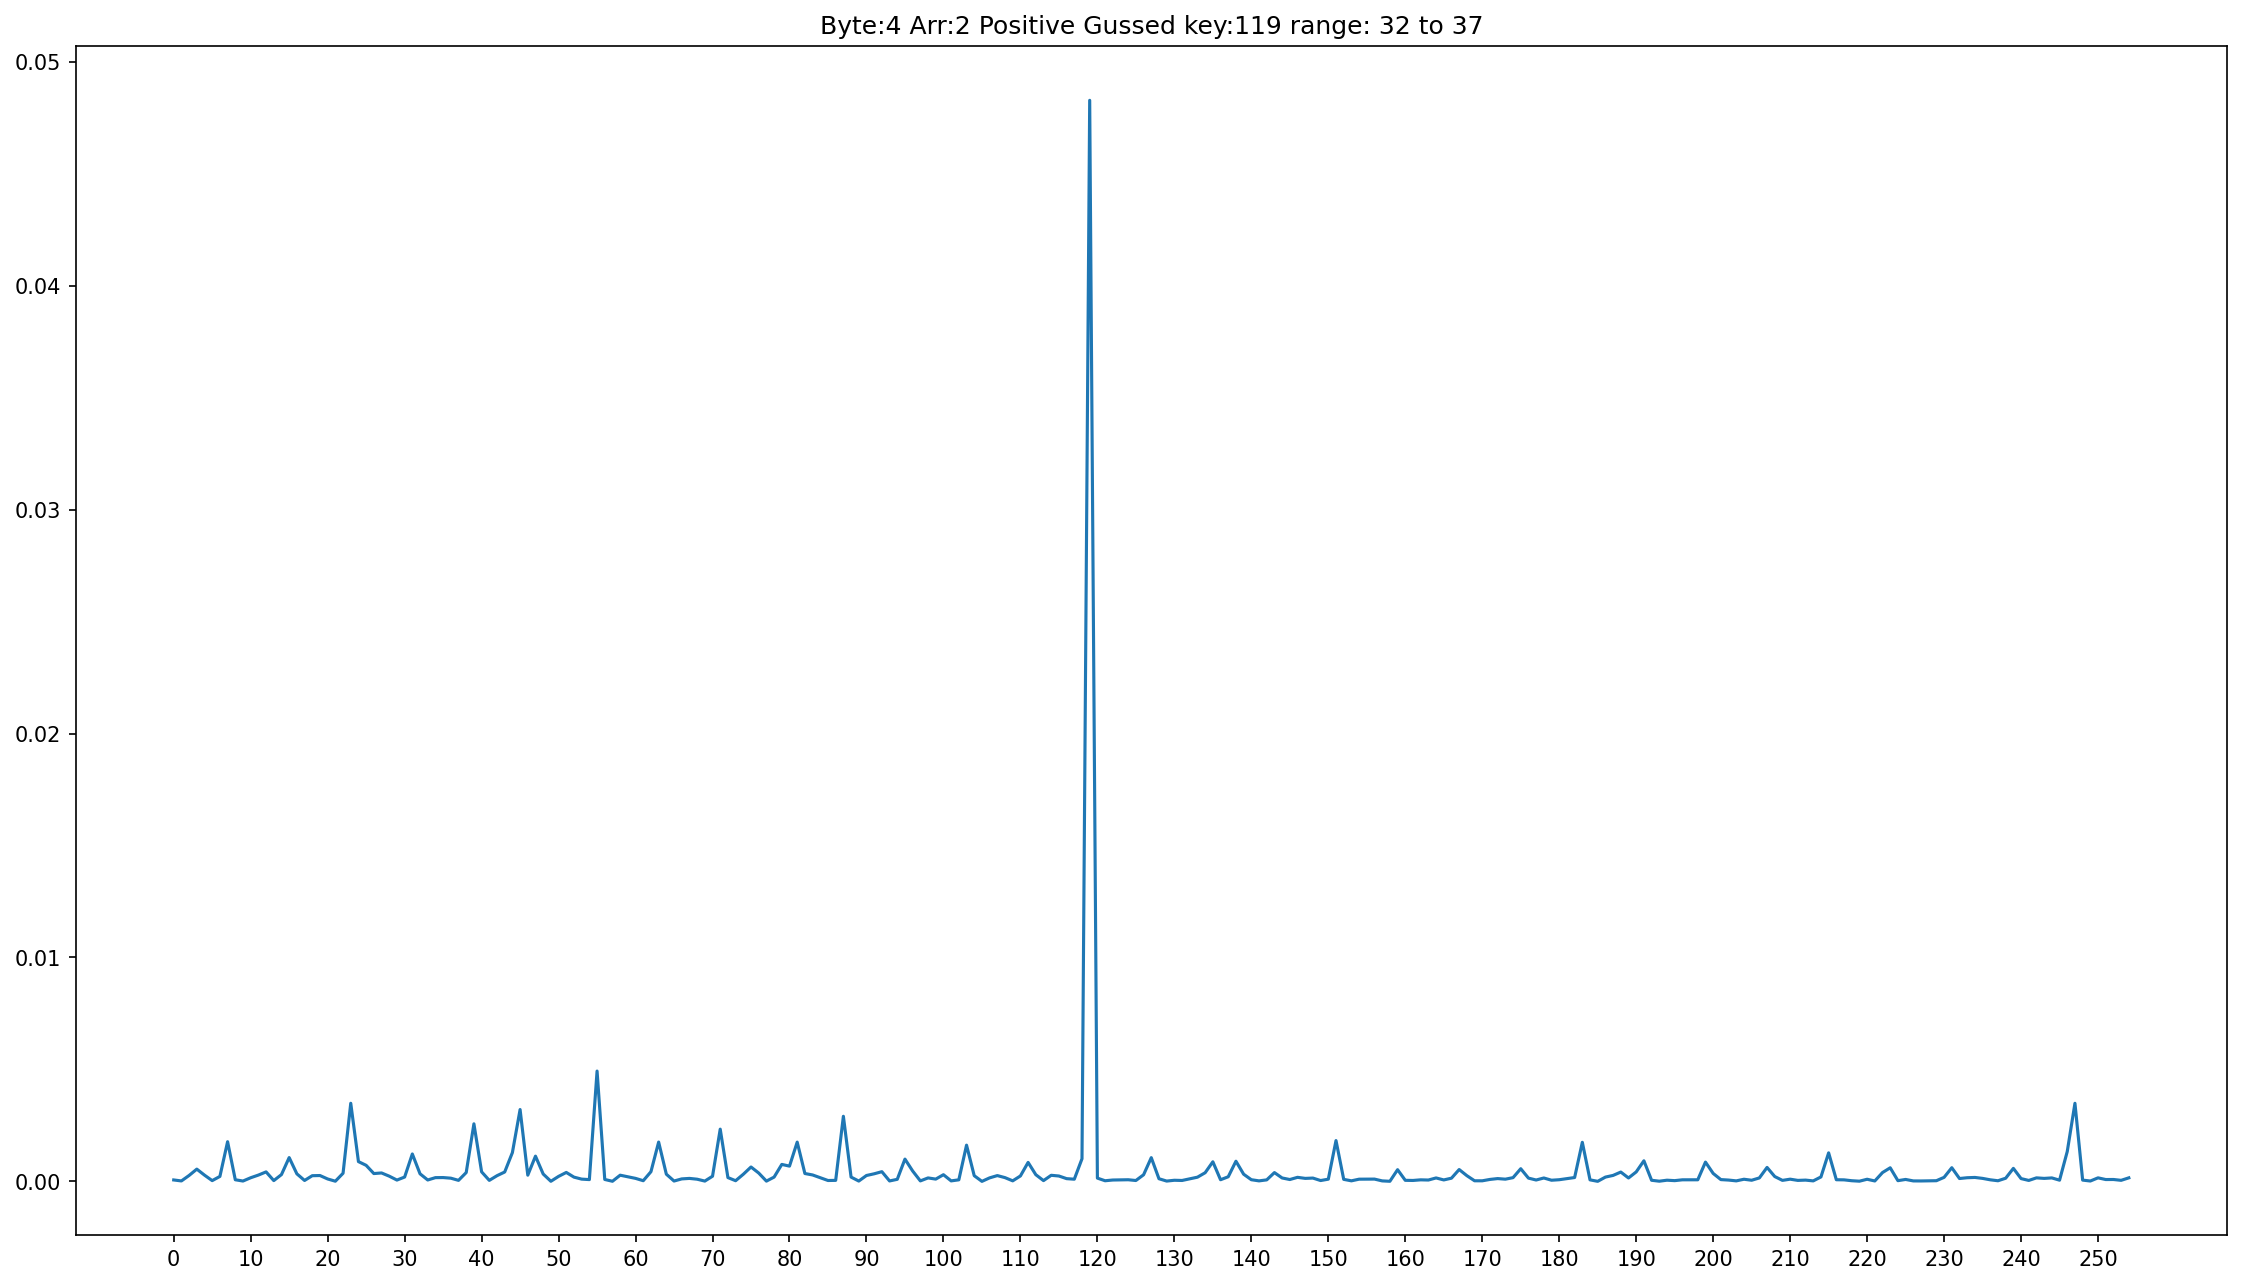

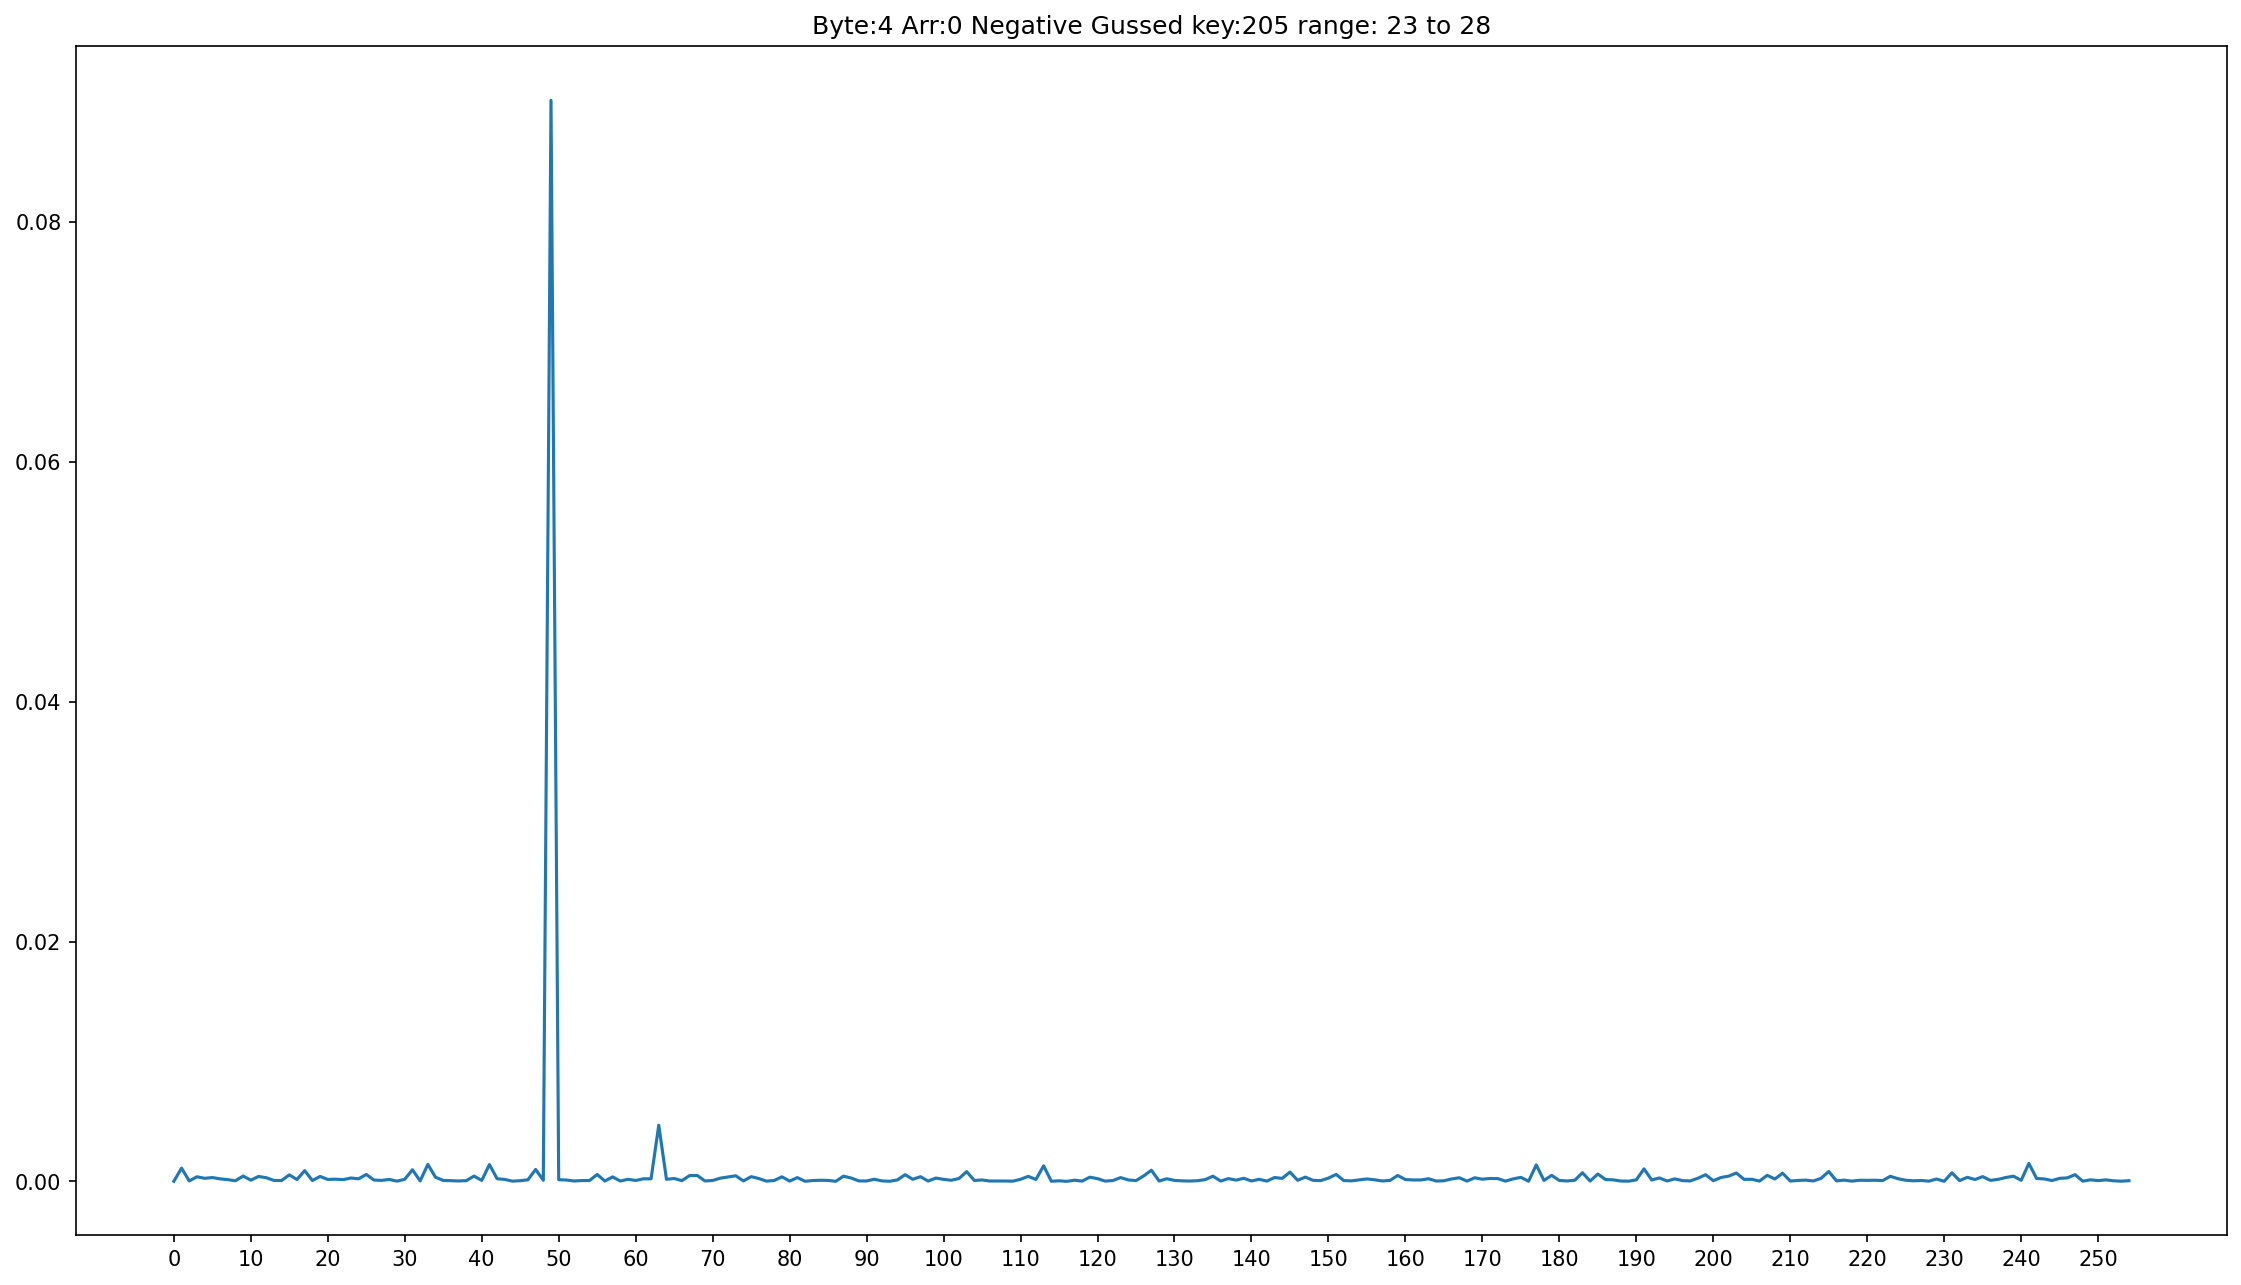

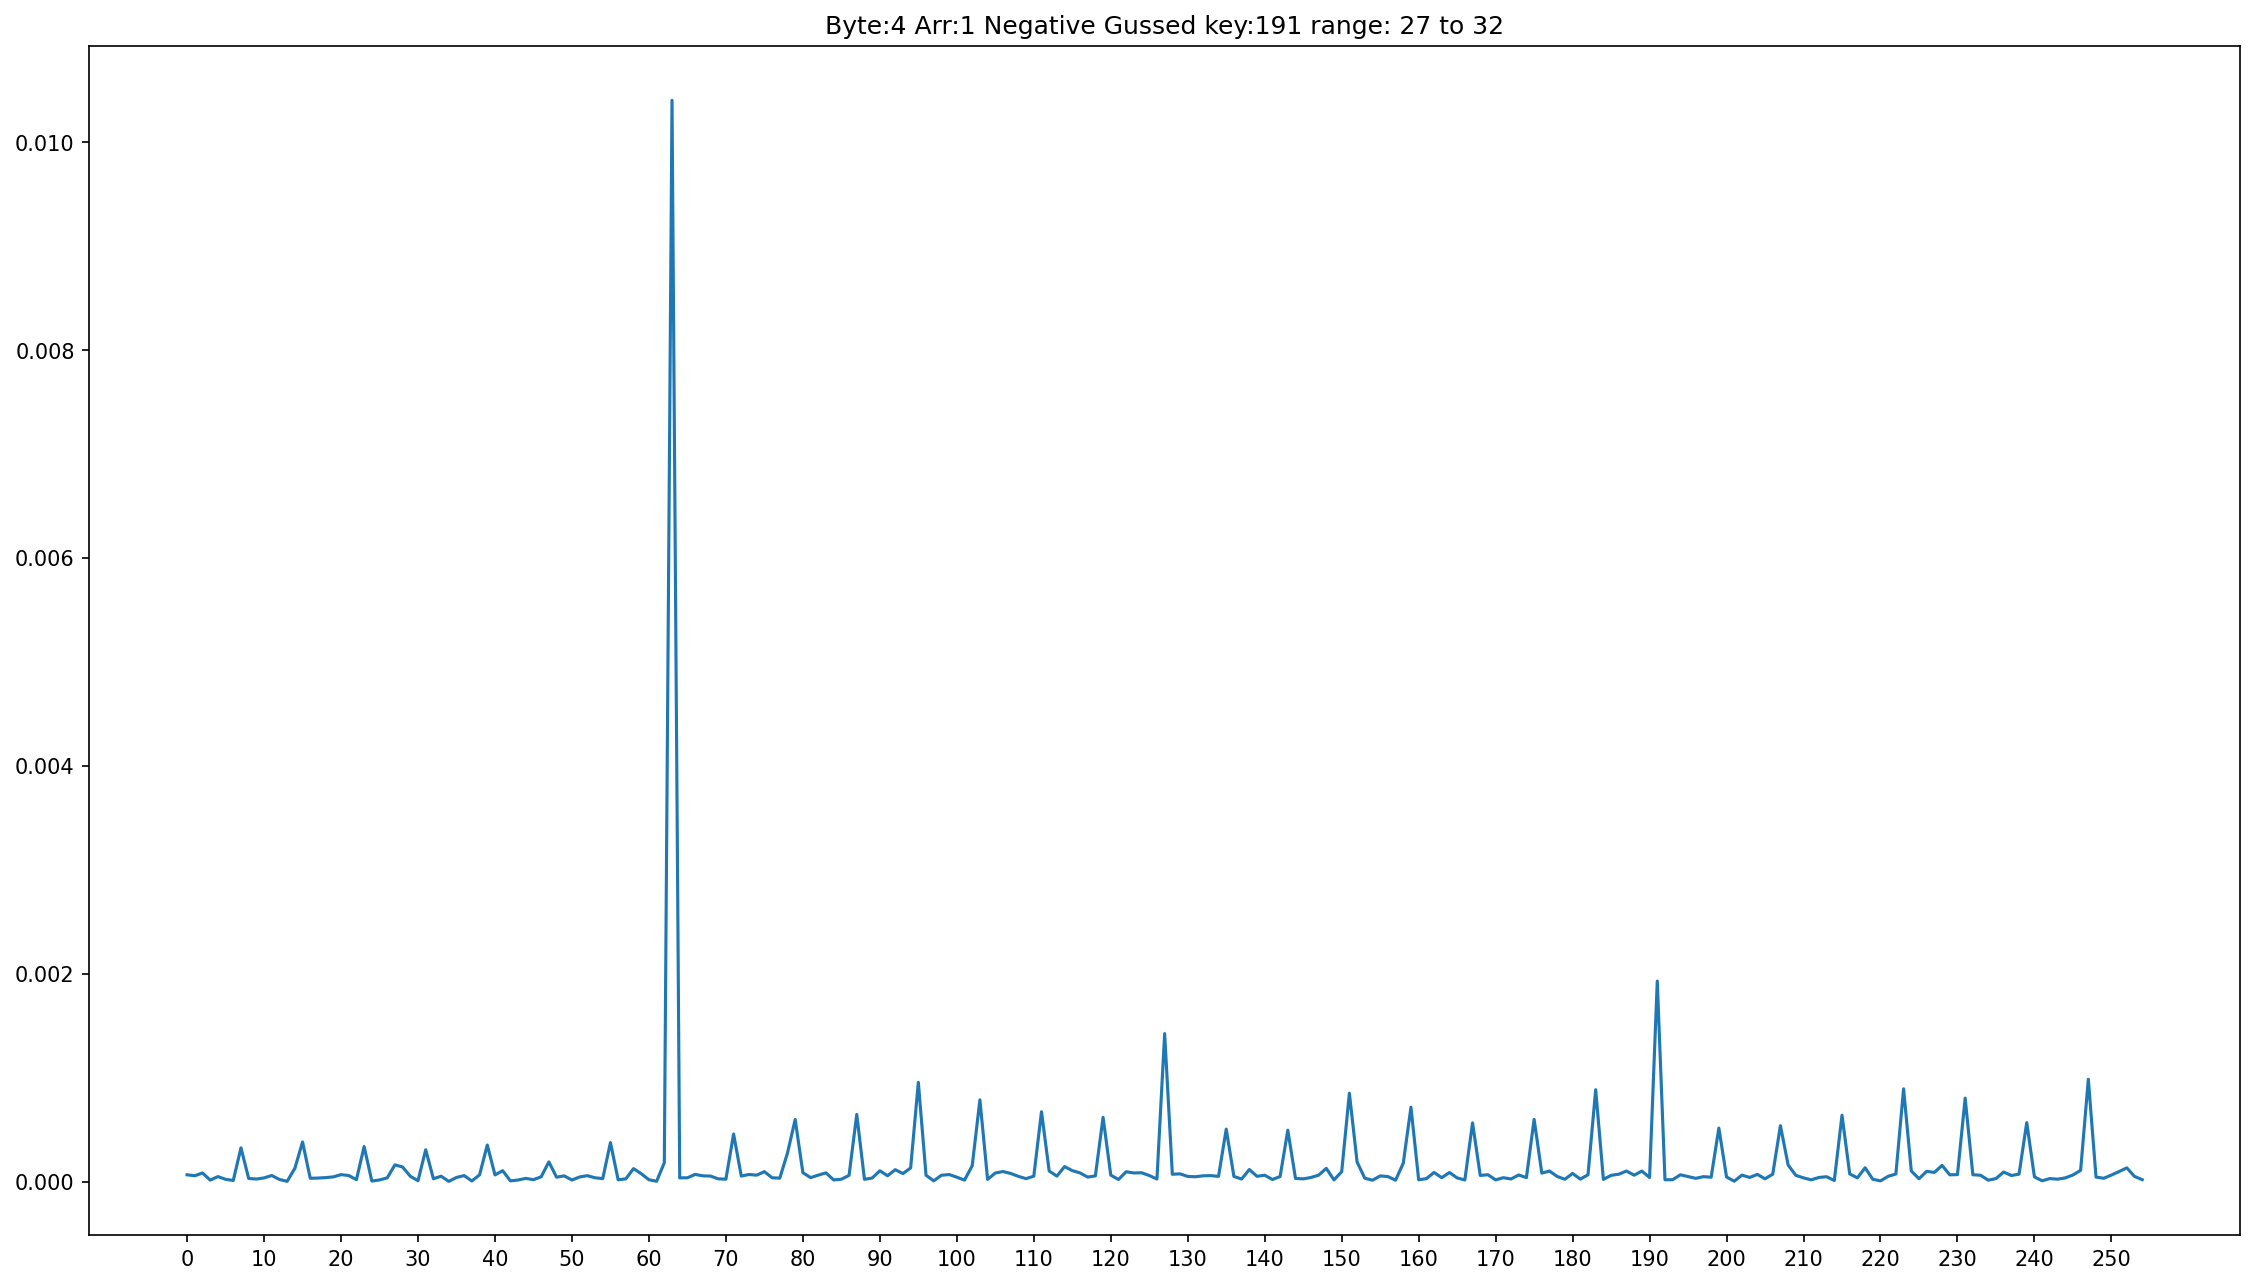

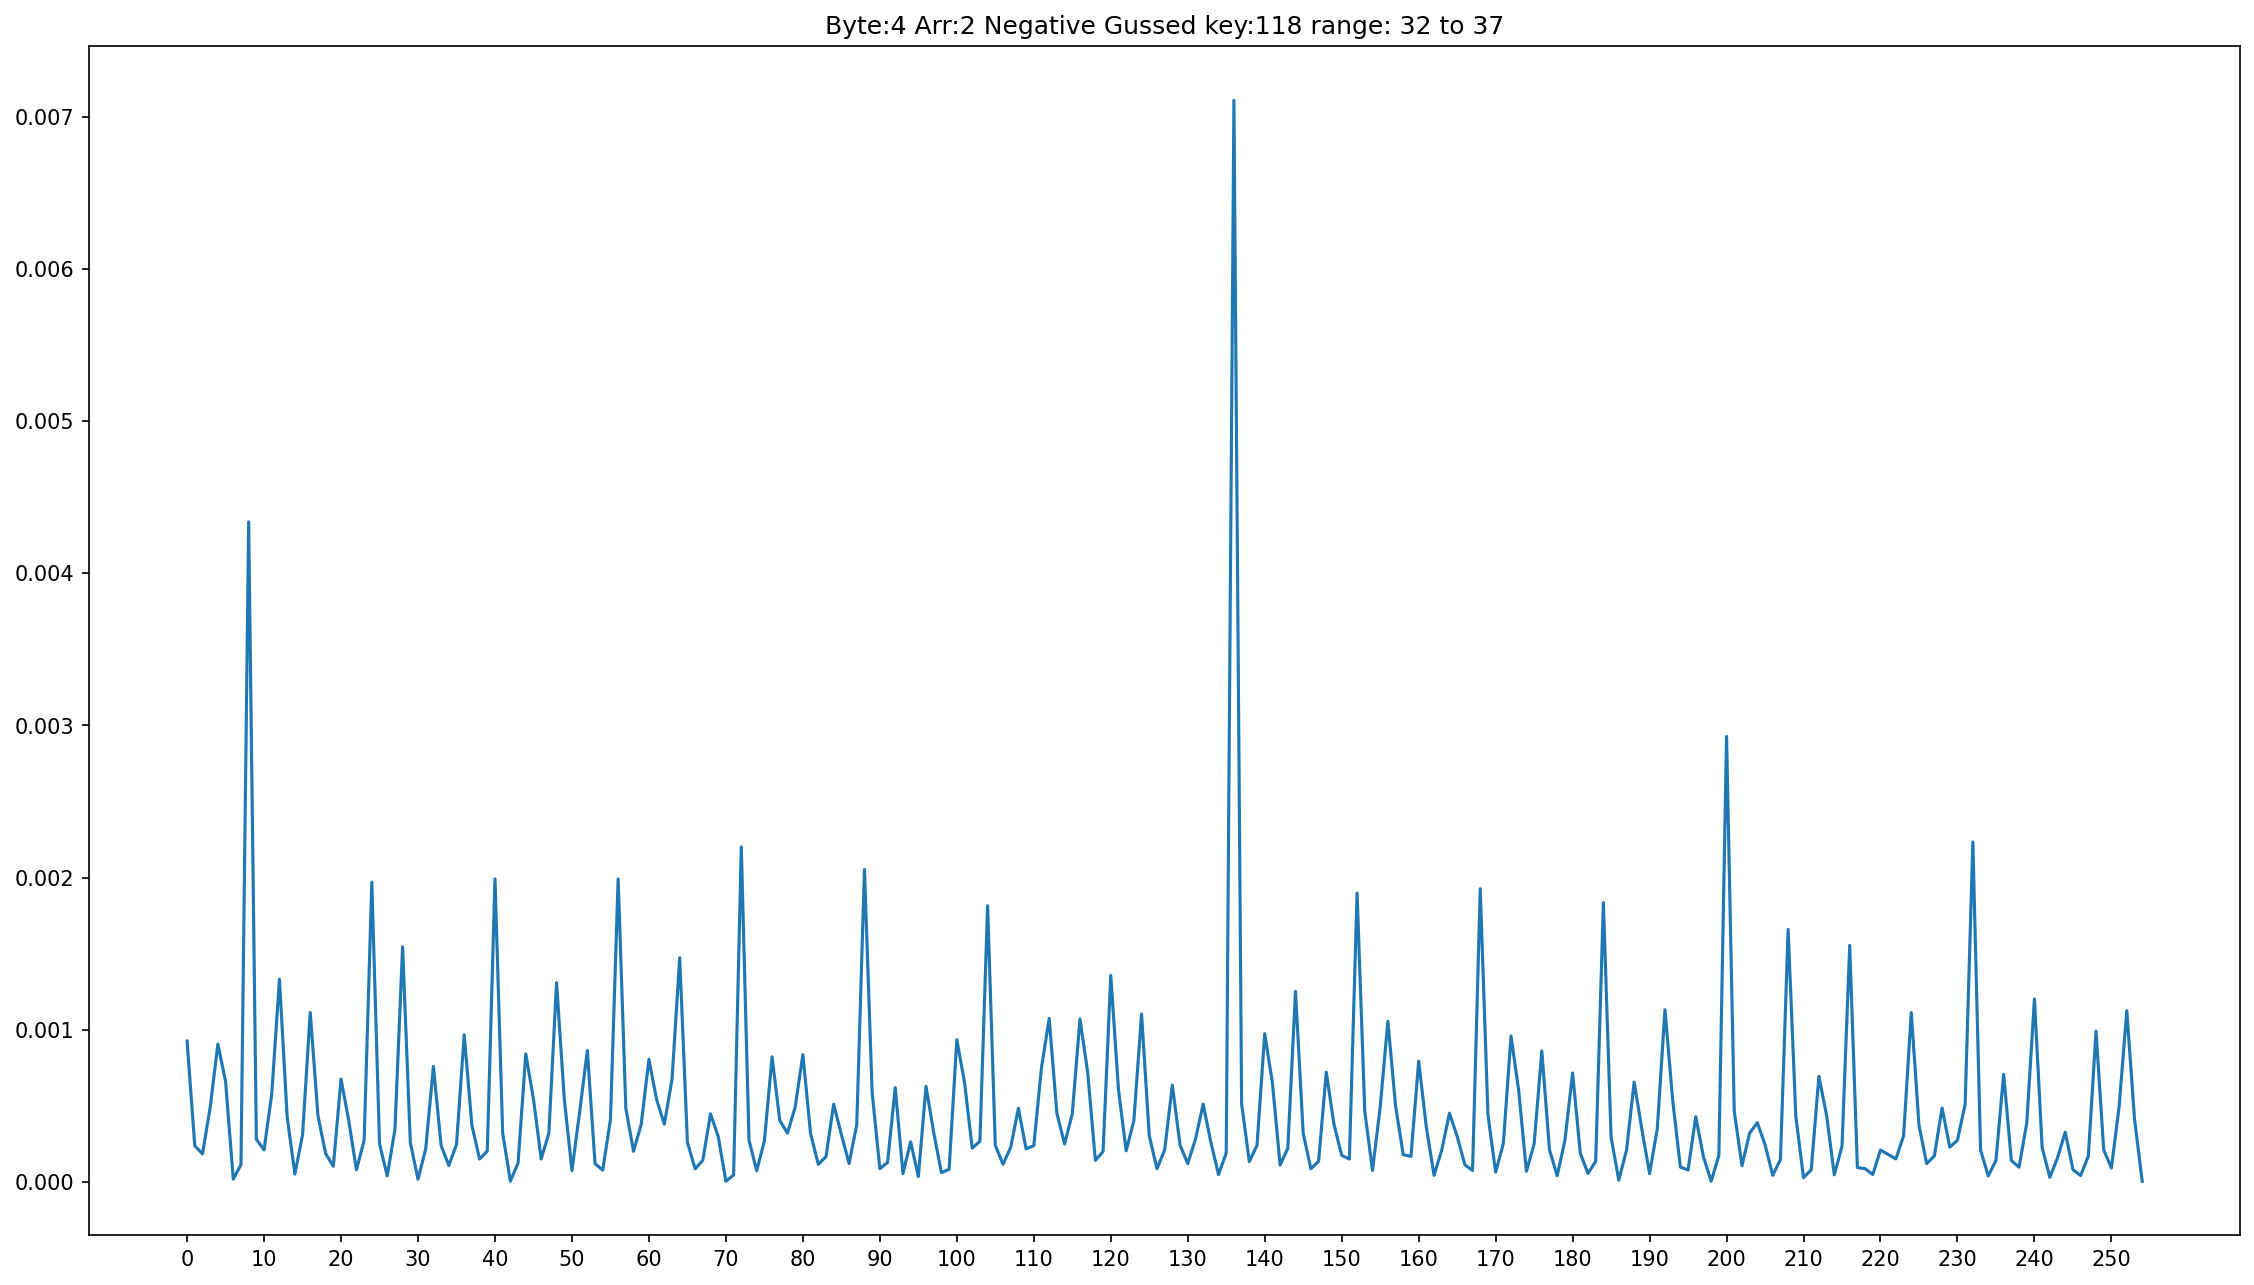

In [87]:
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import time

T=40
D= 256
k_possible=255
t_init_list=[23,27,32]
t_range=5

memory_positive=np.zeros([12], dtype='int')
memory_negative=np.zeros([12], dtype='int')

memory_pos_corr=np.zeros([12], dtype='float')
memory_neg_corr=np.zeros([12], dtype='float')

picks=np.zeros([2,12], dtype='int')
msg=np.zeros([12],dtype='int')



for byte in range (1,5):
    #Loading the Power
    base_power_substract=np.load("calc_pow_byte%d_sub.npy" %byte)
    base_power_plus=np.load("calc_pow_byte%d_plus.npy" %byte)


    r=np.zeros([k_possible, 1], dtype='float')
    base_power=base_power_substract

    for arr in range (3):
        t_init=t_init_list[arr]


        for i in range (D-1):
            r[i,0], _ = pearsonr(base_power[i,t_init:t_init+t_range], base_power[i+1,t_init:t_init+t_range])

        corr=1-(np.abs(r));
        guessed_key_array=np.argsort(np.abs(corr),axis=0)
        found_key=guessed_key_array[-1,0]
        max_corr=max(corr)
        
        memory_pos_corr[(byte-1)+arr*4]=max_corr
        memory_positive[(byte-1)+arr*4]=found_key
        picks[0,(byte-1)+arr*4] = (corr > max(corr)*0.20).sum()

        #print('Byte:'+str(byte)+' Gussed key:' +str(found_key)+" Corr: %f " %(max_corr))

        plt.figure(figsize=(18.5, 10.5), dpi=150)
        axes = plt.gca()
        plt.plot(corr)
        plt.title('Byte:'+str(byte)+' Arr:'+str(arr)+' Positive Gussed key:' +str(found_key)+" range: %d to %d" %(t_init,t_init+t_range))
        plt.xticks(np.arange(0, len(corr)+1, 10))


    r=np.zeros([k_possible, 1], dtype='float')
    base_power=base_power_plus   
        
    for arr in range (3):   
        base_power=base_power_plus
        t_init=t_init_list[arr]

        for i in range (D-1):
            r[i,0], _ = pearsonr(base_power[i,t_init:t_init+t_range], base_power[i+1,t_init:t_init+t_range])

        corr=1-(np.abs(r));
        guessed_key_array=np.argsort(np.abs(corr),axis=0)
        found_key=255-guessed_key_array[-1,0]-1
        max_corr=max(corr)
        #print('Byte:'+str(byte)+' Gussed key:' +str(found_key)+" Corr: %f " %(max_corr))
        memory_neg_corr[(byte-1)+arr*4]=max_corr
        memory_negative[(byte-1)+arr*4]=found_key
        picks[1,(byte-1)+arr*4] = (corr > max(corr)*0.20).sum()


        plt.figure(figsize=(18.5, 10.5), dpi=150)
        axes = plt.gca()
        plt.plot(corr)
        plt.title('Byte:'+str(byte)+' Arr:'+str(arr)+' Negative Gussed key:' +str(found_key)+" range: %d to %d" %(t_init,t_init+t_range))
        plt.xticks(np.arange(0, len(corr)+1, 10))
        



#final value finding

for i in range (12):
    
    print("pos: %d Neg: %d pp:%d pn:%d pco:%f pcn:%f" %(memory_positive[i],memory_negative[i],picks[0,i],picks[1,i], memory_pos_corr[i], memory_neg_corr[i]))
    if (memory_pos_corr[i] >= memory_neg_corr[i]):
        msg[i]=memory_positive[i]
    else:
        msg[i]=memory_negative[i]

print(picks[0,:])   
print(memory_positive)
print(picks[1,:])   
print(memory_negative) 
print("Final Memory:", msg)

#[29, 27, 226, 76]
#[31, 115, 120, 221]
#[102, 182, 143, 177]

In [110]:
msg=[103, 211, 58, 205, 180, 30, 156, 191, 231, 5, 33, 119]
msg=list(msg)

print("Found Memory:",msg)
target.simpleserial_write('a',bytearray(msg))
out_arr=target.simpleserial_read('r', 1)
print(out_arr)

Found Memory: [103, 211, 58, 205, 180, 30, 156, 191, 231, 5, 33, 119]
CWbytearray(b'01')


In [108]:
mem_pos=list([103,  30,  58, 206, 180,  30, 157, 119, 231,   5,  33, 119])
mem_neg=list([179, 211, 156, 205, 179, 127, 156, 191, 230,   4,  32, 118])
            [103, 211, 58, 205, 180, 30, 156, 191, 231, 5, 33, 119]
mem_possible=[]
for i in trange (2**12):
    bin_str=format(i, '012b')
    #print(bin_str)
    msg=[0]*12
    for j in range (12):
        if (bin_str[j]=='0'):
            msg[j]=mem_pos[j]
        else:
            msg[j]=mem_neg[j]
    #print(msg)
    mem_possible.append(msg)
    
    #print(msg)
    target.simpleserial_write('a',bytearray(msg))
    out_arr=target.simpleserial_read('r', 1)
    
    if (list(out_arr) != [0]):
        print(list(out_arr))
        print(list(msg))
        
#print(mem_possible)

  0%|          | 0/4096 [00:00<?, ?it/s]

[1]
[103, 211, 58, 205, 180, 30, 156, 191, 231, 5, 33, 119]


In [101]:
mem_possible[1]

[103, 30, 58, 206, 180, 30, 157, 119, 231, 5, 33, 118]